In [ ]:
!pip install -q -U google-generativeai openpyxl gnews

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.1/331.1 kB 11.8 MB/s eta 0:00:00


# v1

/tmp/ipython-input-800557673.py:54: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dados = yf.download(tickers_com_ibov, start=start, end=end)
[**********************71%*********              ]  5 of 7 completed

Cache encontrado e completo. Carregando eventos locais.
Baixando dados de preços de 2015-01-01 a 2024-12-31...


[*********************100%***********************]  7 of 7 completed


Download de preços concluído.

Iniciando estudo de eventos...

--- ANÁLISE DE RESULTADOS ---
Total de eventos analisados: 162
Pico de 'Alfa' (retorno acima do Ibovespa) ocorre no: D+20
Alfa médio no pico: 0.44%

Resultados detalhados exportados para o arquivo 'Analise_de_Eventos_com_Ibov.xlsx'


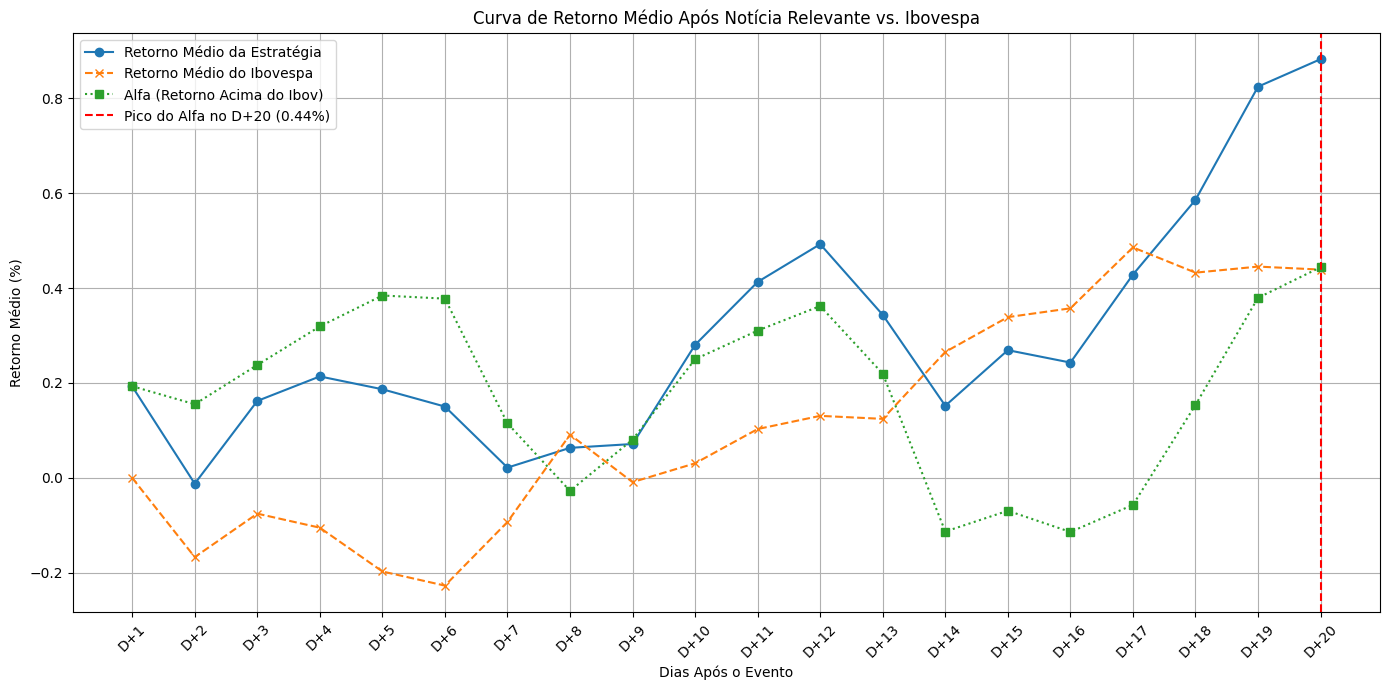

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from gnews import GNews
import json
import os
import google.generativeai as genai
from google.colab import userdata
import re

# Configurações do Pandas
pd.set_option('display.max_rows', None); pd.set_option('display.max_columns', None); pd.set_option('display.width', 2000); pd.set_option('display.max_colwidth', None)

# --------------------------------------------------------------------------
# ETAPA 1: CONFIGURAÇÃO DO ESTUDO DE EVENTOS
# --------------------------------------------------------------------------
try:
    GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
    genai.configure(api_key=GEMINI_API_KEY)
except Exception as e:
    print("ERRO: Não foi possível carregar a chave 'GEMINI_API_KEY'. Verifique se ela foi criada nos Secrets do Colab.")
    exit()

MODELO_GEMINI = genai.GenerativeModel('models/gemini-2.5-flash-lite')

# --- PARÂMETROS DE CONTROLE DE API (Mantidos conforme sua configuração) ---
RPM_LIMIT = 11
TOTAL_API_CALL_LIMIT = 700
SLEEP_TIME_SECONDS = 60 / RPM_LIMIT

data_inicio = '2015-01-01'
data_fim = '2024-12-31'
DIAS_DE_ANALISE = 20

universo_investimento = ['PETR4.SA', 'VALE3.SA', 'SUZB3.SA', 'AMBP3.SA', 'ELET3.SA', 'RAIZ4.SA']
mapa_tickers_para_nomes = {
    'PETR4.SA': 'Petrobras', 'VALE3.SA': 'Vale', 'SUZB3.SA': 'Suzano',
    'AMBP3.SA': 'Ambipar', 'ELET3.SA': 'Eletrobras', 'RAIZ4.SA': 'Raízen'
}
keywords_busca_ampla = ['sustentabilidade', 'ESG', 'crédito de carbono', 'meio ambiente', 'energia renovável']
NOME_ARQUIVO_CACHE = 'eventos_gemini_gnews_cache.json'

# --------------------------------------------------------------------------
# ETAPA 2: FUNÇÕES DE COLETA E CLASSIFICAÇÃO COM IA
# --------------------------------------------------------------------------
def buscar_dados_acoes(tickers, start, end):
    print(f"Baixando dados de preços de {start} a {end}...")
    try:
        # MUDANÇA: Adiciona o ticker do Ibovespa à lista de download
        tickers_com_ibov = tickers + ['^BVSP']
        dados = yf.download(tickers_com_ibov, start=start, end=end)
        dados.sort_index(inplace=True)
        if dados.empty:
            print("Nenhum dado de preço foi baixado."); return None
        print("Download de preços concluído.")
        return dados
    except Exception as e:
        print(f"Ocorreu um erro ao baixar os dados de preços: {e}"); return None

def classificar_manchete_com_gemini(manchete, api_counter):
    if api_counter['count'] >= api_counter['limit']:
        print("  - Limite total de chamadas de API atingido nesta execução. Parando a classificação.")
        return None
    prompt = f"""
    Analise a seguinte manchete de notícia. A manchete reporta um novo e concreto investimento, contrato, certificação, ou iniciativa positiva de uma empresa no setor de 'carbono verde', sustentabilidade ou descarbonização?
    Responda APENAS com 'SIM' ou 'NÃO'.
    Manchete: "{manchete}"
    """
    max_tentativas = 3
    for tentativa in range(max_tentativas):
        try:
            api_counter['count'] += 1
            print(f"  - Chamada à API #{api_counter['count']}/{api_counter['limit']}...")
            response = MODELO_GEMINI.generate_content(prompt)
            return "SIM" in response.text.strip().upper()
        except Exception as e:
            error_message = str(e); print(f"  - Erro na API do Gemini (tentativa {tentativa + 1}): {error_message}")
            if '429' in error_message and 'quota' in error_message:
                match = re.search(r"retry in (\d+\.\d+)s", error_message)
                if match:
                    tempo_espera = float(match.group(1)) + 1
                    print(f"  - Limite de RPM atingido. Aguardando {tempo_espera:.2f}s...")
                    time.sleep(tempo_espera); api_counter['count'] -= 1; continue
            time.sleep(5)
    print(f"  - Falha ao classificar após {max_tentativas} tentativas. Classificando como NÃO.")
    return False

def construir_cache_de_eventos(tickers_validos, nomes_mapa, start_str, end_str):
    print("\nIniciando 'Caça aos Sinais'...")
    eventos_encontrados = []; ultimo_ano_processado = 0
    if os.path.exists(NOME_ARQUIVO_CACHE):
        with open(NOME_ARQUIVO_CACHE, 'r', encoding='utf-8') as f:
            cache_antigo = json.load(f)
            eventos_encontrados = cache_antigo.get('eventos', [])
            ultimo_ano_processado = cache_antigo.get('metadata', {}).get('ultimo_ano_processado', 0)
        print(f"Progresso carregado. Continuando a partir de {ultimo_ano_processado + 1}.")
    api_counter = {'count': 0, 'limit': TOTAL_API_CALL_LIMIT}
    start_date = datetime.datetime.strptime(start_str, '%Y-%m-%d'); end_date = datetime.datetime.strptime(end_str, '%Y-%m-%d')
    ano_de_inicio = ultimo_ano_processado + 1 if ultimo_ano_processado > 0 else start_date.year
    for year in range(ano_de_inicio, end_date.year + 1):
        if api_counter['count'] >= api_counter['limit']: break
        print(f"\n===== PROCESSANDO ANO: {year} =====")
        google_news = GNews(language='pt', country='BR', start_date=datetime.date(year, 1, 1), end_date=datetime.date(year, 12, 31))
        for ticker in tickers_validos:
            if api_counter['count'] >= api_counter['limit']: break
            nome_empresa = nomes_mapa.get(ticker)
            if not nome_empresa: continue
            print(f"--- Buscando notícias para {nome_empresa} ---")
            query = f'"{nome_empresa}" AND ({ " OR ".join(keywords_busca_ampla) })'; noticias = google_news.get_news(query); time.sleep(1)
            if noticias:
                print(f"  -> {len(noticias)} notícias encontradas. Classificando...")
                for n in noticias:
                    if nome_empresa.lower() in n['title'].lower():
                        resultado = classificar_manchete_com_gemini(n['title'], api_counter)
                        if resultado is None: api_counter['count'] = api_counter['limit']; break
                        if resultado:
                            data_obj_str = datetime.datetime.strptime(n['published date'], '%a, %d %b %Y %H:%M:%S GMT').strftime('%Y-%m-%d')
                            eventos_encontrados.append({'Data': data_obj_str, 'Ticker': ticker, 'Manchete': n['title']})
                            print(f"  >>> SINAL ENCONTRADO: {data_obj_str} - {ticker}")
                        time.sleep(SLEEP_TIME_SECONDS)
        df_eventos = pd.DataFrame(eventos_encontrados); df_eventos.drop_duplicates(subset=['Data', 'Ticker'], inplace=True)
        eventos_unicos = df_eventos.to_dict('records')
        cache_conteudo = {'metadata': {'ultimo_ano_processado': year, 'data_fim': end_str}, 'eventos': eventos_unicos}
        with open(NOME_ARQUIVO_CACHE, 'w', encoding='utf-8') as f: json.dump(cache_conteudo, f, ensure_ascii=False, indent=4)
        print(f"Progresso salvo. {len(eventos_unicos)} eventos totais no cache.")
    if api_counter['count'] < api_counter['limit']: print("\nBusca concluída para todo o período!")
    else: print("\nLimite de API atingido. Rode novamente no dia seguinte para continuar.")
    return eventos_unicos

# --------------------------------------------------------------------------
# ETAPA 3: FUNÇÃO DE ANÁLISE DE EVENTOS
# --------------------------------------------------------------------------
def executar_estudo_de_eventos(eventos, dados_acoes):
    print("\nIniciando estudo de eventos...")
    resultados = []
    for evento in eventos:
        ticker = evento['Ticker']
        if ticker not in dados_acoes['Open'].columns: continue
        data_evento = pd.to_datetime(evento['Data'])
        dias_de_negociacao = dados_acoes.index[dados_acoes.index > data_evento]
        if len(dias_de_negociacao) < DIAS_DE_ANALISE: continue
        data_compra = dias_de_negociacao[0]
        # MUDANÇA: Pega o preço de entrada da ação E do Ibovespa
        preco_entrada_ativo = dados_acoes.loc[data_compra, ('Open', ticker)]
        preco_entrada_ibov = dados_acoes.loc[data_compra, ('Open', '^BVSP')]
        if pd.isna(preco_entrada_ativo) or preco_entrada_ativo == 0 or pd.isna(preco_entrada_ibov) or preco_entrada_ibov == 0: continue
        dias_analise = dias_de_negociacao[0:DIAS_DE_ANALISE]
        resultado_linha = {'Data_Evento': data_evento.date(), 'Ticker': ticker, 'Manchete': evento['Manchete']}
        for i, dia in enumerate(dias_analise):
            preco_fechamento_ativo = dados_acoes.loc[dia, ('Close', ticker)]
            preco_fechamento_ibov = dados_acoes.loc[dia, ('Close', '^BVSP')]
            retorno_ativo = (preco_fechamento_ativo / preco_entrada_ativo) - 1
            retorno_ibov = (preco_fechamento_ibov / preco_entrada_ibov) - 1
            resultado_linha[f'D+{i+1}_Ativo'] = retorno_ativo
            resultado_linha[f'D+{i+1}_Ibov'] = retorno_ibov
        resultados.append(resultado_linha)
    return pd.DataFrame(resultados)

# --------------------------------------------------------------------------
# ETAPA 4: ORQUESTRAÇÃO E ANÁLISE FINAL
# --------------------------------------------------------------------------
if os.path.exists(NOME_ARQUIVO_CACHE):
    with open(NOME_ARQUIVO_CACHE, 'r', encoding='utf-8') as f: cache_data = json.load(f)
    if cache_data.get('metadata', {}).get('ultimo_ano_processado', 0) >= datetime.datetime.strptime(data_fim, '%Y-%m-%d').year:
        print(f"Cache encontrado e completo. Carregando eventos locais.")
        eventos = cache_data.get('eventos', [])
    else: eventos = construir_cache_de_eventos(list(mapa_tickers_para_nomes.keys()), mapa_tickers_para_nomes, data_inicio, data_fim)
else: eventos = construir_cache_de_eventos(list(mapa_tickers_para_nomes.keys()), mapa_tickers_para_nomes, data_inicio, data_fim)

if not eventos:
    print("\nNenhum evento relevante foi encontrado. A análise não pode continuar.")
else:
    dados_acoes_total = buscar_dados_acoes(universo_investimento, data_inicio, data_fim)
    if dados_acoes_total is not None:
        df_resultados = executar_estudo_de_eventos(eventos, dados_acoes_total)
        if not df_resultados.empty:
            # MUDANÇA: Calcula a média para a estratégia, para o Ibov e para o Alfa
            df_retornos_ativo = df_resultados.filter(regex=r'_Ativo$')
            df_retornos_ibov = df_resultados.filter(regex=r'_Ibov$')
            # Renomeia colunas para facilitar o cálculo
            df_retornos_ativo.columns = [f'D+{i+1}' for i in range(DIAS_DE_ANALISE)]
            df_retornos_ibov.columns = [f'D+{i+1}' for i in range(DIAS_DE_ANALISE)]

            retorno_medio_ativo = df_retornos_ativo.mean()
            retorno_medio_ibov = df_retornos_ibov.mean()
            retorno_alpha = retorno_medio_ativo - retorno_medio_ibov # Alfa = Retorno do Ativo - Retorno do Mercado

            dia_do_pico_alpha = retorno_alpha.idxmax()
            valor_pico_alpha = retorno_alpha.max()

            print("\n--- ANÁLISE DE RESULTADOS ---")
            print(f"Total de eventos analisados: {len(df_resultados)}")
            print(f"Pico de 'Alfa' (retorno acima do Ibovespa) ocorre no: {dia_do_pico_alpha}")
            print(f"Alfa médio no pico: {valor_pico_alpha:.2%}")

            nome_arquivo_excel = 'Analise_de_Eventos_com_Ibov.xlsx'
            with pd.ExcelWriter(nome_arquivo_excel, engine='openpyxl') as writer:
                df_resultados.to_excel(writer, sheet_name='Resultados_por_Evento', index=False)
                retorno_medio_ativo.to_frame(name='Retorno_Medio_Ativo').to_excel(writer, sheet_name='Resumo_Medio_Ativo')
                retorno_medio_ibov.to_frame(name='Retorno_Medio_Ibov').to_excel(writer, sheet_name='Resumo_Medio_Ibov')
                retorno_alpha.to_frame(name='Alfa_Medio').to_excel(writer, sheet_name='Resumo_Alfa')
            print(f"\nResultados detalhados exportados para o arquivo '{nome_arquivo_excel}'")

            # MUDANÇA: Gráfico agora tem 3 linhas
            plt.figure(figsize=(14, 7))
            plt.plot(retorno_medio_ativo.index, retorno_medio_ativo.values * 100, marker='o', linestyle='-', label='Retorno Médio da Estratégia')
            plt.plot(retorno_medio_ibov.index, retorno_medio_ibov.values * 100, marker='x', linestyle='--', label='Retorno Médio do Ibovespa')
            plt.plot(retorno_alpha.index, retorno_alpha.values * 100, marker='s', linestyle=':', label='Alfa (Retorno Acima do Ibov)')
            plt.title('Curva de Retorno Médio Após Notícia Relevante vs. Ibovespa')
            plt.xlabel('Dias Após o Evento'); plt.ylabel('Retorno Médio (%)')
            plt.axvline(x=dia_do_pico_alpha, color='r', linestyle='--', label=f'Pico do Alfa no {dia_do_pico_alpha} ({valor_pico_alpha:.2%})')
            plt.grid(True); plt.legend(); plt.xticks(rotation=45); plt.tight_layout(); plt.show()
        else: print("\nNenhuma operação pôde ser simulada com os eventos encontrados.")

#v2


Iniciando 'Caça aos Sinais'...

===== PROCESSANDO ANO: 2015 =====
--- Buscando notícias para Petrobras ---
  -> 6 notícias encontradas. Classificando...
  - Chamada à API #1/700...
--- Buscando notícias para Vale ---
  -> 39 notícias encontradas. Classificando...
  - Chamada à API #2/700...
  - Chamada à API #3/700...
  - Chamada à API #4/700...
  - Chamada à API #5/700...
  - Chamada à API #6/700...
  - Chamada à API #7/700...
  - Chamada à API #8/700...
--- Buscando notícias para Suzano ---
  -> 1 notícias encontradas. Classificando...
  - Chamada à API #9/700...
  >>> SINAL ENCONTRADO: 2015-05-18 - SUZB3.SA
--- Buscando notícias para Ambipar ---
--- Buscando notícias para Eletrobras ---
  -> 1 notícias encontradas. Classificando...
--- Buscando notícias para Raízen ---
Progresso salvo. 1 eventos totais no cache.

===== PROCESSANDO ANO: 2016 =====
--- Buscando notícias para Petrobras ---
  -> 3 notícias encontradas. Classificando...
--- Buscando notícias para Vale ---
  -> 25 notíci

/tmp/ipython-input-800557673.py:54: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dados = yf.download(tickers_com_ibov, start=start, end=end)
[**********************57%**                     ]  4 of 7 completed

Progresso salvo. 190 eventos totais no cache.

Busca concluída para todo o período!
Baixando dados de preços de 2015-01-01 a 2024-12-31...


[*********************100%***********************]  7 of 7 completed


Download de preços concluído.

Iniciando estudo de eventos...

--- ANÁLISE DE RESULTADOS ---
Total de eventos analisados: 173
Pico de 'Alfa' (retorno acima do Ibovespa) ocorre no: D+5
Alfa médio no pico: 0.15%

Resultados detalhados exportados para o arquivo 'Analise_de_Eventos_com_Ibov.xlsx'


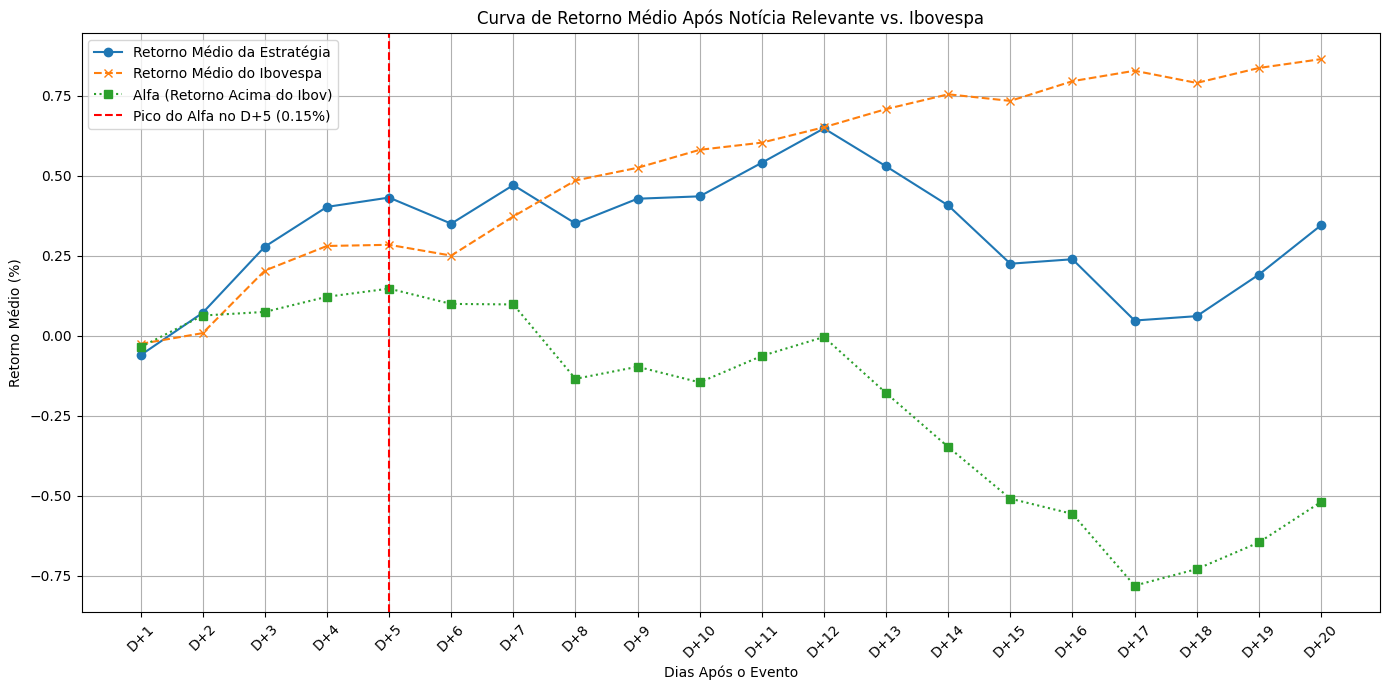

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from gnews import GNews
import json
import os
import google.generativeai as genai
from google.colab import userdata
import re

# Configurações do Pandas
pd.set_option('display.max_rows', None); pd.set_option('display.max_columns', None); pd.set_option('display.width', 2000); pd.set_option('display.max_colwidth', None)

# --------------------------------------------------------------------------
# ETAPA 1: CONFIGURAÇÃO DO ESTUDO DE EVENTOS
# --------------------------------------------------------------------------
try:
    GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
    genai.configure(api_key=GEMINI_API_KEY)
except Exception as e:
    print("ERRO: Não foi possível carregar a chave 'GEMINI_API_KEY'. Verifique se ela foi criada nos Secrets do Colab.")
    exit()

MODELO_GEMINI = genai.GenerativeModel('models/gemini-2.5-flash-lite')

# --- PARÂMETROS DE CONTROLE DE API (Mantidos conforme sua configuração) ---
RPM_LIMIT = 11
TOTAL_API_CALL_LIMIT = 700
SLEEP_TIME_SECONDS = 60 / RPM_LIMIT

data_inicio = '2015-01-01'
data_fim = '2024-12-31'
DIAS_DE_ANALISE = 20

universo_investimento = ['PETR4.SA', 'VALE3.SA', 'SUZB3.SA', 'AMBP3.SA', 'ELET3.SA', 'RAIZ4.SA']
mapa_tickers_para_nomes = {
    'PETR4.SA': 'Petrobras', 'VALE3.SA': 'Vale', 'SUZB3.SA': 'Suzano',
    'AMBP3.SA': 'Ambipar', 'ELET3.SA': 'Eletrobras', 'RAIZ4.SA': 'Raízen'
}
keywords_busca_ampla = ['sustentabilidade', 'ESG', 'crédito de carbono', 'meio ambiente', 'energia renovável']
NOME_ARQUIVO_CACHE = 'eventos_gemini_gnews_cache.json'

# --------------------------------------------------------------------------
# ETAPA 2: FUNÇÕES DE COLETA E CLASSIFICAÇÃO COM IA
# --------------------------------------------------------------------------
def buscar_dados_acoes(tickers, start, end):
    print(f"Baixando dados de preços de {start} a {end}...")
    try:
        # MUDANÇA: Adiciona o ticker do Ibovespa à lista de download
        tickers_com_ibov = tickers + ['^BVSP']
        dados = yf.download(tickers_com_ibov, start=start, end=end)
        dados.sort_index(inplace=True)
        if dados.empty:
            print("Nenhum dado de preço foi baixado."); return None
        print("Download de preços concluído.")
        return dados
    except Exception as e:
        print(f"Ocorreu um erro ao baixar os dados de preços: {e}"); return None

def classificar_manchete_com_gemini(manchete, api_counter):
    if api_counter['count'] >= api_counter['limit']:
        print("  - Limite total de chamadas de API atingido nesta execução. Parando a classificação.")
        return None
    prompt = f"""
    Analise a seguinte manchete de notícia. A manchete reporta um novo e concreto investimento, contrato, certificação, ou iniciativa positiva de uma empresa no setor de 'carbono verde', sustentabilidade ou descarbonização?
    Responda APENAS com 'SIM' ou 'NÃO'.
    Manchete: "{manchete}"
    """
    max_tentativas = 3
    for tentativa in range(max_tentativas):
        try:
            api_counter['count'] += 1
            print(f"  - Chamada à API #{api_counter['count']}/{api_counter['limit']}...")
            response = MODELO_GEMINI.generate_content(prompt)
            return "SIM" in response.text.strip().upper()
        except Exception as e:
            error_message = str(e); print(f"  - Erro na API do Gemini (tentativa {tentativa + 1}): {error_message}")
            if '429' in error_message and 'quota' in error_message:
                match = re.search(r"retry in (\d+\.\d+)s", error_message)
                if match:
                    tempo_espera = float(match.group(1)) + 1
                    print(f"  - Limite de RPM atingido. Aguardando {tempo_espera:.2f}s...")
                    time.sleep(tempo_espera); api_counter['count'] -= 1; continue
            time.sleep(5)
    print(f"  - Falha ao classificar após {max_tentativas} tentativas. Classificando como NÃO.")
    return False

def construir_cache_de_eventos(tickers_validos, nomes_mapa, start_str, end_str):
    print("\nIniciando 'Caça aos Sinais'...")
    eventos_encontrados = []; ultimo_ano_processado = 0
    if os.path.exists(NOME_ARQUIVO_CACHE):
        with open(NOME_ARQUIVO_CACHE, 'r', encoding='utf-8') as f:
            cache_antigo = json.load(f)
            eventos_encontrados = cache_antigo.get('eventos', [])
            ultimo_ano_processado = cache_antigo.get('metadata', {}).get('ultimo_ano_processado', 0)
        print(f"Progresso carregado. Continuando a partir de {ultimo_ano_processado + 1}.")
    api_counter = {'count': 0, 'limit': TOTAL_API_CALL_LIMIT}
    start_date = datetime.datetime.strptime(start_str, '%Y-%m-%d'); end_date = datetime.datetime.strptime(end_str, '%Y-%m-%d')
    ano_de_inicio = ultimo_ano_processado + 1 if ultimo_ano_processado > 0 else start_date.year
    for year in range(ano_de_inicio, end_date.year + 1):
        if api_counter['count'] >= api_counter['limit']: break
        print(f"\n===== PROCESSANDO ANO: {year} =====")
        google_news = GNews(language='pt', country='BR', start_date=datetime.date(year, 1, 1), end_date=datetime.date(year, 12, 31))
        for ticker in tickers_validos:
            if api_counter['count'] >= api_counter['limit']: break
            nome_empresa = nomes_mapa.get(ticker)
            if not nome_empresa: continue
            print(f"--- Buscando notícias para {nome_empresa} ---")
            query = f'"{nome_empresa}" AND ({ " OR ".join(keywords_busca_ampla) })'; noticias = google_news.get_news(query); time.sleep(1)
            if noticias:
                print(f"  -> {len(noticias)} notícias encontradas. Classificando...")
                for n in noticias:
                    if nome_empresa.lower() in n['title'].lower():
                        resultado = classificar_manchete_com_gemini(n['title'], api_counter)
                        if resultado is None: api_counter['count'] = api_counter['limit']; break
                        if resultado:
                            data_obj_str = datetime.datetime.strptime(n['published date'], '%a, %d %b %Y %H:%M:%S GMT').strftime('%Y-%m-%d')
                            eventos_encontrados.append({'Data': data_obj_str, 'Ticker': ticker, 'Manchete': n['title']})
                            print(f"  >>> SINAL ENCONTRADO: {data_obj_str} - {ticker}")
                        time.sleep(SLEEP_TIME_SECONDS)
        df_eventos = pd.DataFrame(eventos_encontrados); df_eventos.drop_duplicates(subset=['Data', 'Ticker'], inplace=True)
        eventos_unicos = df_eventos.to_dict('records')
        cache_conteudo = {'metadata': {'ultimo_ano_processado': year, 'data_fim': end_str}, 'eventos': eventos_unicos}
        with open(NOME_ARQUIVO_CACHE, 'w', encoding='utf-8') as f: json.dump(cache_conteudo, f, ensure_ascii=False, indent=4)
        print(f"Progresso salvo. {len(eventos_unicos)} eventos totais no cache.")
    if api_counter['count'] < api_counter['limit']: print("\nBusca concluída para todo o período!")
    else: print("\nLimite de API atingido. Rode novamente no dia seguinte para continuar.")
    return eventos_unicos

# --------------------------------------------------------------------------
# ETAPA 3: FUNÇÃO DE ANÁLISE DE EVENTOS
# --------------------------------------------------------------------------
def executar_estudo_de_eventos(eventos, dados_acoes):
    print("\nIniciando estudo de eventos...")
    resultados = []
    for evento in eventos:
        ticker = evento['Ticker']
        if ticker not in dados_acoes['Open'].columns: continue
        data_evento = pd.to_datetime(evento['Data'])
        dias_de_negociacao = dados_acoes.index[dados_acoes.index > data_evento]
        if len(dias_de_negociacao) < DIAS_DE_ANALISE: continue
        data_compra = dias_de_negociacao[0]
        # MUDANÇA: Pega o preço de entrada da ação E do Ibovespa
        preco_entrada_ativo = dados_acoes.loc[data_compra, ('Open', ticker)]
        preco_entrada_ibov = dados_acoes.loc[data_compra, ('Open', '^BVSP')]
        if pd.isna(preco_entrada_ativo) or preco_entrada_ativo == 0 or pd.isna(preco_entrada_ibov) or preco_entrada_ibov == 0: continue
        dias_analise = dias_de_negociacao[0:DIAS_DE_ANALISE]
        resultado_linha = {'Data_Evento': data_evento.date(), 'Ticker': ticker, 'Manchete': evento['Manchete']}
        for i, dia in enumerate(dias_analise):
            preco_fechamento_ativo = dados_acoes.loc[dia, ('Close', ticker)]
            preco_fechamento_ibov = dados_acoes.loc[dia, ('Close', '^BVSP')]
            retorno_ativo = (preco_fechamento_ativo / preco_entrada_ativo) - 1
            retorno_ibov = (preco_fechamento_ibov / preco_entrada_ibov) - 1
            resultado_linha[f'D+{i+1}_Ativo'] = retorno_ativo
            resultado_linha[f'D+{i+1}_Ibov'] = retorno_ibov
        resultados.append(resultado_linha)
    return pd.DataFrame(resultados)

# --------------------------------------------------------------------------
# ETAPA 4: ORQUESTRAÇÃO E ANÁLISE FINAL
# --------------------------------------------------------------------------
if os.path.exists(NOME_ARQUIVO_CACHE):
    with open(NOME_ARQUIVO_CACHE, 'r', encoding='utf-8') as f: cache_data = json.load(f)
    if cache_data.get('metadata', {}).get('ultimo_ano_processado', 0) >= datetime.datetime.strptime(data_fim, '%Y-%m-%d').year:
        print(f"Cache encontrado e completo. Carregando eventos locais.")
        eventos = cache_data.get('eventos', [])
    else: eventos = construir_cache_de_eventos(list(mapa_tickers_para_nomes.keys()), mapa_tickers_para_nomes, data_inicio, data_fim)
else: eventos = construir_cache_de_eventos(list(mapa_tickers_para_nomes.keys()), mapa_tickers_para_nomes, data_inicio, data_fim)

if not eventos:
    print("\nNenhum evento relevante foi encontrado. A análise não pode continuar.")
else:
    dados_acoes_total = buscar_dados_acoes(universo_investimento, data_inicio, data_fim)
    if dados_acoes_total is not None:
        df_resultados = executar_estudo_de_eventos(eventos, dados_acoes_total)
        if not df_resultados.empty:
            # MUDANÇA: Calcula a média para a estratégia, para o Ibov e para o Alfa
            df_retornos_ativo = df_resultados.filter(regex=r'_Ativo$')
            df_retornos_ibov = df_resultados.filter(regex=r'_Ibov$')
            # Renomeia colunas para facilitar o cálculo
            df_retornos_ativo.columns = [f'D+{i+1}' for i in range(DIAS_DE_ANALISE)]
            df_retornos_ibov.columns = [f'D+{i+1}' for i in range(DIAS_DE_ANALISE)]

            retorno_medio_ativo = df_retornos_ativo.mean()
            retorno_medio_ibov = df_retornos_ibov.mean()
            retorno_alpha = retorno_medio_ativo - retorno_medio_ibov # Alfa = Retorno do Ativo - Retorno do Mercado

            dia_do_pico_alpha = retorno_alpha.idxmax()
            valor_pico_alpha = retorno_alpha.max()

            print("\n--- ANÁLISE DE RESULTADOS ---")
            print(f"Total de eventos analisados: {len(df_resultados)}")
            print(f"Pico de 'Alfa' (retorno acima do Ibovespa) ocorre no: {dia_do_pico_alpha}")
            print(f"Alfa médio no pico: {valor_pico_alpha:.2%}")

            nome_arquivo_excel = 'Analise_de_Eventos_com_Ibov.xlsx'
            with pd.ExcelWriter(nome_arquivo_excel, engine='openpyxl') as writer:
                df_resultados.to_excel(writer, sheet_name='Resultados_por_Evento', index=False)
                retorno_medio_ativo.to_frame(name='Retorno_Medio_Ativo').to_excel(writer, sheet_name='Resumo_Medio_Ativo')
                retorno_medio_ibov.to_frame(name='Retorno_Medio_Ibov').to_excel(writer, sheet_name='Resumo_Medio_Ibov')
                retorno_alpha.to_frame(name='Alfa_Medio').to_excel(writer, sheet_name='Resumo_Alfa')
            print(f"\nResultados detalhados exportados para o arquivo '{nome_arquivo_excel}'")

            # MUDANÇA: Gráfico agora tem 3 linhas
            plt.figure(figsize=(14, 7))
            plt.plot(retorno_medio_ativo.index, retorno_medio_ativo.values * 100, marker='o', linestyle='-', label='Retorno Médio da Estratégia')
            plt.plot(retorno_medio_ibov.index, retorno_medio_ibov.values * 100, marker='x', linestyle='--', label='Retorno Médio do Ibovespa')
            plt.plot(retorno_alpha.index, retorno_alpha.values * 100, marker='s', linestyle=':', label='Alfa (Retorno Acima do Ibov)')
            plt.title('Curva de Retorno Médio Após Notícia Relevante vs. Ibovespa')
            plt.xlabel('Dias Após o Evento'); plt.ylabel('Retorno Médio (%)')
            plt.axvline(x=dia_do_pico_alpha, color='r', linestyle='--', label=f'Pico do Alfa no {dia_do_pico_alpha} ({valor_pico_alpha:.2%})')
            plt.grid(True); plt.legend(); plt.xticks(rotation=45); plt.tight_layout(); plt.show()
        else: print("\nNenhuma operação pôde ser simulada com os eventos encontrados.")

#v3

/tmp/ipython-input-800557673.py:54: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dados = yf.download(tickers_com_ibov, start=start, end=end)
[**********************86%****************       ]  6 of 7 completed

Cache encontrado e completo. Carregando eventos locais.
Baixando dados de preços de 2015-01-01 a 2024-12-31...


[*********************100%***********************]  7 of 7 completed


Download de preços concluído.

Iniciando estudo de eventos...

--- ANÁLISE DE RESULTADOS ---
Total de eventos analisados: 173
Pico de 'Alfa' (retorno acima do Ibovespa) ocorre no: D+5
Alfa médio no pico: 0.15%

Resultados detalhados exportados para o arquivo 'Analise_de_Eventos_com_Ibov.xlsx'


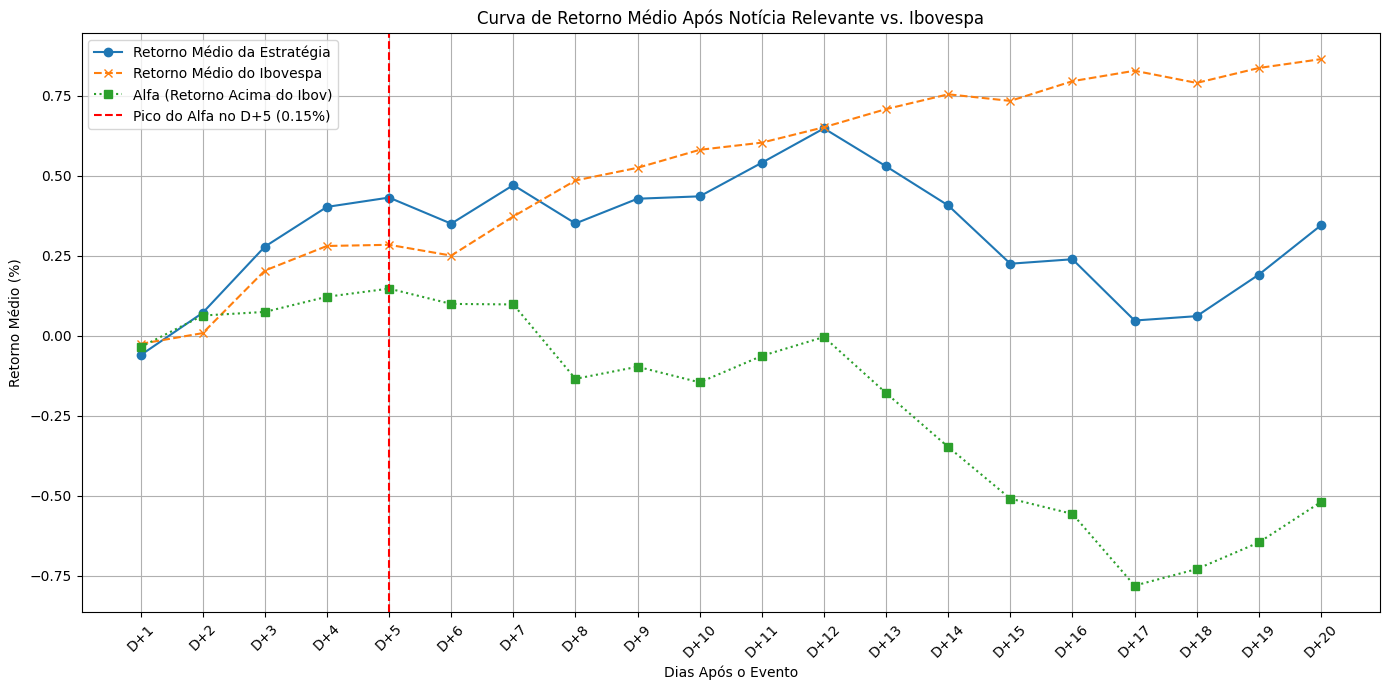

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from gnews import GNews
import json
import os
import google.generativeai as genai
from google.colab import userdata
import re

# Configurações do Pandas
pd.set_option('display.max_rows', None); pd.set_option('display.max_columns', None); pd.set_option('display.width', 2000); pd.set_option('display.max_colwidth', None)

# --------------------------------------------------------------------------
# ETAPA 1: CONFIGURAÇÃO DO ESTUDO DE EVENTOS
# --------------------------------------------------------------------------
try:
    GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
    genai.configure(api_key=GEMINI_API_KEY)
except Exception as e:
    print("ERRO: Não foi possível carregar a chave 'GEMINI_API_KEY'. Verifique se ela foi criada nos Secrets do Colab.")
    exit()

MODELO_GEMINI = genai.GenerativeModel('models/gemini-2.5-flash-lite')

# --- PARÂMETROS DE CONTROLE DE API (Mantidos conforme sua configuração) ---
RPM_LIMIT = 11
TOTAL_API_CALL_LIMIT = 700
SLEEP_TIME_SECONDS = 60 / RPM_LIMIT

data_inicio = '2015-01-01'
data_fim = '2024-12-31'
DIAS_DE_ANALISE = 20

universo_investimento = ['PETR4.SA', 'VALE3.SA', 'SUZB3.SA', 'AMBP3.SA', 'ELET3.SA', 'RAIZ4.SA']
mapa_tickers_para_nomes = {
    'PETR4.SA': 'Petrobras', 'VALE3.SA': 'Vale', 'SUZB3.SA': 'Suzano',
    'AMBP3.SA': 'Ambipar', 'ELET3.SA': 'Eletrobras', 'RAIZ4.SA': 'Raízen'
}
keywords_busca_ampla = ['sustentabilidade', 'ESG', 'crédito de carbono', 'meio ambiente', 'energia renovável']
NOME_ARQUIVO_CACHE = 'eventos_gemini_gnews_cache.json'

# --------------------------------------------------------------------------
# ETAPA 2: FUNÇÕES DE COLETA E CLASSIFICAÇÃO COM IA
# --------------------------------------------------------------------------
def buscar_dados_acoes(tickers, start, end):
    print(f"Baixando dados de preços de {start} a {end}...")
    try:
        # MUDANÇA: Adiciona o ticker do Ibovespa à lista de download
        tickers_com_ibov = tickers + ['^BVSP']
        dados = yf.download(tickers_com_ibov, start=start, end=end)
        dados.sort_index(inplace=True)
        if dados.empty:
            print("Nenhum dado de preço foi baixado."); return None
        print("Download de preços concluído.")
        return dados
    except Exception as e:
        print(f"Ocorreu um erro ao baixar os dados de preços: {e}"); return None

def classificar_manchete_com_gemini(manchete, api_counter):
    if api_counter['count'] >= api_counter['limit']:
        print("  - Limite total de chamadas de API atingido nesta execução. Parando a classificação.")
        return None
    prompt = f"""
    Analise a seguinte manchete de notícia. A manchete reporta um novo e concreto investimento, contrato, certificação, ou iniciativa positiva de uma empresa no setor de 'carbono verde', sustentabilidade ou descarbonização?
    Responda APENAS com 'SIM' ou 'NÃO'.
    Manchete: "{manchete}"
    """
    max_tentativas = 3
    for tentativa in range(max_tentativas):
        try:
            api_counter['count'] += 1
            print(f"  - Chamada à API #{api_counter['count']}/{api_counter['limit']}...")
            response = MODELO_GEMINI.generate_content(prompt)
            return "SIM" in response.text.strip().upper()
        except Exception as e:
            error_message = str(e); print(f"  - Erro na API do Gemini (tentativa {tentativa + 1}): {error_message}")
            if '429' in error_message and 'quota' in error_message:
                match = re.search(r"retry in (\d+\.\d+)s", error_message)
                if match:
                    tempo_espera = float(match.group(1)) + 1
                    print(f"  - Limite de RPM atingido. Aguardando {tempo_espera:.2f}s...")
                    time.sleep(tempo_espera); api_counter['count'] -= 1; continue
            time.sleep(5)
    print(f"  - Falha ao classificar após {max_tentativas} tentativas. Classificando como NÃO.")
    return False

def construir_cache_de_eventos(tickers_validos, nomes_mapa, start_str, end_str):
    print("\nIniciando 'Caça aos Sinais'...")
    eventos_encontrados = []; ultimo_ano_processado = 0
    if os.path.exists(NOME_ARQUIVO_CACHE):
        with open(NOME_ARQUIVO_CACHE, 'r', encoding='utf-8') as f:
            cache_antigo = json.load(f)
            eventos_encontrados = cache_antigo.get('eventos', [])
            ultimo_ano_processado = cache_antigo.get('metadata', {}).get('ultimo_ano_processado', 0)
        print(f"Progresso carregado. Continuando a partir de {ultimo_ano_processado + 1}.")
    api_counter = {'count': 0, 'limit': TOTAL_API_CALL_LIMIT}
    start_date = datetime.datetime.strptime(start_str, '%Y-%m-%d'); end_date = datetime.datetime.strptime(end_str, '%Y-%m-%d')
    ano_de_inicio = ultimo_ano_processado + 1 if ultimo_ano_processado > 0 else start_date.year
    for year in range(ano_de_inicio, end_date.year + 1):
        if api_counter['count'] >= api_counter['limit']: break
        print(f"\n===== PROCESSANDO ANO: {year} =====")
        google_news = GNews(language='pt', country='BR', start_date=datetime.date(year, 1, 1), end_date=datetime.date(year, 12, 31))
        for ticker in tickers_validos:
            if api_counter['count'] >= api_counter['limit']: break
            nome_empresa = nomes_mapa.get(ticker)
            if not nome_empresa: continue
            print(f"--- Buscando notícias para {nome_empresa} ---")
            query = f'"{nome_empresa}" AND ({ " OR ".join(keywords_busca_ampla) })'; noticias = google_news.get_news(query); time.sleep(1)
            if noticias:
                print(f"  -> {len(noticias)} notícias encontradas. Classificando...")
                for n in noticias:
                    if nome_empresa.lower() in n['title'].lower():
                        resultado = classificar_manchete_com_gemini(n['title'], api_counter)
                        if resultado is None: api_counter['count'] = api_counter['limit']; break
                        if resultado:
                            data_obj_str = datetime.datetime.strptime(n['published date'], '%a, %d %b %Y %H:%M:%S GMT').strftime('%Y-%m-%d')
                            eventos_encontrados.append({'Data': data_obj_str, 'Ticker': ticker, 'Manchete': n['title']})
                            print(f"  >>> SINAL ENCONTRADO: {data_obj_str} - {ticker}")
                        time.sleep(SLEEP_TIME_SECONDS)
        df_eventos = pd.DataFrame(eventos_encontrados); df_eventos.drop_duplicates(subset=['Data', 'Ticker'], inplace=True)
        eventos_unicos = df_eventos.to_dict('records')
        cache_conteudo = {'metadata': {'ultimo_ano_processado': year, 'data_fim': end_str}, 'eventos': eventos_unicos}
        with open(NOME_ARQUIVO_CACHE, 'w', encoding='utf-8') as f: json.dump(cache_conteudo, f, ensure_ascii=False, indent=4)
        print(f"Progresso salvo. {len(eventos_unicos)} eventos totais no cache.")
    if api_counter['count'] < api_counter['limit']: print("\nBusca concluída para todo o período!")
    else: print("\nLimite de API atingido. Rode novamente no dia seguinte para continuar.")
    return eventos_unicos

# --------------------------------------------------------------------------
# ETAPA 3: FUNÇÃO DE ANÁLISE DE EVENTOS
# --------------------------------------------------------------------------
def executar_estudo_de_eventos(eventos, dados_acoes):
    print("\nIniciando estudo de eventos...")
    resultados = []
    for evento in eventos:
        ticker = evento['Ticker']
        if ticker not in dados_acoes['Open'].columns: continue
        data_evento = pd.to_datetime(evento['Data'])
        dias_de_negociacao = dados_acoes.index[dados_acoes.index > data_evento]
        if len(dias_de_negociacao) < DIAS_DE_ANALISE: continue
        data_compra = dias_de_negociacao[0]
        # MUDANÇA: Pega o preço de entrada da ação E do Ibovespa
        preco_entrada_ativo = dados_acoes.loc[data_compra, ('Open', ticker)]
        preco_entrada_ibov = dados_acoes.loc[data_compra, ('Open', '^BVSP')]
        if pd.isna(preco_entrada_ativo) or preco_entrada_ativo == 0 or pd.isna(preco_entrada_ibov) or preco_entrada_ibov == 0: continue
        dias_analise = dias_de_negociacao[0:DIAS_DE_ANALISE]
        resultado_linha = {'Data_Evento': data_evento.date(), 'Ticker': ticker, 'Manchete': evento['Manchete']}
        for i, dia in enumerate(dias_analise):
            preco_fechamento_ativo = dados_acoes.loc[dia, ('Close', ticker)]
            preco_fechamento_ibov = dados_acoes.loc[dia, ('Close', '^BVSP')]
            retorno_ativo = (preco_fechamento_ativo / preco_entrada_ativo) - 1
            retorno_ibov = (preco_fechamento_ibov / preco_entrada_ibov) - 1
            resultado_linha[f'D+{i+1}_Ativo'] = retorno_ativo
            resultado_linha[f'D+{i+1}_Ibov'] = retorno_ibov
        resultados.append(resultado_linha)
    return pd.DataFrame(resultados)

# --------------------------------------------------------------------------
# ETAPA 4: ORQUESTRAÇÃO E ANÁLISE FINAL
# --------------------------------------------------------------------------
if os.path.exists(NOME_ARQUIVO_CACHE):
    with open(NOME_ARQUIVO_CACHE, 'r', encoding='utf-8') as f: cache_data = json.load(f)
    if cache_data.get('metadata', {}).get('ultimo_ano_processado', 0) >= datetime.datetime.strptime(data_fim, '%Y-%m-%d').year:
        print(f"Cache encontrado e completo. Carregando eventos locais.")
        eventos = cache_data.get('eventos', [])
    else: eventos = construir_cache_de_eventos(list(mapa_tickers_para_nomes.keys()), mapa_tickers_para_nomes, data_inicio, data_fim)
else: eventos = construir_cache_de_eventos(list(mapa_tickers_para_nomes.keys()), mapa_tickers_para_nomes, data_inicio, data_fim)

if not eventos:
    print("\nNenhum evento relevante foi encontrado. A análise não pode continuar.")
else:
    dados_acoes_total = buscar_dados_acoes(universo_investimento, data_inicio, data_fim)
    if dados_acoes_total is not None:
        df_resultados = executar_estudo_de_eventos(eventos, dados_acoes_total)
        if not df_resultados.empty:
            # MUDANÇA: Calcula a média para a estratégia, para o Ibov e para o Alfa
            df_retornos_ativo = df_resultados.filter(regex=r'_Ativo$')
            df_retornos_ibov = df_resultados.filter(regex=r'_Ibov$')
            # Renomeia colunas para facilitar o cálculo
            df_retornos_ativo.columns = [f'D+{i+1}' for i in range(DIAS_DE_ANALISE)]
            df_retornos_ibov.columns = [f'D+{i+1}' for i in range(DIAS_DE_ANALISE)]

            retorno_medio_ativo = df_retornos_ativo.mean()
            retorno_medio_ibov = df_retornos_ibov.mean()
            retorno_alpha = retorno_medio_ativo - retorno_medio_ibov # Alfa = Retorno do Ativo - Retorno do Mercado

            dia_do_pico_alpha = retorno_alpha.idxmax()
            valor_pico_alpha = retorno_alpha.max()

            print("\n--- ANÁLISE DE RESULTADOS ---")
            print(f"Total de eventos analisados: {len(df_resultados)}")
            print(f"Pico de 'Alfa' (retorno acima do Ibovespa) ocorre no: {dia_do_pico_alpha}")
            print(f"Alfa médio no pico: {valor_pico_alpha:.2%}")

            nome_arquivo_excel = 'Analise_de_Eventos_com_Ibov.xlsx'
            with pd.ExcelWriter(nome_arquivo_excel, engine='openpyxl') as writer:
                df_resultados.to_excel(writer, sheet_name='Resultados_por_Evento', index=False)
                retorno_medio_ativo.to_frame(name='Retorno_Medio_Ativo').to_excel(writer, sheet_name='Resumo_Medio_Ativo')
                retorno_medio_ibov.to_frame(name='Retorno_Medio_Ibov').to_excel(writer, sheet_name='Resumo_Medio_Ibov')
                retorno_alpha.to_frame(name='Alfa_Medio').to_excel(writer, sheet_name='Resumo_Alfa')
            print(f"\nResultados detalhados exportados para o arquivo '{nome_arquivo_excel}'")

            # MUDANÇA: Gráfico agora tem 3 linhas
            plt.figure(figsize=(14, 7))
            plt.plot(retorno_medio_ativo.index, retorno_medio_ativo.values * 100, marker='o', linestyle='-', label='Retorno Médio da Estratégia')
            plt.plot(retorno_medio_ibov.index, retorno_medio_ibov.values * 100, marker='x', linestyle='--', label='Retorno Médio do Ibovespa')
            plt.plot(retorno_alpha.index, retorno_alpha.values * 100, marker='s', linestyle=':', label='Alfa (Retorno Acima do Ibov)')
            plt.title('Curva de Retorno Médio Após Notícia Relevante vs. Ibovespa')
            plt.xlabel('Dias Após o Evento'); plt.ylabel('Retorno Médio (%)')
            plt.axvline(x=dia_do_pico_alpha, color='r', linestyle='--', label=f'Pico do Alfa no {dia_do_pico_alpha} ({valor_pico_alpha:.2%})')
            plt.grid(True); plt.legend(); plt.xticks(rotation=45); plt.tight_layout(); plt.show()
        else: print("\nNenhuma operação pôde ser simulada com os eventos encontrados.")

# primeiro codigo sem vies overfitting
O vies Survivorship Bias

Infelizmente, não podemos eliminar este viés usando as ferramentas atuais (yfinance, GNews).

A Causa: O viés vem da sua lista universo_investimento. Ela é fixa e foi definida por você em 2024.

A Solução Real (Inviável aqui): Para eliminar 100% este viés, precisaríamos de um banco de dados profissional (ex: Economatica, Bloomberg, Refinitiv) que nos dissesse, para cada ano do estudo (2015, 2016, 2017...), quais eram todas as ações listadas na bolsa, incluindo as que faliram ou foram deslistadas.


Iniciando 'Caça aos Sinais'...

===== PROCESSANDO ANO: 2015 =====
--- Buscando notícias para Petrobras (2015) ---
  -> 5 notícias encontradas. Classificando...
--- Buscando notícias para Vale (2015) ---
  -> 33 notícias encontradas. Classificando...
  - Chamada à API #1/700...
  - Chamada à API #2/700...
  - Chamada à API #3/700...
--- Buscando notícias para Suzano (2015) ---
  -> 2 notícias encontradas. Classificando...
  - Chamada à API #4/700...
  >>> SINAL ENCONTRADO: 2015-05-18 - SUZB3.SA
--- Buscando notícias para Ambipar (2015) ---
--- Buscando notícias para Eletrobras (2015) ---
  -> 1 notícias encontradas. Classificando...
--- Buscando notícias para Raízen (2015) ---
  -> 1 notícias encontradas. Classificando...
  - Chamada à API #5/700...
  >>> SINAL ENCONTRADO: 2015-12-21 - RAIZ4.SA
Progresso salvo. 2 eventos totais no cache.

===== PROCESSANDO ANO: 2016 =====
--- Buscando notícias para Petrobras (2016) ---
  -> 3 notícias encontradas. Classificando...
--- Buscando notícias

/tmp/ipython-input-2998325579.py:61: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dados = yf.download(tickers_com_ibov, start=start, end=end)
[*********************100%***********************]  7 of 7 completed


Download de preços concluído.

Dividindo eventos em Treino (até 2021-12-31) e Teste (após 2021-12-31)...
Total de eventos encontrados: 194
Eventos de Treino (In-Sample): 37
Eventos de Teste (Out-of-Sample): 157

Iniciando estudo de eventos para 37 eventos...
Estudo de eventos concluído. 30 simulações válidas geradas.

Iniciando estudo de eventos para 157 eventos...
Estudo de eventos concluído. 150 simulações válidas geradas.

--- ANÁLISE DE ROBUSTEZ (TREINO vs TESTE) ---

Analisando Período de Treino (In-Sample)...
Pico de Alfa (Treino) ocorre no: D+18
Alfa médio no pico (Treino): 8.40%

Analisando Período de Teste (Out-of-Sample)...
Alfa médio no período de Teste (no dia do pico do Treino, D+18): 0.02%

--- RESUMO COMPARATIVO (Alfa Médio no dia do Pico do Treino) ---
Período    | Alfa Médio |
-------------------------
Treino     |     8.40% |
Teste      |     0.02% |

Resultados detalhados de Treino/Teste exportados para 'Analise_de_Eventos_TREINO_TESTE.xlsx'


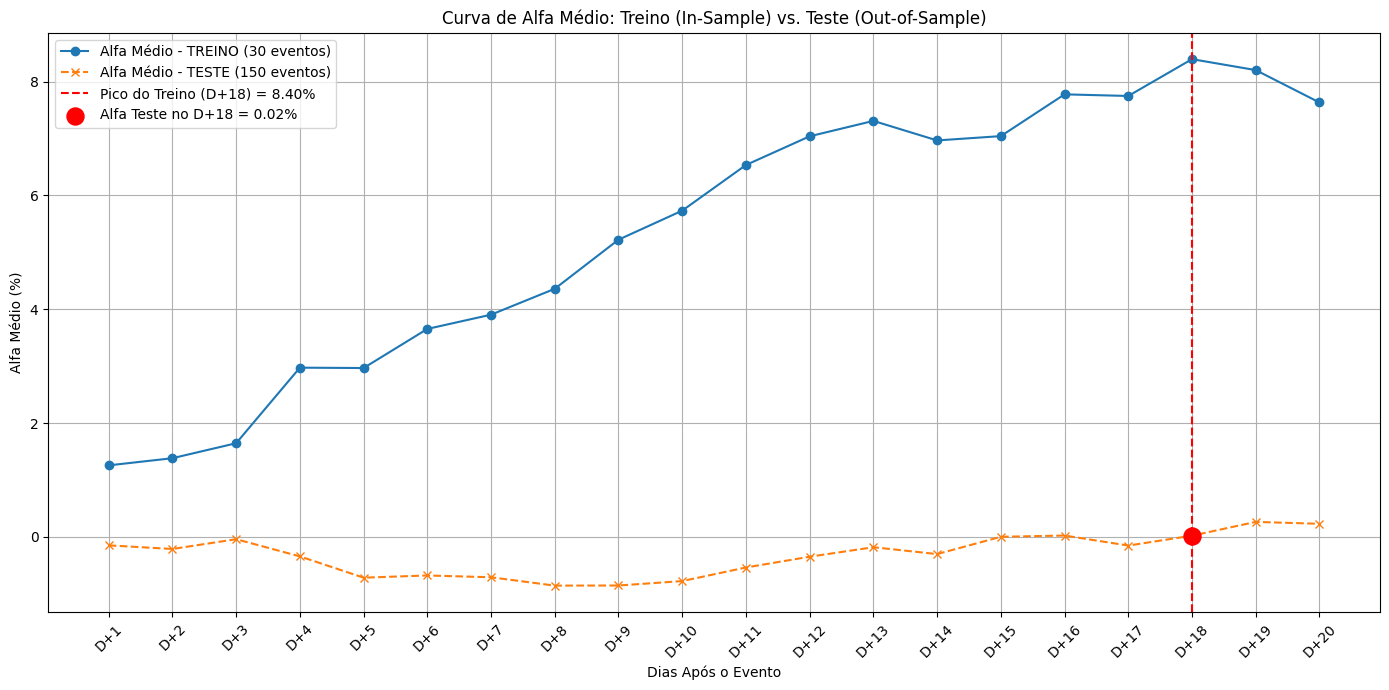

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from gnews import GNews
import json
import os
import google.generativeai as genai
from google.colab import userdata
import re

# Configurações do Pandas
pd.set_option('display.max_rows', None); pd.set_option('display.max_columns', None); pd.set_option('display.width', 2000); pd.set_option('display.max_colwidth', None)

# --------------------------------------------------------------------------
# ETAPA 1: CONFIGURAÇÃO DO ESTUDO DE EVENTOS
# --------------------------------------------------------------------------
try:
    # (Seu código de API Key do Gemini permanece o mesmo)
    GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
    genai.configure(api_key=GEMINI_API_KEY)
except Exception as e:
    print("ERRO: Não foi possível carregar a chave 'GEMINI_API_KEY'. Verifique se ela foi criada nos Secrets do Colab.")
    exit()

MODELO_GEMINI = genai.GenerativeModel('models/gemini-2.5-flash-lite')

# --- PARÂMETROS DE CONTROLE DE API ---
RPM_LIMIT = 11
TOTAL_API_CALL_LIMIT = 700
SLEEP_TIME_SECONDS = 60 / RPM_LIMIT

# --- PARÂMETROS DO ESTUDO ---
data_inicio = '2015-01-01'
data_fim = '2024-12-31'
DIAS_DE_ANALISE = 20

# *** NOVA MUDANÇA: DATA DE CORTE PARA TREINO/TESTE ***
# Vamos "descobrir" a regra até essa data, e "validar" a regra depois dela.
DATA_CORTE_TREINO_TESTE = '2021-12-31'

universo_investimento = ['PETR4.SA', 'VALE3.SA', 'SUZB3.SA', 'AMBP3.SA', 'ELET3.SA', 'RAIZ4.SA']
mapa_tickers_para_nomes = {
    'PETR4.SA': 'Petrobras', 'VALE3.SA': 'Vale', 'SUZB3.SA': 'Suzano',
    'AMBP3.SA': 'Ambipar', 'ELET3.SA': 'Eletrobras', 'RAIZ4.SA': 'Raízen'
}
keywords_busca_ampla = ['sustentabilidade', 'ESG', 'crédito de carbono', 'meio ambiente', 'energia renovável']
NOME_ARQUIVO_CACHE = 'eventos_gemini_gnews_cache.json'


# --------------------------------------------------------------------------
# ETAPA 2: FUNÇÕES DE COLETA E CLASSIFICAÇÃO COM IA
# (Nenhuma mudança necessária aqui. As funções são as mesmas)
# --------------------------------------------------------------------------
def buscar_dados_acoes(tickers, start, end):
    print(f"Baixando dados de preços de {start} a {end}...")
    try:
        tickers_com_ibov = tickers + ['^BVSP']
        dados = yf.download(tickers_com_ibov, start=start, end=end)
        dados.sort_index(inplace=True)
        if dados.empty:
            print("Nenhum dado de preço foi baixado."); return None
        print("Download de preços concluído.")
        return dados
    except Exception as e:
        print(f"Ocorreu um erro ao baixar os dados de preços: {e}"); return None

def classificar_manchete_com_gemini(manchete, api_counter):
    if api_counter['count'] >= api_counter['limit']:
        print("  - Limite total de chamadas de API atingido nesta execução. Parando a classificação.")
        return None
    prompt = f"""
    Analise a seguinte manchete de notícia. A manchete reporta um novo e concreto investimento, contrato, certificação, ou iniciativa positiva de uma empresa no setor de 'carbono verde', sustentabilidade ou descarbonização?
    Responda APENAS com 'SIM' ou 'NÃO'.
    Manchete: "{manchete}"
    """
    max_tentativas = 3
    for tentativa in range(max_tentativas):
        try:
            api_counter['count'] += 1
            print(f"  - Chamada à API #{api_counter['count']}/{api_counter['limit']}...")
            response = MODELO_GEMINI.generate_content(prompt)
            # Adiciona verificação de segurança
            if response.candidates and response.candidates[0].content.parts:
                return "SIM" in response.text.strip().upper()
            else:
                 print("  - Resposta da API vazia ou bloqueada. Classificando como NÃO.")
                 return False
        except Exception as e:
            error_message = str(e); print(f"  - Erro na API do Gemini (tentativa {tentativa + 1}): {error_message}")
            if '429' in error_message: # Trata erro de limite de requisições
                 # Tenta extrair tempo de espera, se não, usa um padrão
                 match = re.search(r"retry in (\d+\.\d+)s", error_message)
                 tempo_espera_sugerido = float(match.group(1)) + 1 if match else 10.0
                 print(f"  - Limite de RPM/Quota atingido. Aguardando {tempo_espera_sugerido:.2f}s...")
                 time.sleep(tempo_espera_sugerido)
                 api_counter['count'] -= 1 # Decrementa para tentar novamente
                 continue # Pula para a próxima tentativa
            time.sleep(5) # Espera padrão para outros erros
    print(f"  - Falha ao classificar após {max_tentativas} tentativas. Classificando como NÃO.")
    return False


def construir_cache_de_eventos(tickers_validos, nomes_mapa, start_str, end_str):
    print("\nIniciando 'Caça aos Sinais'...")
    eventos_encontrados = []; ultimo_ano_processado = 0
    if os.path.exists(NOME_ARQUIVO_CACHE):
        with open(NOME_ARQUIVO_CACHE, 'r', encoding='utf-8') as f:
            cache_antigo = json.load(f)
            eventos_encontrados = cache_antigo.get('eventos', [])
            # Verifica se o cache antigo cobre todo o período desejado
            meta_cache = cache_antigo.get('metadata', {})
            if meta_cache.get('data_fim_cache') == end_str:
                 print(f"Cache encontrado e completo para o período até {end_str}. Carregando eventos locais.")
                 return eventos_encontrados # Retorna direto se o cache está completo

            ultimo_ano_processado = meta_cache.get('ultimo_ano_processado', 0)
            print(f"Progresso carregado. Continuando a partir de {ultimo_ano_processado + 1}.")

    api_counter = {'count': 0, 'limit': TOTAL_API_CALL_LIMIT}
    start_date = datetime.datetime.strptime(start_str, '%Y-%m-%d'); end_date = datetime.datetime.strptime(end_str, '%Y-%m-%d')

    # Garante que começamos do ano certo
    ano_de_inicio = ultimo_ano_processado + 1 if ultimo_ano_processado > 0 and ultimo_ano_processado >= start_date.year else start_date.year

    for year in range(ano_de_inicio, end_date.year + 1):
        if api_counter['count'] >= api_counter['limit']: break
        print(f"\n===== PROCESSANDO ANO: {year} =====")

        # Define as datas de início e fim do ano, respeitando os limites globais
        start_date_year = datetime.date(year, 1, 1)
        end_date_year = datetime.date(year, 12, 31)

        # Ajusta para os limites globais do estudo
        if year == start_date.year:
            start_date_year = start_date.date()
        if year == end_date.year:
            end_date_year = end_date.date()

        google_news = GNews(language='pt', country='BR', start_date=start_date_year, end_date=end_date_year)

        for ticker in tickers_validos:
            if api_counter['count'] >= api_counter['limit']: break
            nome_empresa = nomes_mapa.get(ticker)
            if not nome_empresa: continue
            print(f"--- Buscando notícias para {nome_empresa} ({year}) ---")

            # Tenta a busca
            try:
                query = f'"{nome_empresa}" AND ({ " OR ".join(keywords_busca_ampla) })';
                noticias = google_news.get_news(query);
                time.sleep(1) # Pausa básica para não sobrecarregar a GNews
            except Exception as e:
                print(f"  - Erro ao buscar no GNews (pode ser um bloqueio temporário): {e}. Pulando {nome_empresa} para este ano.")
                noticias = [] # Continua com uma lista vazia
                time.sleep(10) # Pausa mais longa se der erro

            if noticias:
                print(f"  -> {len(noticias)} notícias encontradas. Classificando...")
                for n in noticias:
                    # Filtra se o nome da empresa está no título (reduz falso-positivo)
                    if nome_empresa.lower() in n['title'].lower():
                        resultado = classificar_manchete_com_gemini(n['title'], api_counter)
                        if resultado is None: api_counter['count'] = api_counter['limit']; break # Para tudo se atingiu o limite

                        if resultado:
                            # Formata a data
                            data_obj_str = datetime.datetime.strptime(n['published date'], '%a, %d %b %Y %H:%M:%S GMT').strftime('%Y-%m-%d')
                            eventos_encontrados.append({'Data': data_obj_str, 'Ticker': ticker, 'Manchete': n['title']})
                            print(f"  >>> SINAL ENCONTRADO: {data_obj_str} - {ticker}")

                        # Pausa entre chamadas da API Gemini
                        time.sleep(SLEEP_TIME_SECONDS)

            # Pausa entre diferentes empresas
            time.sleep(1)

        # Salva o progresso ao final de cada ano
        df_eventos_parcial = pd.DataFrame(eventos_encontrados);
        df_eventos_parcial.drop_duplicates(subset=['Data', 'Ticker'], inplace=True)
        eventos_unicos = df_eventos_parcial.to_dict('records')

        # Atualiza o metadata
        meta_data_cache = {
            'ultimo_ano_processado': year,
            'data_fim_cache': end_str if year == end_date.year else f"{year}-12-31", # Salva até onde foi processado
            'total_eventos': len(eventos_unicos)
        }

        cache_conteudo = {'metadata': meta_data_cache, 'eventos': eventos_unicos}
        with open(NOME_ARQUIVO_CACHE, 'w', encoding='utf-8') as f:
            json.dump(cache_conteudo, f, ensure_ascii=False, indent=4)
        print(f"Progresso salvo. {len(eventos_unicos)} eventos totais no cache.")

    if api_counter['count'] < api_counter['limit']:
        print(f"\nBusca concluída para todo o período (até {end_str})!")
    else:
        print("\nLimite de API atingido. Rode novamente no dia seguinte para continuar.")

    # Retorna a lista final de eventos únicos
    df_final = pd.DataFrame(eventos_encontrados)
    df_final.drop_duplicates(subset=['Data', 'Ticker'], inplace=True)
    return df_final.to_dict('records')


# --------------------------------------------------------------------------
# ETAPA 3: FUNÇÃO DE ANÁLISE DE EVENTOS
# (Nenhuma mudança necessária aqui. A função é a mesma)
# --------------------------------------------------------------------------
def executar_estudo_de_eventos(eventos, dados_acoes):
    print(f"\nIniciando estudo de eventos para {len(eventos)} eventos...")
    resultados = []

    # Garante que os índices de dados_acoes são Timestamps
    dados_acoes.index = pd.to_datetime(dados_acoes.index)

    for evento in eventos:
        ticker = evento['Ticker']
        if ticker not in dados_acoes['Open'].columns:
            print(f"Aviso: Ticker {ticker} do evento não encontrado nos dados de ações. Pulando.")
            continue

        try:
            data_evento = pd.to_datetime(evento['Data'])
        except Exception as e:
            print(f"Aviso: Data inválida no evento {evento}. Erro: {e}. Pulando.")
            continue

        # Encontra dias de negociação *posteriores* à data do evento
        dias_de_negociacao = dados_acoes.index[dados_acoes.index > data_evento]

        # Validação se há dias suficientes para a análise
        if len(dias_de_negociacao) < DIAS_DE_ANALISE:
            # print(f"Aviso: Evento em {data_evento.date()} para {ticker} não possui {DIAS_DE_ANALISE} dias de negociação subsequentes. Pulando.")
            continue

        data_compra = dias_de_negociacao[0]

        # Pega o preço de entrada (Abertura do dia D+1)
        preco_entrada_ativo = dados_acoes.loc[data_compra, ('Open', ticker)]
        preco_entrada_ibov = dados_acoes.loc[data_compra, ('Open', '^BVSP')]

        # Validação de preços
        if pd.isna(preco_entrada_ativo) or preco_entrada_ativo == 0 or pd.isna(preco_entrada_ibov) or preco_entrada_ibov == 0:
            # print(f"Aviso: Preço de entrada inválido em {data_compra.date()} para {ticker}. Pulando.")
            continue

        # Pega os N dias de análise (do D+1 ao D+N)
        dias_analise = dias_de_negociacao[0:DIAS_DE_ANALISE]

        resultado_linha = {'Data_Evento': data_evento.date(), 'Ticker': ticker, 'Manchete': evento['Manchete']}

        # Calcula os retornos dia a dia (usando o Fechamento)
        for i, dia_fechamento in enumerate(dias_analise):
            preco_fechamento_ativo = dados_acoes.loc[dia_fechamento, ('Close', ticker)]
            preco_fechamento_ibov = dados_acoes.loc[dia_fechamento, ('Close', '^BVSP')]

            # Se algum preço de fechamento for nulo, usa o último válido (Forward Fill)
            # Isso é comum em dados diários
            if pd.isna(preco_fechamento_ativo):
                preco_fechamento_ativo = dados_acoes.loc[:dia_fechamento, ('Close', ticker)].ffill().iloc[-1]
            if pd.isna(preco_fechamento_ibov):
                preco_fechamento_ibov = dados_acoes.loc[:dia_fechamento, ('Close', '^BVSP')].ffill().iloc[-1]

            retorno_ativo = (preco_fechamento_ativo / preco_entrada_ativo) - 1
            retorno_ibov = (preco_fechamento_ibov / preco_entrada_ibov) - 1

            resultado_linha[f'D+{i+1}_Ativo'] = retorno_ativo
            resultado_linha[f'D+{i+1}_Ibov'] = retorno_ibov

        resultados.append(resultado_linha)

    print(f"Estudo de eventos concluído. {len(resultados)} simulações válidas geradas.")
    return pd.DataFrame(resultados)

# --------------------------------------------------------------------------
# ETAPA 4: ORQUESTRAÇÃO E DIVISÃO TREINO/TESTE (MODIFICADA)
# --------------------------------------------------------------------------

# 1. Carrega ou constrói o cache de eventos para o PERÍODO COMPLETO
# (A função construir_cache_de_eventos foi modificada para ser mais inteligente e não rodar se o cache estiver completo)
eventos_total = construir_cache_de_eventos(list(mapa_tickers_para_nomes.keys()), mapa_tickers_para_nomes, data_inicio, data_fim)

if not eventos_total:
    print("\nNenhum evento relevante foi encontrado. A análise não pode continuar.")
else:
    # 2. Baixa os dados de ações para o PERÍODO COMPLETO
    dados_acoes_total = buscar_dados_acoes(universo_investimento, data_inicio, data_fim)

    if dados_acoes_total is not None and not dados_acoes_total.empty:

        # 3. *** A MÁGICA ACONTECE AQUI: DIVISÃO DOS EVENTOS ***
        # Divide a lista de eventos em Treino (In-Sample) e Teste (Out-of-Sample)

        print(f"\nDividindo eventos em Treino (até {DATA_CORTE_TREINO_TESTE}) e Teste (após {DATA_CORTE_TREINO_TESTE})...")

        eventos_treino = [e for e in eventos_total if e['Data'] <= DATA_CORTE_TREINO_TESTE]
        eventos_teste = [e for e in eventos_total if e['Data'] > DATA_CORTE_TREINO_TESTE]

        print(f"Total de eventos encontrados: {len(eventos_total)}")
        print(f"Eventos de Treino (In-Sample): {len(eventos_treino)}")
        print(f"Eventos de Teste (Out-of-Sample): {len(eventos_teste)}")

        # 4. Executa o estudo de eventos SEPARADAMENTE para cada conjunto
        df_resultados_treino = pd.DataFrame()
        df_resultados_teste = pd.DataFrame()

        if eventos_treino:
            df_resultados_treino = executar_estudo_de_eventos(eventos_treino, dados_acoes_total)
        if eventos_teste:
            df_resultados_teste = executar_estudo_de_eventos(eventos_teste, dados_acoes_total)

# --------------------------------------------------------------------------
# ETAPA 5: ANÁLISE DE ROBUSTEZ (TREINO vs TESTE) - (NOVA)
# --------------------------------------------------------------------------
        print("\n--- ANÁLISE DE ROBUSTEZ (TREINO vs TESTE) ---")

        if df_resultados_treino.empty:
            print("Nenhum resultado válido no período de Treino. A análise não pode continuar.")
        else:
            # 5.1. Analisa o período de TREINO para "Descobrir" a Regra
            print("\nAnalisando Período de Treino (In-Sample)...")
            df_retornos_ativo_treino = df_resultados_treino.filter(regex=r'_Ativo$')
            df_retornos_ibov_treino = df_resultados_treino.filter(regex=r'_Ibov$')

            df_retornos_ativo_treino.columns = [f'D+{i+1}' for i in range(DIAS_DE_ANALISE)]
            df_retornos_ibov_treino.columns = [f'D+{i+1}' for i in range(DIAS_DE_ANALISE)]

            retorno_medio_ativo_treino = df_retornos_ativo_treino.mean()
            retorno_medio_ibov_treino = df_retornos_ibov_treino.mean()
            retorno_alpha_treino = retorno_medio_ativo_treino - retorno_medio_ibov_treino

            dia_do_pico_alpha_treino = retorno_alpha_treino.idxmax()
            valor_pico_alpha_treino = retorno_alpha_treino.max()

            print(f"Pico de Alfa (Treino) ocorre no: {dia_do_pico_alpha_treino}")
            print(f"Alfa médio no pico (Treino): {valor_pico_alpha_treino:.2%}")


            # 5.2. Analisa o período de TESTE (Aplicando a "Regra" descoberta no Treino)
            print("\nAnalisando Período de Teste (Out-of-Sample)...")
            df_retornos_ativo_teste = df_resultados_teste.filter(regex=r'_Ativo$')
            df_retornos_ibov_teste = df_resultados_teste.filter(regex=r'_Ibov$')

            df_retornos_ativo_teste.columns = [f'D+{i+1}' for i in range(DIAS_DE_ANALISE)]
            df_retornos_ibov_teste.columns = [f'D+{i+1}' for i in range(DIAS_DE_ANALISE)]

            retorno_medio_ativo_teste = df_retornos_ativo_teste.mean()
            retorno_medio_ibov_teste = df_retornos_ibov_teste.mean()
            retorno_alpha_teste = retorno_medio_ativo_teste - retorno_medio_ibov_teste

            # Calcula o Alfa do período de TESTE *no mesmo dia do pico do período de TREINO*
            alpha_teste_no_pico_treino = retorno_alpha_teste.get(dia_do_pico_alpha_treino, np.nan) # Usa .get para evitar erro se o dia não existir no teste
            if pd.isna(alpha_teste_no_pico_treino):
                 print(f"Aviso: O dia do pico do treino ({dia_do_pico_alpha_treino}) não foi encontrado nos resultados do teste.")
                 alpha_teste_no_pico_treino = 0 # Define como zero ou outro valor padrão se o dia não existir

            print(f"Alfa médio no período de Teste (no dia do pico do Treino, {dia_do_pico_alpha_treino}): {alpha_teste_no_pico_treino:.2%}")


            # 5.3. Apresenta o Resumo Comparativo
            print("\n--- RESUMO COMPARATIVO (Alfa Médio no dia do Pico do Treino) ---")
            print(f"{'Período':<10} | {'Alfa Médio':<10} |")
            print("-" * 25)
            print(f"{'Treino':<10} | {valor_pico_alpha_treino:>9.2%} |")
            print(f"{'Teste':<10} | {alpha_teste_no_pico_treino:>9.2%} |")

            # Cria um DataFrame para o resumo para salvar no Excel
            df_resumo_plot = pd.DataFrame({
                'Periodo': ['Treino', 'Teste'],
                'Alfa_Medio_Pico_Treino': [valor_pico_alpha_treino, alpha_teste_no_pico_treino]
            })


            # 5.4. Salva tudo em Excel
            nome_arquivo_excel = 'Analise_de_Eventos_TREINO_TESTE.xlsx'
            with pd.ExcelWriter(nome_arquivo_excel, engine='openpyxl') as writer:
                # Dados brutos
                df_resultados_treino.to_excel(writer, sheet_name='Eventos_Treino_Raw', index=False)
                if not df_resultados_teste.empty: # Salva o teste apenas se houver resultados
                    df_resultados_teste.to_excel(writer, sheet_name='Eventos_Teste_Raw', index=False)

                # Resumos
                df_resumo_plot.to_excel(writer, sheet_name='Resumo_Treino_vs_Teste', index=False) # Não precisa de index no resumo

                # Resumos médios separados
                retorno_medio_ativo_treino.to_frame(name='Retorno_Medio_Ativo_Treino').to_excel(writer, sheet_name='Medias_Treino')
                retorno_medio_ibov_treino.to_frame(name='Retorno_Medio_Ibov_Treino').to_excel(writer, sheet_name='Medias_Treino', startcol=3)
                retorno_alpha_treino.to_frame(name='Alfa_Medio_Treino').to_excel(writer, sheet_name='Medias_Treino', startcol=6)

                if not retorno_medio_ativo_teste.empty: # Salva as médias do teste apenas se houver resultados
                    retorno_medio_ativo_teste.to_frame(name='Retorno_Medio_Ativo_Teste').to_excel(writer, sheet_name='Medias_Teste')
                    retorno_medio_ibov_teste.to_frame(name='Retorno_Medio_Ibov_Teste').to_excel(writer, sheet_name='Medias_Teste', startcol=3)
                    retorno_alpha_teste.to_frame(name='Alfa_Medio_Teste').to_excel(writer, sheet_name='Medias_Teste', startcol=6)


            print(f"\nResultados detalhados de Treino/Teste exportados para '{nome_arquivo_excel}'")

            # 5.5. Gera o Gráfico Comparativo
            plt.figure(figsize=(14, 7))

            # Linhas do Treino
            plt.plot(retorno_alpha_treino.index, retorno_alpha_treino.values * 100,
                     marker='o', linestyle='-', label=f'Alfa Médio - TREINO ({len(df_resultados_treino)} eventos)')

            # Linhas do Teste (se existirem)
            if not retorno_alpha_teste.empty:
                plt.plot(retorno_alpha_teste.index, retorno_alpha_teste.values * 100,
                         marker='x', linestyle='--', label=f'Alfa Médio - TESTE ({len(df_resultados_teste)} eventos)')

            plt.title('Curva de Alfa Médio: Treino (In-Sample) vs. Teste (Out-of-Sample)')
            plt.xlabel('Dias Após o Evento'); plt.ylabel('Alfa Médio (%)')

            # Marca o pico do TREINO
            plt.axvline(x=dia_do_pico_alpha_treino, color='r', linestyle='--',
                        label=f'Pico do Treino ({dia_do_pico_alpha_treino}) = {valor_pico_alpha_treino:.2%}')

            # Marca o Alfa do TESTE no mesmo dia do pico do TREINO
            if not retorno_alpha_teste.empty:
                plt.scatter(dia_do_pico_alpha_treino, alpha_teste_no_pico_treino * 100,
                            s=150, color='red', zorder=5,
                            label=f'Alfa Teste no {dia_do_pico_alpha_treino} = {alpha_teste_no_pico_treino:.2%}')

            plt.grid(True); plt.legend(); plt.xticks(rotation=45); plt.tight_layout(); plt.show()

    else:
        print("\nDownload dos dados de ações falhou. A análise não pode continuar.")

Viés de Sobrevivência: Não podemos corrigir com yfinance, pois não temos a lista histórica de empresas que faliram.

Viés de Fonte de Mídia: Não podemos corrigir, pois dependemos do GNews.

Viés de Frequência: Não podemos corrigir, pois usamos dados diários.



---


O que NÓS PODEMOS FAZER é:

Minimizar o Viés de Seleção: Tornando nossa hipótese (o prompt e as keywords) muito mais específica e forte.

Eliminar o Viés de Agrupamento: Adicionando uma "janela de blackout" para que os eventos não se sobreponham.


Iniciando 'Caça aos Sinais' (V3 - Universo Expandido)...

===== PROCESSANDO ANO: 2015 =====
--- Buscando notícias para Petrobras (2015) ---
--- Buscando notícias para Vale (2015) ---
--- Buscando notícias para Suzano (2015) ---
--- Buscando notícias para Ambipar (2015) ---
--- Buscando notícias para Eletrobras (2015) ---
  -> 2 notícias encontradas. Classificando...
--- Buscando notícias para Raízen (2015) ---
--- Buscando notícias para Weg (2015) ---
--- Buscando notícias para Natura (2015) ---
--- Buscando notícias para Magazine Luiza (2015) ---
--- Buscando notícias para Lojas Renner (2015) ---
  -> 1 notícias encontradas. Classificando...
--- Buscando notícias para Klabin (2015) ---
--- Buscando notícias para JBS (2015) ---
--- Buscando notícias para Marfrig (2015) ---
--- Buscando notícias para Minerva (2015) ---
--- Buscando notícias para Sabesp (2015) ---
--- Buscando notícias para Equatorial (2015) ---
  -> 3 notícias encontradas. Classificando...
  - Chamada à API #1/900...
-

/tmp/ipython-input-1455176435.py:84: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dados = yf.download(tickers_com_ibov, start=start, end=end)
[*********************100%***********************]  22 of 22 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['JBSS3.SA']: YFTzMissingError('possibly delisted; no timezone found')


Download de preços concluído.

Dividindo eventos em Treino (até 2021-12-31) e Teste (após 2021-12-31)...
Total de eventos V3 encontrados: 4
Eventos de Treino (In-Sample): 1
Eventos de Teste (Out-of-Sample): 3

Iniciando estudo de eventos para 1 eventos (com Blackout)...
Estudo de eventos (Blackout) concluído. 1 simulações válidas geradas.

Iniciando estudo de eventos para 3 eventos (com Blackout)...
Estudo de eventos (Blackout) concluído. 3 simulações válidas geradas.

--- ANÁLISE DE ROBUSTEZ (TREINO vs TESTE) V3 ---

Analisando Período de Treino (In-Sample)...
Pico de Alfa (Treino) ocorre no: D+16
Alfa médio no pico (Treino): 1.75%

Analisando Período de Teste (Out-of-Sample)...
Alfa médio no período de Teste (no dia do pico do Treino, D+16): -2.75%

--- RESUMO COMPARATIVO (Alfa Médio no dia do Pico do Treino) ---
Período    | Alfa Médio |
-------------------------
Treino     |     1.75% |
Teste      |    -2.75% |

Resultados detalhados (V3) exportados para 'Analise_de_Eventos_TREINO_

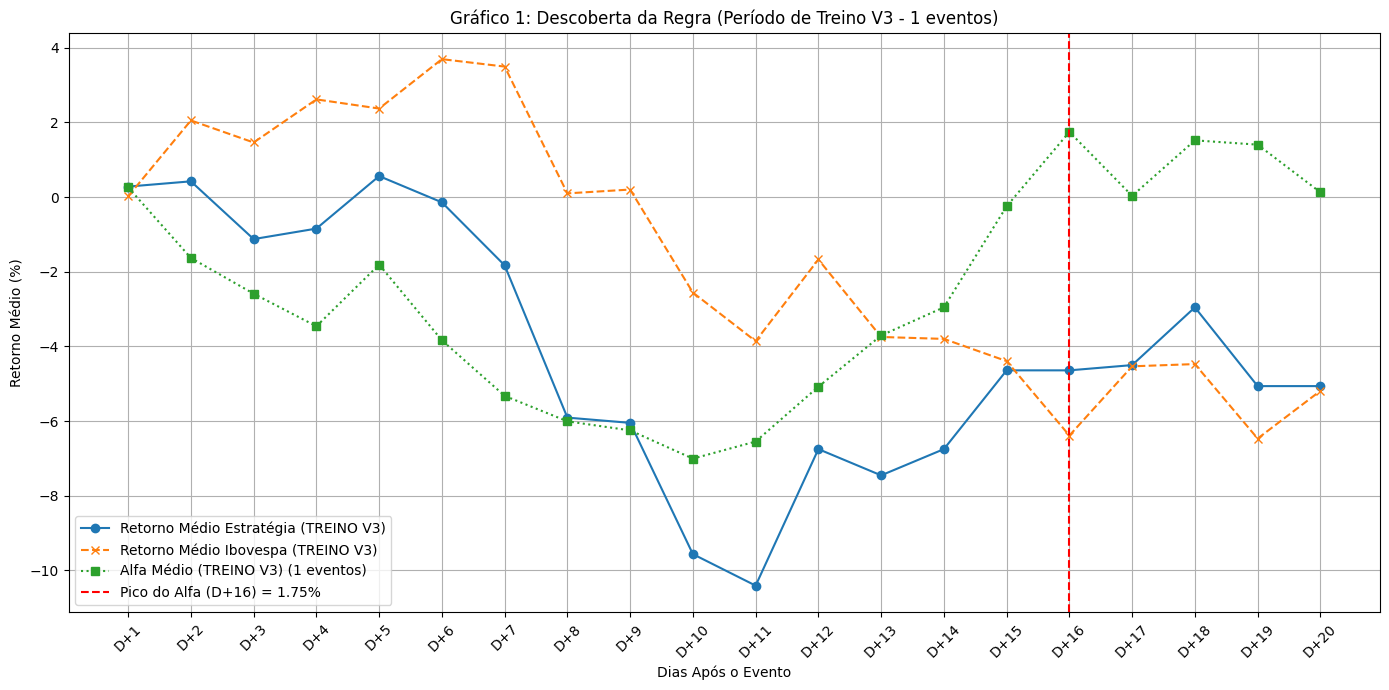


Gerando Gráfico 2: Teste de Robustez (Treino vs. Teste V3)...


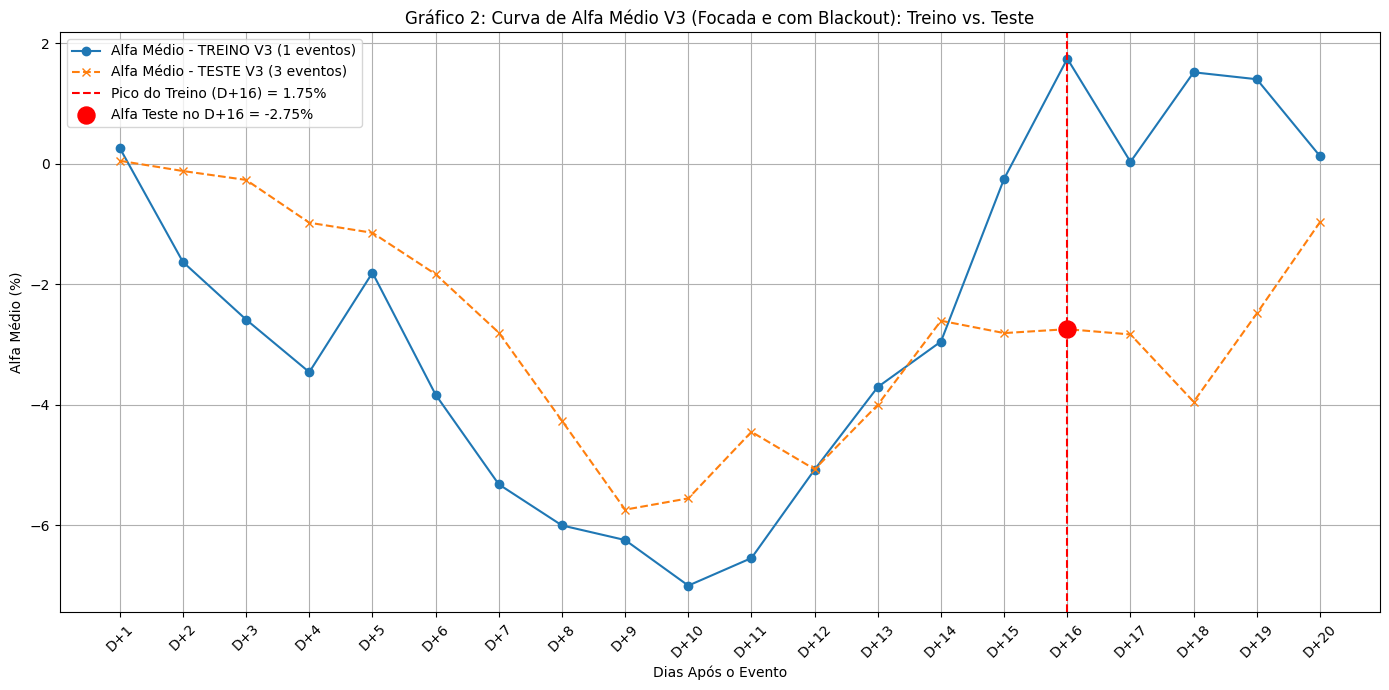

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from gnews import GNews
import json
import os
import google.generativeai as genai
from google.colab import userdata
import re

# Configurações do Pandas
pd.set_option('display.max_rows', None); pd.set_option('display.max_columns', None); pd.set_option('display.width', 2000); pd.set_option('display.max_colwidth', None)

# --------------------------------------------------------------------------
# ETAPA 1: CONFIGURAÇÃO DO ESTUDO DE EVENTOS (V3)
# --------------------------------------------------------------------------
try:
    GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
    genai.configure(api_key=GEMINI_API_KEY)
except Exception as e:
    print("ERRO: Não foi possível carregar a chave 'GEMINI_API_KEY'. Verifique se ela foi criada nos Secrets do Colab.")
    exit()

MODELO_GEMINI = genai.GenerativeModel('models/gemini-2.5-flash-lite')

# --- PARÂMETROS DE CONTROLE DE API ---
RPM_LIMIT = 12
# *** MUDANÇA (Seu pedido) ***
TOTAL_API_CALL_LIMIT = 900
SLEEP_TIME_SECONDS = 60 / RPM_LIMIT

# --- PARÂMETROS DO ESTUDO ---
data_inicio = '2015-01-01'
data_fim = '2024-12-31'
DIAS_DE_ANALISE = 20
DATA_CORTE_TREINO_TESTE = '2021-12-31'

# *** MUDANÇA (V3 - Universo Expandido) ***
# Viés de Sobrevivência (LIMITAÇÃO): Esta lista é fixa e sofre de viés de sobrevivência.
# Mas agora é um universo maior (21 empresas) para aumentar a amostra de eventos.
universo_investimento = [
    # Originais
    'PETR4.SA', 'VALE3.SA', 'SUZB3.SA', 'AMBP3.SA', 'ELET3.SA', 'RAIZ4.SA',
    # Adições V3 (Foco ISE/IBOV - Indústria, Bens, Utilities, Bancos)
    'WEGE3.SA', 'NATU3.SA', 'MGLU3.SA', 'LREN3.SA', 'KLBN4.SA', 'JBSS3.SA',
    'MRFG3.SA', 'BEEF3.SA', 'SBSP3.SA', 'EQTL3.SA', 'CPLE6.SA', 'ITUB4.SA',
    'BBDC4.SA', 'SANB11.SA', 'BBAS3.SA'
]

mapa_tickers_para_nomes = {
    # Originais
    'PETR4.SA': 'Petrobras', 'VALE3.SA': 'Vale', 'SUZB3.SA': 'Suzano',
    'AMBP3.SA': 'Ambipar', 'ELET3.SA': 'Eletrobras', 'RAIZ4.SA': 'Raízen',
    # Adições V3
    'WEGE3.SA': 'Weg', 'NATU3.SA': 'Natura', 'MGLU3.SA': 'Magazine Luiza',
    'LREN3.SA': 'Lojas Renner', 'KLBN4.SA': 'Klabin', 'JBSS3.SA': 'JBS',
    'MRFG3.SA': 'Marfrig', 'BEEF3.SA': 'Minerva', 'SBSP3.SA': 'Sabesp',
    'EQTL3.SA': 'Equatorial', 'CPLE6.SA': 'Copel', 'ITUB4.SA': 'Itaú Unibanco',
    'BBDC4.SA': 'Bradesco', 'SANB11.SA': 'Santander', 'BBAS3.SA': 'Banco do Brasil'
}


# Keywords V2 (Focada) - Mantemos a tese
keywords_busca_focada = ['crédito de carbono', 'energia renovável', 'hidrogênio verde',
                       'green bond', 'contrato de energia', 'descarbonização',
                       'joint venture sustentável', 'investimento ESG']

# *** MUDANÇA (V3) ***
NOME_ARQUIVO_CACHE = 'eventos_gemini_gnews_cache_V3_EXPANDIDO.json' # Novo arquivo de cache


# --------------------------------------------------------------------------
# ETAPA 2: FUNÇÕES DE COLETA E CLASSIFICAÇÃO COM IA
# (Mantemos o Prompt V2 'Focado', sem alterações)
# --------------------------------------------------------------------------
def buscar_dados_acoes(tickers, start, end):
    # (Função sem alteração)
    print(f"Baixando dados de preços de {start} a {end}...")
    try:
        tickers_com_ibov = tickers + ['^BVSP']
        dados = yf.download(tickers_com_ibov, start=start, end=end)
        dados.sort_index(inplace=True)
        if dados.empty:
            print("Nenhum dado de preço foi baixado."); return None
        print("Download de preços concluído.")
        return dados
    except Exception as e:
        print(f"Ocorreu um erro ao baixar os dados de preços: {e}"); return None

def classificar_manchete_com_gemini(manchete, api_counter):
    if api_counter['count'] >= api_counter['limit']:
        print("  - Limite total de chamadas de API atingido nesta execução. Parando a classificação.")
        return None

    prompt = f"""
    Analise a seguinte manchete de notícia.
    A manchete reporta um ANÚNCIO FINANCEIRO CONCRETO (ex: R$ 500 milhões, € 100M, US$ 1 Bi)
    ou uma PARCERIA ESTRATÉGICA (ex: joint-venture, contrato de longo prazo)
    de uma empresa, especificamente relacionado a sustentabilidade, ESG ou descarbonização?

    - Notícias sobre "ganhou prêmio ESG", "é líder em sustentabilidade" ou "divulgou relatório" NÃO contam.
    - Foque apenas em investimentos, contratos, aquisições ou emissão de dívida (green bonds) novos e concretos.

    Responda APENAS com 'SIM' ou 'NÃO'.
    Manchete: "{manchete}"
    """
    max_tentativas = 3
    for tentativa in range(max_tentativas):
        try:
            api_counter['count'] += 1
            print(f"  - Chamada à API #{api_counter['count']}/{api_counter['limit']}...")
            response = MODELO_GEMINI.generate_content(prompt)
            if response.candidates and response.candidates[0].content.parts:
                return "SIM" in response.text.strip().upper()
            else:
                 print("  - Resposta da API vazia ou bloqueada. Classificando como NÃO.")
                 return False
        except Exception as e:
            error_message = str(e); print(f"  - Erro na API do Gemini (tentativa {tentativa + 1}): {error_message}")
            if '429' in error_message:
                 match = re.search(r"retry in (\d+\.\d+)s", error_message)
                 tempo_espera_sugerido = float(match.group(1)) + 1 if match else 10.0
                 print(f"  - Limite de RPM/Quota atingido. Aguardando {tempo_espera_sugerido:.2f}s...")
                 time.sleep(tempo_espera_sugerido)
                 api_counter['count'] -= 1
                 continue
            time.sleep(5)
    print(f"  - Falha ao classificar após {max_tentativas} tentativas. Classificando como NÃO.")
    return False


def construir_cache_de_eventos(tickers_validos, nomes_mapa, start_str, end_str):
    print(f"\nIniciando 'Caça aos Sinais' (V3 - Universo Expandido)...")
    eventos_encontrados = []; ultimo_ano_processado = 0

    if os.path.exists(NOME_ARQUIVO_CACHE):
        try:
            with open(NOME_ARQUIVO_CACHE, 'r', encoding='utf-8') as f:
                cache_antigo = json.load(f)
                eventos_encontrados = cache_antigo.get('eventos', [])
                meta_cache = cache_antigo.get('metadata', {})

                # Verifica se os parâmetros do cache são os mesmos
                cache_keywords = meta_cache.get('keywords')
                cache_tickers = meta_cache.get('tickers')
                cache_data_fim = meta_cache.get('data_fim_cache')

                # Compara listas (ordem não importa)
                tickers_match = set(cache_tickers) == set(tickers_validos) if cache_tickers else False
                keywords_match = set(cache_keywords) == set(keywords_busca_focada) if cache_keywords else False

                if cache_data_fim == end_str and keywords_match and tickers_match:
                     print(f"Cache V3 encontrado e completo. Carregando eventos locais.")
                     return eventos_encontrados

                # Se o cache não for 100% compatível, mas tiver progresso, usa
                if keywords_match and tickers_match:
                    ultimo_ano_processado = meta_cache.get('ultimo_ano_processado', 0)
                    print(f"Progresso carregado. Continuando a partir de {ultimo_ano_processado + 1}.")
                else:
                    print("Cache V3 incompatível (parâmetros mudaram). Reiniciando a busca...")
                    eventos_encontrados = [] # Zera os eventos
                    ultimo_ano_processado = 0 # Zera o progresso
        except Exception as e:
            print(f"Erro ao ler o cache: {e}. Reiniciando a busca...")
            eventos_encontrados = []
            ultimo_ano_processado = 0

    api_counter = {'count': 0, 'limit': TOTAL_API_CALL_LIMIT}
    start_date = datetime.datetime.strptime(start_str, '%Y-%m-%d'); end_date = datetime.datetime.strptime(end_str, '%Y-%m-%d')
    ano_de_inicio = ultimo_ano_processado + 1 if ultimo_ano_processado > 0 and ultimo_ano_processado >= start_date.year else start_date.year

    for year in range(ano_de_inicio, end_date.year + 1):
        if api_counter['count'] >= api_counter['limit']: break
        print(f"\n===== PROCESSANDO ANO: {year} =====")

        start_date_year = datetime.date(year, 1, 1)
        end_date_year = datetime.date(year, 12, 31)
        if year == start_date.year: start_date_year = start_date.date()
        if year == end_date.year: end_date_year = end_date.date()

        google_news = GNews(language='pt', country='BR', start_date=start_date_year, end_date=end_date_year)

        for ticker in tickers_validos:
            if api_counter['count'] >= api_counter['limit']: break
            nome_empresa = nomes_mapa.get(ticker)
            if not nome_empresa: continue
            print(f"--- Buscando notícias para {nome_empresa} ({year}) ---")

            try:
                query = f'"{nome_empresa}" AND ({ " OR ".join(keywords_busca_focada) })';
                noticias = google_news.get_news(query);
                time.sleep(1)
            except Exception as e:
                print(f"  - Erro ao buscar no GNews: {e}. Pulando {nome_empresa} para este ano.")
                noticias = []
                time.sleep(10)

            if noticias:
                print(f"  -> {len(noticias)} notícias encontradas. Classificando...")
                for n in noticias:
                    if nome_empresa.lower() in n['title'].lower():
                        resultado = classificar_manchete_com_gemini(n['title'], api_counter)
                        if resultado is None: api_counter['count'] = api_counter['limit']; break

                        if resultado:
                            data_obj_str = datetime.datetime.strptime(n['published date'], '%a, %d %b %Y %H:%M:%S GMT').strftime('%Y-%m-%d')
                            eventos_encontrados.append({'Data': data_obj_str, 'Ticker': ticker, 'Manchete': n['title']})
                            print(f"  >>> SINAL V3 ENCONTRADO: {data_obj_str} - {ticker}")

                        time.sleep(SLEEP_TIME_SECONDS)
            time.sleep(1)

        # Salva o progresso ao final de cada ano
        df_eventos_parcial = pd.DataFrame(eventos_encontrados);
        df_eventos_parcial.drop_duplicates(subset=['Data', 'Ticker'], inplace=True)
        eventos_unicos = df_eventos_parcial.to_dict('records')

        meta_data_cache = {
            'ultimo_ano_processado': year,
            'data_fim_cache': end_str if year == end_date.year else f"{year}-12-31",
            'total_eventos': len(eventos_unicos),
            'keywords': keywords_busca_focada,
            'tickers': tickers_validos # Salva o universo usado no cache
        }

        cache_conteudo = {'metadata': meta_data_cache, 'eventos': eventos_unicos}
        with open(NOME_ARQUIVO_CACHE, 'w', encoding='utf-8') as f:
            json.dump(cache_conteudo, f, ensure_ascii=False, indent=4)
        print(f"Progresso salvo. {len(eventos_unicos)} eventos totais no cache.")

    if api_counter['count'] < api_counter['limit']:
        print(f"\nBusca V3 concluída para todo o período (até {end_str})!")
    else:
        print("\nLimite de API atingido. Rode novamente no dia seguinte para continuar.")

    df_final = pd.DataFrame(eventos_encontrados)
    df_final.drop_duplicates(subset=['Data', 'Ticker'], inplace=True)
    return df_final.to_dict('records')


# --------------------------------------------------------------------------
# ETAPA 3: FUNÇÃO DE ANÁLISE DE EVENTOS (COM BLACKOUT)
# (Sem alterações. A lógica de Blackout V2 é mantida)
# --------------------------------------------------------------------------
def executar_estudo_de_eventos(eventos, dados_acoes):
    print(f"\nIniciando estudo de eventos para {len(eventos)} eventos (com Blackout)...")
    resultados = []
    dados_acoes.index = pd.to_datetime(dados_acoes.index)
    ticker_blackout_until = {}

    for evento in eventos:
        ticker = evento['Ticker']
        if ticker not in dados_acoes['Open'].columns:
            continue

        try:
            data_evento = pd.to_datetime(evento['Data'])
        except Exception as e:
            print(f"Aviso: Data inválida no evento {evento}. Erro: {e}. Pulando.")
            continue

        # --- LÓGICA DE BLACKOUT ---
        data_fim_blackout_anterior = ticker_blackout_until.get(ticker)
        if data_fim_blackout_anterior and data_evento <= data_fim_blackout_anterior:
            # print(f"  -> Evento IGNORADO (Blackout): {data_evento.date()} para {ticker}.") # Opcional: remover print para poluir menos
            continue
        # --- FIM DA LÓGICA DE BLACKOUT ---

        dias_de_negociacao = dados_acoes.index[dados_acoes.index > data_evento]

        if len(dias_de_negociacao) < DIAS_DE_ANALISE:
            continue

        data_compra = dias_de_negociacao[0]
        preco_entrada_ativo = dados_acoes.loc[data_compra, ('Open', ticker)]
        preco_entrada_ibov = dados_acoes.loc[data_compra, ('Open', '^BVSP')]

        if pd.isna(preco_entrada_ativo) or preco_entrada_ativo == 0 or pd.isna(preco_entrada_ibov) or preco_entrada_ibov == 0:
            continue

        dias_analise = dias_de_negociacao[0:DIAS_DE_ANALISE]
        data_fim_estudo_atual = dias_analise[-1]
        ticker_blackout_until[ticker] = data_fim_estudo_atual

        resultado_linha = {'Data_Evento': data_evento.date(), 'Ticker': ticker, 'Manchete': evento['Manchete']}

        for i, dia_fechamento in enumerate(dias_analise):
            preco_fechamento_ativo = dados_acoes.loc[dia_fechamento, ('Close', ticker)]
            preco_fechamento_ibov = dados_acoes.loc[dia_fechamento, ('Close', '^BVSP')]

            if pd.isna(preco_fechamento_ativo):
                preco_fechamento_ativo = dados_acoes.loc[:dia_fechamento, ('Close', ticker)].ffill().iloc[-1]
            if pd.isna(preco_fechamento_ibov):
                preco_fechamento_ibov = dados_acoes.loc[:dia_fechamento, ('Close', '^BVSP')].ffill().iloc[-1]

            retorno_ativo = (preco_fechamento_ativo / preco_entrada_ativo) - 1
            retorno_ibov = (preco_fechamento_ibov / preco_entrada_ibov) - 1

            resultado_linha[f'D+{i+1}_Ativo'] = retorno_ativo
            resultado_linha[f'D+{i+1}_Ibov'] = retorno_ibov

        resultados.append(resultado_linha)

    print(f"Estudo de eventos (Blackout) concluído. {len(resultados)} simulações válidas geradas.")
    return pd.DataFrame(resultados)

# --------------------------------------------------------------------------
# ETAPA 4: ORQUESTRAÇÃO E DIVISÃO TREINO/TESTE
# --------------------------------------------------------------------------

# 1. Carrega ou constrói o cache de eventos (V3)
eventos_total = construir_cache_de_eventos(list(mapa_tickers_para_nomes.keys()), mapa_tickers_para_nomes, data_inicio, data_fim)

if not eventos_total:
    print("\nNenhum evento relevante (V3) foi encontrado. A análise não pode continuar.")
else:
    # 2. Baixa os dados de ações (V3)
    dados_acoes_total = buscar_dados_acoes(universo_investimento, data_inicio, data_fim)

    if dados_acoes_total is not None and not dados_acoes_total.empty:

        # 3. Divisão dos eventos (lógica mantida)
        print(f"\nDividindo eventos em Treino (até {DATA_CORTE_TREINO_TESTE}) e Teste (após {DATA_CORTE_TREINO_TESTE})...")

        eventos_treino = [e for e in eventos_total if e['Data'] <= DATA_CORTE_TREINO_TESTE]
        eventos_teste = [e for e in eventos_total if e['Data'] > DATA_CORTE_TREINO_TESTE]

        # Ordena as listas de eventos por data (essencial para o Blackout)
        eventos_treino.sort(key=lambda x: pd.to_datetime(x['Data']))
        eventos_teste.sort(key=lambda x: pd.to_datetime(x['Data']))

        print(f"Total de eventos V3 encontrados: {len(eventos_total)}")
        print(f"Eventos de Treino (In-Sample): {len(eventos_treino)}")
        print(f"Eventos de Teste (Out-of-Sample): {len(eventos_teste)}")

        # 4. Executa o estudo de eventos (lógica mantida)
        df_resultados_treino = pd.DataFrame()
        df_resultados_teste = pd.DataFrame()

        if eventos_treino:
            df_resultados_treino = executar_estudo_de_eventos(eventos_treino, dados_acoes_total)
        if eventos_teste:
            df_resultados_teste = executar_estudo_de_eventos(eventos_teste, dados_acoes_total)

# --------------------------------------------------------------------------
# ETAPA 5: ANÁLISE DE ROBUSTEZ E GRÁFICOS (V3)
# --------------------------------------------------------------------------
        print("\n--- ANÁLISE DE ROBUSTEZ (TREINO vs TESTE) V3 ---")

        if df_resultados_treino.empty:
            print("Nenhum resultado válido no período de Treino. A análise não pode continuar.")
        else:
            # 5.1. Analisa o período de TREINO
            print("\nAnalisando Período de Treino (In-Sample)...")
            df_retornos_ativo_treino = df_resultados_treino.filter(regex=r'_Ativo$')
            df_retornos_ibov_treino = df_resultados_treino.filter(regex=r'_Ibov$')

            df_retornos_ativo_treino.columns = [f'D+{i+1}' for i in range(DIAS_DE_ANALISE)]
            df_retornos_ibov_treino.columns = [f'D+{i+1}' for i in range(DIAS_DE_ANALISE)]

            retorno_medio_ativo_treino = df_retornos_ativo_treino.mean()
            retorno_medio_ibov_treino = df_retornos_ibov_treino.mean()
            retorno_alpha_treino = retorno_medio_ativo_treino - retorno_medio_ibov_treino

            dia_do_pico_alpha_treino = retorno_alpha_treino.idxmax()
            valor_pico_alpha_treino = retorno_alpha_treino.max()

            print(f"Pico de Alfa (Treino) ocorre no: {dia_do_pico_alpha_treino}")
            print(f"Alfa médio no pico (Treino): {valor_pico_alpha_treino:.2%}")

            # 5.2. Analisa o período de TESTE
            print("\nAnalisando Período de Teste (Out-of-Sample)...")
            retorno_alpha_teste = pd.Series(dtype=float) # Inicia série vazia
            alpha_teste_no_pico_treino = np.nan # Inicia como NaN

            if not df_resultados_teste.empty:
                df_retornos_ativo_teste = df_resultados_teste.filter(regex=r'_Ativo$')
                df_retornos_ibov_teste = df_resultados_teste.filter(regex=r'_Ibov$')

                df_retornos_ativo_teste.columns = [f'D+{i+1}' for i in range(DIAS_DE_ANALISE)]
                df_retornos_ibov_teste.columns = [f'D+{i+1}' for i in range(DIAS_DE_ANALISE)]

                retorno_medio_ativo_teste = df_retornos_ativo_teste.mean()
                retorno_medio_ibov_teste = df_retornos_ibov_teste.mean()
                retorno_alpha_teste = retorno_medio_ativo_teste - retorno_medio_ibov_teste

                alpha_teste_no_pico_treino = retorno_alpha_teste.get(dia_do_pico_alpha_treino, np.nan)

            if pd.isna(alpha_teste_no_pico_treino):
                 print(f"Aviso: O dia do pico do treino ({dia_do_pico_alpha_treino}) não foi encontrado nos resultados do teste ou teste está vazio.")
                 alpha_teste_no_pico_treino = 0

            print(f"Alfa médio no período de Teste (no dia do pico do Treino, {dia_do_pico_alpha_treino}): {alpha_teste_no_pico_treino:.2%}")

            # 5.3. Apresenta o Resumo Comparativo
            print("\n--- RESUMO COMPARATIVO (Alfa Médio no dia do Pico do Treino) ---")
            print(f"{'Período':<10} | {'Alfa Médio':<10} |")
            print("-" * 25)
            print(f"{'Treino':<10} | {valor_pico_alpha_treino:>9.2%} |")
            print(f"{'Teste':<10} | {alpha_teste_no_pico_treino:>9.2%} |")

            # 5.4. Salva tudo em Excel
            nome_arquivo_excel = 'Analise_de_Eventos_TREINO_TESTE_V3_EXPANDIDO.xlsx'
            with pd.ExcelWriter(nome_arquivo_excel, engine='openpyxl') as writer:
                df_resultados_treino.to_excel(writer, sheet_name='Eventos_Treino_Raw', index=False)
                if not df_resultados_teste.empty:
                    df_resultados_teste.to_excel(writer, sheet_name='Eventos_Teste_Raw', index=False)

                resumo_data = {
                    'Periodo': ['Treino', 'Teste'],
                    f'Alfa_no_{dia_do_pico_alpha_treino}': [valor_pico_alpha_treino, alpha_teste_no_pico_treino]
                }
                pd.DataFrame(resumo_data).to_excel(writer, sheet_name='Resumo_Pico_Treino', index=False)

                # Salva as 3 séries do treino
                retorno_medio_ativo_treino.to_frame(name='Ret_Ativo_Treino').to_excel(writer, sheet_name='Medias_Treino')
                retorno_medio_ibov_treino.to_frame(name='Ret_Ibov_Treino').to_excel(writer, sheet_name='Medias_Treino', startcol=3)
                retorno_alpha_treino.to_frame(name='Alfa_Treino').to_excel(writer, sheet_name='Medias_Treino', startcol=6)

            print(f"\nResultados detalhados (V3) exportados para '{nome_arquivo_excel}'")

            # 5.5. Gera os Gráficos de Análise

            # *** MUDANÇA (Gráfico 1 - Detalhes do Treino) ***
            print("\nGerando Gráfico 1: Análise do Período de Treino (V3)...")
            plt.figure(figsize=(14, 7))
            plt.plot(retorno_medio_ativo_treino.index, retorno_medio_ativo_treino.values * 100,
                     marker='o', linestyle='-', label=f'Retorno Médio Estratégia (TREINO V3)')
            plt.plot(retorno_medio_ibov_treino.index, retorno_medio_ibov_treino.values * 100,
                     marker='x', linestyle='--', label=f'Retorno Médio Ibovespa (TREINO V3)')
            plt.plot(retorno_alpha_treino.index, retorno_alpha_treino.values * 100,
                     marker='s', linestyle=':', label=f'Alfa Médio (TREINO V3) ({len(df_resultados_treino)} eventos)')

            plt.title(f'Gráfico 1: Descoberta da Regra (Período de Treino V3 - {len(df_resultados_treino)} eventos)')
            plt.xlabel('Dias Após o Evento'); plt.ylabel('Retorno Médio (%)')
            plt.axvline(x=dia_do_pico_alpha_treino, color='r', linestyle='--',
                        label=f'Pico do Alfa ({dia_do_pico_alpha_treino}) = {valor_pico_alpha_treino:.2%}')
            plt.grid(True); plt.legend(); plt.xticks(rotation=45); plt.tight_layout(); plt.show()


            # *** MUDANÇA (Gráfico 2 - Teste de Robustez) ***
            print("\nGerando Gráfico 2: Teste de Robustez (Treino vs. Teste V3)...")
            plt.figure(figsize=(14, 7))

            # Linha do Alfa Treino
            plt.plot(retorno_alpha_treino.index, retorno_alpha_treino.values * 100,
                     marker='o', linestyle='-', label=f'Alfa Médio - TREINO V3 ({len(df_resultados_treino)} eventos)')

            # Linha do Alfa Teste (se existirem)
            if not retorno_alpha_teste.empty:
                plt.plot(retorno_alpha_teste.index, retorno_alpha_teste.values * 100,
                         marker='x', linestyle='--', label=f'Alfa Médio - TESTE V3 ({len(df_resultados_teste)} eventos)')

            plt.title('Gráfico 2: Curva de Alfa Médio V3 (Focada e com Blackout): Treino vs. Teste')
            plt.xlabel('Dias Após o Evento'); plt.ylabel('Alfa Médio (%)')
            plt.axvline(x=dia_do_pico_alpha_treino, color='r', linestyle='--',
                        label=f'Pico do Treino ({dia_do_pico_alpha_treino}) = {valor_pico_alpha_treino:.2%}')

            if not retorno_alpha_teste.empty:
                plt.scatter(dia_do_pico_alpha_treino, alpha_teste_no_pico_treino * 100,
                            s=150, color='red', zorder=5,
                            label=f'Alfa Teste no {dia_do_pico_alpha_treino} = {alpha_teste_no_pico_treino:.2%}')

            plt.grid(True); plt.legend(); plt.xticks(rotation=45); plt.tight_layout(); plt.show()

    else:
        print("\nDownload dos dados de ações falhou. A análise não pode continuar.")

#v3

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from gnews import GNews
import json
import os
import google.generativeai as genai
from google.colab import userdata
import re

# Configurações do Pandas
pd.set_option('display.max_rows', None); pd.set_option('display.max_columns', None); pd.set_option('display.width', 2000); pd.set_option('display.max_colwidth', None)

# --------------------------------------------------------------------------
# ETAPA 1: CONFIGURAÇÃO DO ESTUDO DE EVENTOS (V4 - Tese Ampla)
# --------------------------------------------------------------------------
try:
    GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
    genai.configure(api_key=GEMINI_API_KEY)
except Exception as e:
    print("ERRO: Não foi possível carregar a chave 'GEMINI_API_KEY'. Verifique se ela foi criada nos Secrets do Colab.")
    exit()

MODELO_GEMINI = genai.GenerativeModel('models/gemini-1.5-flash-latest') # Sugestão

# --- PARÂMETROS DE CONTROLE DE API ---
RPM_LIMIT = 12
TOTAL_API_CALL_LIMIT = 900 # Mantendo o limite alto
SLEEP_TIME_SECONDS = 60 / RPM_LIMIT

# --- PARÂMETROS DO ESTUDO ---
data_inicio = '2015-01-01'
data_fim = '2024-12-31'
DIAS_DE_ANALISE = 20
DATA_CORTE_TREINO_TESTE = '2021-12-31' # Mantém o rigor do Treino/Teste

# *** TESE V1 (AMPLA) - Mantida conforme seu pedido ***
# Viés de Sobrevivência (LIMITAÇÃO): Esta lista é fixa e sofre de viés de sobrevivência.
universo_investimento = ['PETR4.SA', 'VALE3.SA', 'SUZB3.SA', 'AMBP3.SA', 'ELET3.SA', 'RAIZ4.SA']
mapa_tickers_para_nomes = {
    'PETR4.SA': 'Petrobras', 'VALE3.SA': 'Vale', 'SUZB3.SA': 'Suzano',
    'AMBP3.SA': 'Ambipar', 'ELET3.SA': 'Eletrobras', 'RAIZ4.SA': 'Raízen'
}

# *** TESE V1 (AMPLA) - Mantida conforme seu pedido ***
# Estas keywords geram muitos eventos (e ruído), mas é a tese que estamos testando.
keywords_busca_ampla = ['sustentabilidade', 'ESG', 'crédito de carbono', 'meio ambiente', 'energia renovável']

# *** MUDANÇA (V4) ***
NOME_ARQUIVO_CACHE = 'eventos_gemini_gnews_cache_V4_AMPLA_COM_RIGOR.json' # Novo arquivo de cache


# --------------------------------------------------------------------------
# ETAPA 2: FUNÇÕES DE COLETA E CLASSIFICAÇÃO COM IA (Tese Ampla)
# --------------------------------------------------------------------------
def buscar_dados_acoes(tickers, start, end):
    # (Função sem alteração)
    print(f"Baixando dados de preços de {start} a {end}...")
    try:
        tickers_com_ibov = tickers + ['^BVSP']
        dados = yf.download(tickers_com_ibov, start=start, end=end)
        dados.sort_index(inplace=True)
        if dados.empty:
            print("Nenhum dado de preço foi baixado."); return None
        print("Download de preços concluído.")
        return dados
    except Exception as e:
        print(f"Ocorreu um erro ao baixar os dados de preços: {e}"); return None

def classificar_manchete_com_gemini(manchete, api_counter):
    # *** TESE V1 (AMPLA) - Mantida conforme seu pedido ***
    # Este é o Prompt "V1" (simples)

    if api_counter['count'] >= api_counter['limit']:
        print("  - Limite total de chamadas de API atingido nesta execução. Parando a classificação.")
        return None

    prompt = f"""
    Analise a seguinte manchete de notícia. A manchete reporta um novo e concreto investimento, contrato, certificação, ou iniciativa positiva de uma empresa no setor de 'carbono verde', sustentabilidade ou descarbonização?
    Responda APENAS com 'SIM' ou 'NÃO'.
    Manchete: "{manchete}"
    """
    max_tentativas = 3
    for tentativa in range(max_tentativas):
        try:
            api_counter['count'] += 1
            print(f"  - Chamada à API #{api_counter['count']}/{api_counter['limit']}...")
            response = MODELO_GEMINI.generate_content(prompt)
            if response.candidates and response.candidates[0].content.parts:
                return "SIM" in response.text.strip().upper()
            else:
                 print("  - Resposta da API vazia ou bloqueada. Classificando como NÃO.")
                 return False
        except Exception as e:
            error_message = str(e); print(f"  - Erro na API do Gemini (tentativa {tentativa + 1}): {error_message}")
            if '429' in error_message:
                 match = re.search(r"retry in (\d+\.\d+)s", error_message)
                 tempo_espera_sugerido = float(match.group(1)) + 1 if match else 10.0
                 print(f"  - Limite de RPM/Quota atingido. Aguardando {tempo_espera_sugerido:.2f}s...")
                 time.sleep(tempo_espera_sugerido)
                 api_counter['count'] -= 1
                 continue
            time.sleep(5)
    print(f"  - Falha ao classificar após {max_tentativas} tentativas. Classificando como NÃO.")
    return False


def construir_cache_de_eventos(tickers_validos, nomes_mapa, start_str, end_str):
    print(f"\nIniciando 'Caça aos Sinais' (V4 - Tese Ampla)...")
    eventos_encontrados = []; ultimo_ano_processado = 0

    if os.path.exists(NOME_ARQUIVO_CACHE):
        try:
            with open(NOME_ARQUIVO_CACHE, 'r', encoding='utf-8') as f:
                cache_antigo = json.load(f)
                eventos_encontrados = cache_antigo.get('eventos', [])
                meta_cache = cache_antigo.get('metadata', {})

                cache_keywords = meta_cache.get('keywords')
                cache_tickers = meta_cache.get('tickers')
                cache_data_fim = meta_cache.get('data_fim_cache')

                tickers_match = set(cache_tickers) == set(tickers_validos) if cache_tickers else False
                keywords_match = set(cache_keywords) == set(keywords_busca_ampla) if cache_keywords else False # Compara com keywords amplas

                if cache_data_fim == end_str and keywords_match and tickers_match:
                     print(f"Cache V4 encontrado e completo. Carregando eventos locais.")
                     return eventos_encontrados

                if keywords_match and tickers_match:
                    ultimo_ano_processado = meta_cache.get('ultimo_ano_processado', 0)
                    print(f"Progresso carregado. Continuando a partir de {ultimo_ano_processado + 1}.")
                else:
                    print("Cache V4 incompatível (parâmetros mudaram). Reiniciando a busca...")
                    eventos_encontrados = []
                    ultimo_ano_processado = 0
        except Exception as e:
            print(f"Erro ao ler o cache: {e}. Reiniciando a busca...")
            eventos_encontrados = []
            ultimo_ano_processado = 0

    api_counter = {'count': 0, 'limit': TOTAL_API_CALL_LIMIT}
    start_date = datetime.datetime.strptime(start_str, '%Y-%m-%d'); end_date = datetime.datetime.strptime(end_str, '%Y-%m-%d')
    ano_de_inicio = ultimo_ano_processado + 1 if ultimo_ano_processado > 0 and ultimo_ano_processado >= start_date.year else start_date.year

    for year in range(ano_de_inicio, end_date.year + 1):
        if api_counter['count'] >= api_counter['limit']: break
        print(f"\n===== PROCESSANDO ANO: {year} =====")

        start_date_year = datetime.date(year, 1, 1)
        end_date_year = datetime.date(year, 12, 31)
        if year == start_date.year: start_date_year = start_date.date()
        if year == end_date.year: end_date_year = end_date.date()

        google_news = GNews(language='pt', country='BR', start_date=start_date_year, end_date=end_date_year)

        for ticker in tickers_validos:
            if api_counter['count'] >= api_counter['limit']: break
            nome_empresa = nomes_mapa.get(ticker)
            if not nome_empresa: continue
            print(f"--- Buscando notícias para {nome_empresa} ({year}) ---")

            try:
                # *** TESE V1 (AMPLA) - Mantida ***
                query = f'"{nome_empresa}" AND ({ " OR ".join(keywords_busca_ampla) })';
                noticias = google_news.get_news(query);
                time.sleep(1)
            except Exception as e:
                print(f"  - Erro ao buscar no GNews: {e}. Pulando {nome_empresa} para este ano.")
                noticias = []
                time.sleep(10)

            if noticias:
                print(f"  -> {len(noticias)} notícias encontradas. Classificando...")
                for n in noticias:
                    if nome_empresa.lower() in n['title'].lower():
                        resultado = classificar_manchete_com_gemini(n['title'], api_counter)
                        if resultado is None: api_counter['count'] = api_counter['limit']; break

                        if resultado:
                            data_obj_str = datetime.datetime.strptime(n['published date'], '%a, %d %b %Y %H:%M:%S GMT').strftime('%Y-%m-%d')
                            eventos_encontrados.append({'Data': data_obj_str, 'Ticker': ticker, 'Manchete': n['title']})
                            print(f"  >>> SINAL V4 (Amplo) ENCONTRADO: {data_obj_str} - {ticker}")

                        time.sleep(SLEEP_TIME_SECONDS)
            time.sleep(1)

        # Salva o progresso ao final de cada ano
        df_eventos_parcial = pd.DataFrame(eventos_encontrados);
        df_eventos_parcial.drop_duplicates(subset=['Data', 'Ticker'], inplace=True)
        eventos_unicos = df_eventos_parcial.to_dict('records')

        meta_data_cache = {
            'ultimo_ano_processado': year,
            'data_fim_cache': end_str if year == end_date.year else f"{year}-12-31",
            'total_eventos': len(eventos_unicos),
            'keywords': keywords_busca_ampla, # Salva as keywords V1
            'tickers': tickers_validos
        }

        cache_conteudo = {'metadata': meta_data_cache, 'eventos': eventos_unicos}
        with open(NOME_ARQUIVO_CACHE, 'w', encoding='utf-8') as f:
            json.dump(cache_conteudo, f, ensure_ascii=False, indent=4)
        print(f"Progresso salvo. {len(eventos_unicos)} eventos totais no cache.")

    if api_counter['count'] < api_counter['limit']:
        print(f"\nBusca V4 concluída para todo o período (até {end_str})!")
    else:
        print("\nLimite de API atingido. Rode novamente no dia seguinte para continuar.")

    df_final = pd.DataFrame(eventos_encontrados)
    df_final.drop_duplicates(subset=['Data', 'Ticker'], inplace=True)
    return df_final.to_dict('records')


# --------------------------------------------------------------------------
# ETAPA 3: FUNÇÃO DE ANÁLISE DE EVENTOS (COM BLACKOUT)
# (Esta é a mitigação do Viés de Agrupamento)
# --------------------------------------------------------------------------
def executar_estudo_de_eventos(eventos, dados_acoes):
    print(f"\nIniciando estudo de eventos para {len(eventos)} eventos (com Blackout)...")
    resultados = []
    dados_acoes.index = pd.to_datetime(dados_acoes.index)
    ticker_blackout_until = {}

    # A lista de eventos já vem ordenada da Etapa 4

    for evento in eventos:
        ticker = evento['Ticker']
        if ticker not in dados_acoes['Open'].columns:
            continue

        try:
            data_evento = pd.to_datetime(evento['Data'])
        except Exception as e:
            print(f"Aviso: Data inválida no evento {evento}. Erro: {e}. Pulando.")
            continue

        # --- LÓGICA DE BLACKOUT ---
        data_fim_blackout_anterior = ticker_blackout_until.get(ticker)
        if data_fim_blackout_anterior and data_evento <= data_fim_blackout_anterior:
            # print(f"  -> Evento IGNORADO (Blackout): {data_evento.date()} para {ticker}.")
            continue
        # --- FIM DA LÓGICA DE BLACKOUT ---

        dias_de_negociacao = dados_acoes.index[dados_acoes.index > data_evento]

        if len(dias_de_negociacao) < DIAS_DE_ANALISE:
            continue

        data_compra = dias_de_negociacao[0]
        preco_entrada_ativo = dados_acoes.loc[data_compra, ('Open', ticker)]
        preco_entrada_ibov = dados_acoes.loc[data_compra, ('Open', '^BVSP')]

        if pd.isna(preco_entrada_ativo) or preco_entrada_ativo == 0 or pd.isna(preco_entrada_ibov) or preco_entrada_ibov == 0:
            continue

        dias_analise = dias_de_negociacao[0:DIAS_DE_ANALISE]
        data_fim_estudo_atual = dias_analise[-1]
        ticker_blackout_until[ticker] = data_fim_estudo_atual

        resultado_linha = {'Data_Evento': data_evento.date(), 'Ticker': ticker, 'Manchete': evento['Manchete']}

        for i, dia_fechamento in enumerate(dias_analise):
            preco_fechamento_ativo = dados_acoes.loc[dia_fechamento, ('Close', ticker)]
            preco_fechamento_ibov = dados_acoes.loc[dia_fechamento, ('Close', '^BVSP')]

            if pd.isna(preco_fechamento_ativo):
                preco_fechamento_ativo = dados_acoes.loc[:dia_fechamento, ('Close', ticker)].ffill().iloc[-1]
            if pd.isna(preco_fechamento_ibov):
                preco_fechamento_ibov = dados_acoes.loc[:dia_fechamento, ('Close', '^BVSP')].ffill().iloc[-1]

            retorno_ativo = (preco_fechamento_ativo / preco_entrada_ativo) - 1
            retorno_ibov = (preco_fechamento_ibov / preco_entrada_ibov) - 1

            resultado_linha[f'D+{i+1}_Ativo'] = retorno_ativo
            resultado_linha[f'D+{i+1}_Ibov'] = retorno_ibov

        resultados.append(resultado_linha)

    print(f"Estudo de eventos (Blackout) concluído. {len(resultados)} simulações válidas geradas.")
    return pd.DataFrame(resultados)

# --------------------------------------------------------------------------
# ETAPA 4: ORQUESTRAÇÃO E DIVISÃO TREINO/TESTE
# (Esta é a mitigação do Viés de Overfitting)
# --------------------------------------------------------------------------

# 1. Carrega ou constrói o cache de eventos (V4)
eventos_total = construir_cache_de_eventos(list(mapa_tickers_para_nomes.keys()), mapa_tickers_para_nomes, data_inicio, data_fim)

if not eventos_total:
    print("\nNenhum evento relevante (V4) foi encontrado. A análise não pode continuar.")
else:
    # 2. Baixa os dados de ações
    dados_acoes_total = buscar_dados_acoes(universo_investimento, data_inicio, data_fim)

    if dados_acoes_total is not None and not dados_acoes_total.empty:

        # 3. Divisão dos eventos
        print(f"\nDividindo eventos em Treino (até {DATA_CORTE_TREINO_TESTE}) e Teste (após {DATA_CORTE_TREINO_TESTE})...")

        eventos_treino = [e for e in eventos_total if e['Data'] <= DATA_CORTE_TREINO_TESTE]
        eventos_teste = [e for e in eventos_total if e['Data'] > DATA_CORTE_TREINO_TESTE]

        # Ordena as listas de eventos por data (essencial para o Blackout)
        eventos_treino.sort(key=lambda x: pd.to_datetime(x['Data']))
        eventos_teste.sort(key=lambda x: pd.to_datetime(x['Data']))

        print(f"Total de eventos V4 encontrados: {len(eventos_total)}")
        print(f"Eventos de Treino (In-Sample): {len(eventos_treino)}")
        print(f"Eventos de Teste (Out-of-Sample): {len(eventos_teste)}")

        # 4. Executa o estudo de eventos (com blackout)
        df_resultados_treino = pd.DataFrame()
        df_resultados_teste = pd.DataFrame()

        if eventos_treino:
            df_resultados_treino = executar_estudo_de_eventos(eventos_treino, dados_acoes_total)
        if eventos_teste:
            df_resultados_teste = executar_estudo_de_eventos(eventos_teste, dados_acoes_total)

# --------------------------------------------------------------------------
# ETAPA 5: ANÁLISE DE ROBUSTEZ E GRÁFICOS (V4)
# --------------------------------------------------------------------------
        print("\n--- ANÁLISE DE ROBUSTEZ (TREINO vs TESTE) V4 ---")

        if df_resultados_treino.empty:
            print("Nenhum resultado válido no período de Treino. A análise não pode continuar.")
        else:
            # 5.1. Analisa o período de TREINO
            print("\nAnalisando Período de Treino (In-Sample)...")
            df_retornos_ativo_treino = df_resultados_treino.filter(regex=r'_Ativo$')
            df_retornos_ibov_treino = df_resultados_treino.filter(regex=r'_Ibov$')

            df_retornos_ativo_treino.columns = [f'D+{i+1}' for i in range(DIAS_DE_ANALISE)]
            df_retornos_ibov_treino.columns = [f'D+{i+1}' for i in range(DIAS_DE_ANALISE)]

            retorno_medio_ativo_treino = df_retornos_ativo_treino.mean()
            retorno_medio_ibov_treino = df_retornos_ibov_treino.mean()
            retorno_alpha_treino = retorno_medio_ativo_treino - retorno_medio_ibov_treino

            dia_do_pico_alpha_treino = retorno_alpha_treino.idxmax()
            valor_pico_alpha_treino = retorno_alpha_treino.max()

            print(f"Pico de Alfa (Treino) ocorre no: {dia_do_pico_alpha_treino}")
            print(f"Alfa médio no pico (Treino): {valor_pico_alpha_treino:.2%}")

            # 5.2. Analisa o período de TESTE
            print("\nAnalisando Período de Teste (Out-of-Sample)...")
            retorno_alpha_teste = pd.Series(dtype=float)
            alpha_teste_no_pico_treino = np.nan

            if not df_resultados_teste.empty:
                df_retornos_ativo_teste = df_resultados_teste.filter(regex=r'_Ativo$')
                df_retornos_ibov_teste = df_resultados_teste.filter(regex=r'_Ibov$')

                df_retornos_ativo_teste.columns = [f'D+{i+1}' for i in range(DIAS_DE_ANALISE)]
                df_retornos_ibov_teste.columns = [f'D+{i+1}' for i in range(DIAS_DE_ANALISE)]

                retorno_medio_ativo_teste = df_retornos_ativo_teste.mean()
                retorno_medio_ibov_teste = df_retornos_ibov_teste.mean()
                retorno_alpha_teste = retorno_medio_ativo_teste - retorno_medio_ibov_teste

                alpha_teste_no_pico_treino = retorno_alpha_teste.get(dia_do_pico_alpha_treino, np.nan)

            if pd.isna(alpha_teste_no_pico_treino):
                 print(f"Aviso: O dia do pico do treino ({dia_do_pico_alpha_treino}) não foi encontrado nos resultados do teste ou teste está vazio.")
                 alpha_teste_no_pico_treino = 0

            print(f"Alfa médio no período de Teste (no dia do pico do Treino, {dia_do_pico_alpha_treino}): {alpha_teste_no_pico_treino:.2%}")

            # 5.3. Apresenta o Resumo Comparativo
            print("\n--- RESUMO COMPARATIVO (Alfa Médio no dia do Pico do Treino) ---")
            print(f"{'Período':<10} | {'Alfa Médio':<10} |")
            print("-" * 25)
            print(f"{'Treino':<10} | {valor_pico_alpha_treino:>9.2%} |")
            print(f"{'Teste':<10} | {alpha_teste_no_pico_treino:>9.2%} |")

            # 5.4. Salva tudo em Excel
            nome_arquivo_excel = 'Analise_de_Eventos_TREINO_TESTE_V4_AMPLA.xlsx'
            with pd.ExcelWriter(nome_arquivo_excel, engine='openpyxl') as writer:
                df_resultados_treino.to_excel(writer, sheet_name='Eventos_Treino_Raw', index=False)
                if not df_resultados_teste.empty:
                    df_resultados_teste.to_excel(writer, sheet_name='Eventos_Teste_Raw', index=False)

                resumo_data = {
                    'Periodo': ['Treino', 'Teste'],
                    f'Alfa_no_{dia_do_pico_alpha_treino}': [valor_pico_alpha_treino, alpha_teste_no_pico_preino]
                }
                pd.DataFrame(resumo_data).to_excel(writer, sheet_name='Resumo_Pico_Treino', index=False)

                retorno_medio_ativo_treino.to_frame(name='Ret_Ativo_Treino').to_excel(writer, sheet_name='Medias_Treino')
                retorno_medio_ibov_treino.to_frame(name='Ret_Ibov_Treino').to_excel(writer, sheet_name='Medias_Treino', startcol=3)
                retorno_alpha_treino.to_frame(name='Alfa_Treino').to_excel(writer, sheet_name='Medias_Treino', startcol=6)

            print(f"\nResultados detalhados (V4) exportados para '{nome_arquivo_excel}'")

            # 5.5. Gera os Gráficos de Análise

            # Gráfico 1: Análise do Período de Treino (V4)
            print("\nGerando Gráfico 1: Análise do Período de Treino (V4)...")
            plt.figure(figsize=(14, 7))
            plt.plot(retorno_medio_ativo_treino.index, retorno_medio_ativo_treino.values * 100,
                     marker='o', linestyle='-', label=f'Retorno Médio Estratégia (TREINO V4)')
            plt.plot(retorno_medio_ibov_treino.index, retorno_medio_ibov_treino.values * 100,
                     marker='x', linestyle='--', label=f'Retorno Médio Ibovespa (TREINO V4)')
            plt.plot(retorno_alpha_treino.index, retorno_alpha_treino.values * 100,
                     marker='s', linestyle=':', label=f'Alfa Médio (TREINO V4) ({len(df_resultados_treino)} eventos)')

            plt.title(f'Gráfico 1: Descoberta da Regra (Período de Treino V4 - {len(df_resultados_treino)} eventos)')
            plt.xlabel('Dias Após o Evento'); plt.ylabel('Retorno Médio (%)')
            plt.axvline(x=dia_do_pico_alpha_treino, color='r', linestyle='--',
                        label=f'Pico do Alfa ({dia_do_pico_alpha_treino}) = {valor_pico_alpha_treino:.2%}')
            plt.grid(True); plt.legend(); plt.xticks(rotation=45); plt.tight_layout(); plt.show()


            # Gráfico 2: Teste de Robustez (V4)
            print("\nGerando Gráfico 2: Teste de Robustez (Treino vs. Teste V4)...")
            plt.figure(figsize=(14, 7))

            plt.plot(retorno_alpha_treino.index, retorno_alpha_treino.values * 100,
                     marker='o', linestyle='-', label=f'Alfa Médio - TREINO V4 ({len(df_resultados_treino)} eventos)')

            if not retorno_alpha_teste.empty:
                plt.plot(retorno_alpha_teste.index, retorno_alpha_teste.values * 100,
                         marker='x', linestyle='--', label=f'Alfa Médio - TESTE V4 ({len(df_resultados_teste)} eventos)')

            plt.title('Gráfico 2: Curva de Alfa Médio V4 (Tese Ampla com Rigor): Treino vs. Teste')
            plt.xlabel('Dias Após o Evento'); plt.ylabel('Alfa Médio (%)')
            plt.axvline(x=dia_do_pico_alpha_treino, color='r', linestyle='--',
                        label=f'Pico do Treino ({dia_do_pico_alpha_treino}) = {valor_pico_alpha_treino:.2%}')

            if not retorno_alpha_teste.empty:
                plt.scatter(dia_do_pico_alpha_treino, alpha_teste_no_pico_treino * 100,
                            s=150, color='red', zorder=5,
                            label=f'Alfa Teste no {dia_do_pico_alpha_treino} = {alpha_teste_no_pico_treino:.2%}')

            plt.grid(True); plt.legend(); plt.xticks(rotation=45); plt.tight_layout(); plt.show()

    else:
        print("\nDownload dos dados de ações falhou. A análise não pode continuar.")

#v4


Iniciando 'Caça aos Sinais' (V3 - Universo Expandido)...

===== PROCESSANDO ANO: 2015 =====
--- Buscando notícias para Petrobras (2015) ---
--- Buscando notícias para Vale (2015) ---
--- Buscando notícias para Suzano (2015) ---
--- Buscando notícias para Ambipar (2015) ---
--- Buscando notícias para Eletrobras (2015) ---
  -> 2 notícias encontradas. Classificando...
--- Buscando notícias para Raízen (2015) ---
--- Buscando notícias para Weg (2015) ---
--- Buscando notícias para Natura (2015) ---
--- Buscando notícias para Magazine Luiza (2015) ---
--- Buscando notícias para Lojas Renner (2015) ---
  -> 1 notícias encontradas. Classificando...
--- Buscando notícias para Klabin (2015) ---
--- Buscando notícias para JBS (2015) ---
--- Buscando notícias para Marfrig (2015) ---
--- Buscando notícias para Minerva (2015) ---
--- Buscando notícias para Sabesp (2015) ---
--- Buscando notícias para Equatorial (2015) ---
  -> 3 notícias encontradas. Classificando...
  - Chamada à API #1/900...
-

/tmp/ipython-input-1455176435.py:84: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dados = yf.download(tickers_com_ibov, start=start, end=end)
[*********************100%***********************]  22 of 22 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['JBSS3.SA']: YFTzMissingError('possibly delisted; no timezone found')


Download de preços concluído.

Dividindo eventos em Treino (até 2021-12-31) e Teste (após 2021-12-31)...
Total de eventos V3 encontrados: 4
Eventos de Treino (In-Sample): 1
Eventos de Teste (Out-of-Sample): 3

Iniciando estudo de eventos para 1 eventos (com Blackout)...
Estudo de eventos (Blackout) concluído. 1 simulações válidas geradas.

Iniciando estudo de eventos para 3 eventos (com Blackout)...
Estudo de eventos (Blackout) concluído. 3 simulações válidas geradas.

--- ANÁLISE DE ROBUSTEZ (TREINO vs TESTE) V3 ---

Analisando Período de Treino (In-Sample)...
Pico de Alfa (Treino) ocorre no: D+16
Alfa médio no pico (Treino): 1.75%

Analisando Período de Teste (Out-of-Sample)...
Alfa médio no período de Teste (no dia do pico do Treino, D+16): -2.75%

--- RESUMO COMPARATIVO (Alfa Médio no dia do Pico do Treino) ---
Período    | Alfa Médio |
-------------------------
Treino     |     1.75% |
Teste      |    -2.75% |

Resultados detalhados (V3) exportados para 'Analise_de_Eventos_TREINO_

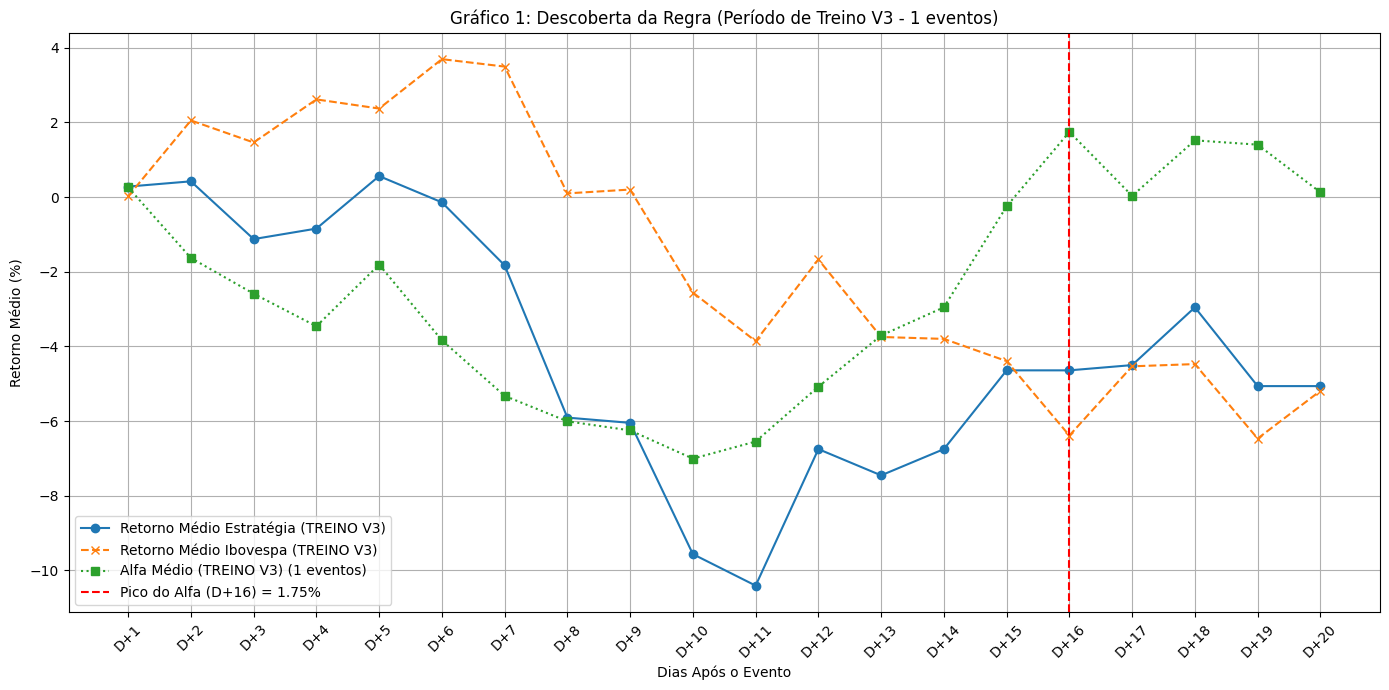


Gerando Gráfico 2: Teste de Robustez (Treino vs. Teste V3)...


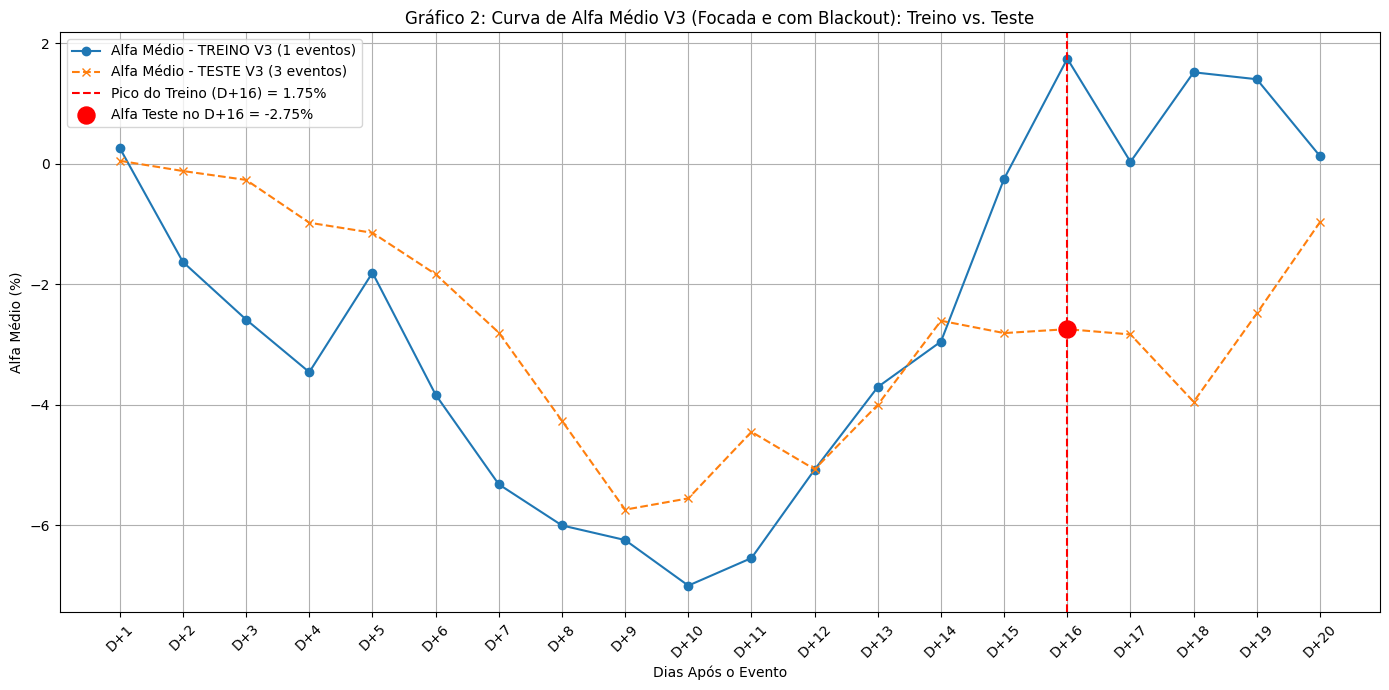

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from gnews import GNews
import json
import os
import google.generativeai as genai
from google.colab import userdata
import re

# Configurações do Pandas
pd.set_option('display.max_rows', None); pd.set_option('display.max_columns', None); pd.set_option('display.width', 2000); pd.set_option('display.max_colwidth', None)

# --------------------------------------------------------------------------
# ETAPA 1: CONFIGURAÇÃO DO ESTUDO DE EVENTOS (V3)
# --------------------------------------------------------------------------
try:
    GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
    genai.configure(api_key=GEMINI_API_KEY)
except Exception as e:
    print("ERRO: Não foi possível carregar a chave 'GEMINI_API_KEY'. Verifique se ela foi criada nos Secrets do Colab.")
    exit()

MODELO_GEMINI = genai.GenerativeModel('models/gemini-2.5-flash-lite')

# --- PARÂMETROS DE CONTROLE DE API ---
RPM_LIMIT = 12
# *** MUDANÇA (Seu pedido) ***
TOTAL_API_CALL_LIMIT = 900
SLEEP_TIME_SECONDS = 60 / RPM_LIMIT

# --- PARÂMETROS DO ESTUDO ---
data_inicio = '2015-01-01'
data_fim = '2024-12-31'
DIAS_DE_ANALISE = 20
DATA_CORTE_TREINO_TESTE = '2021-12-31'

# *** MUDANÇA (V3 - Universo Expandido) ***
# Viés de Sobrevivência (LIMITAÇÃO): Esta lista é fixa e sofre de viés de sobrevivência.
# Mas agora é um universo maior (21 empresas) para aumentar a amostra de eventos.
universo_investimento = [
    # Originais
    'PETR4.SA', 'VALE3.SA', 'SUZB3.SA', 'AMBP3.SA', 'ELET3.SA', 'RAIZ4.SA',
    # Adições V3 (Foco ISE/IBOV - Indústria, Bens, Utilities, Bancos)
    'WEGE3.SA', 'NATU3.SA', 'MGLU3.SA', 'LREN3.SA', 'KLBN4.SA', 'JBSS3.SA',
    'MRFG3.SA', 'BEEF3.SA', 'SBSP3.SA', 'EQTL3.SA', 'CPLE6.SA', 'ITUB4.SA',
    'BBDC4.SA', 'SANB11.SA', 'BBAS3.SA'
]

mapa_tickers_para_nomes = {
    # Originais
    'PETR4.SA': 'Petrobras', 'VALE3.SA': 'Vale', 'SUZB3.SA': 'Suzano',
    'AMBP3.SA': 'Ambipar', 'ELET3.SA': 'Eletrobras', 'RAIZ4.SA': 'Raízen',
    # Adições V3
    'WEGE3.SA': 'Weg', 'NATU3.SA': 'Natura', 'MGLU3.SA': 'Magazine Luiza',
    'LREN3.SA': 'Lojas Renner', 'KLBN4.SA': 'Klabin', 'JBSS3.SA': 'JBS',
    'MRFG3.SA': 'Marfrig', 'BEEF3.SA': 'Minerva', 'SBSP3.SA': 'Sabesp',
    'EQTL3.SA': 'Equatorial', 'CPLE6.SA': 'Copel', 'ITUB4.SA': 'Itaú Unibanco',
    'BBDC4.SA': 'Bradesco', 'SANB11.SA': 'Santander', 'BBAS3.SA': 'Banco do Brasil'
}


# Keywords V2 (Focada) - Mantemos a tese
keywords_busca_focada = ['crédito de carbono', 'energia renovável', 'hidrogênio verde',
                       'green bond', 'contrato de energia', 'descarbonização',
                       'joint venture sustentável', 'investimento ESG']

# *** MUDANÇA (V3) ***
NOME_ARQUIVO_CACHE = 'eventos_gemini_gnews_cache_V3_EXPANDIDO.json' # Novo arquivo de cache


# --------------------------------------------------------------------------
# ETAPA 2: FUNÇÕES DE COLETA E CLASSIFICAÇÃO COM IA
# (Mantemos o Prompt V2 'Focado', sem alterações)
# --------------------------------------------------------------------------
def buscar_dados_acoes(tickers, start, end):
    # (Função sem alteração)
    print(f"Baixando dados de preços de {start} a {end}...")
    try:
        tickers_com_ibov = tickers + ['^BVSP']
        dados = yf.download(tickers_com_ibov, start=start, end=end)
        dados.sort_index(inplace=True)
        if dados.empty:
            print("Nenhum dado de preço foi baixado."); return None
        print("Download de preços concluído.")
        return dados
    except Exception as e:
        print(f"Ocorreu um erro ao baixar os dados de preços: {e}"); return None

def classificar_manchete_com_gemini(manchete, api_counter):
    if api_counter['count'] >= api_counter['limit']:
        print("  - Limite total de chamadas de API atingido nesta execução. Parando a classificação.")
        return None

    prompt = f"""
    Analise a seguinte manchete de notícia.
    A manchete reporta um ANÚNCIO FINANCEIRO CONCRETO (ex: R$ 500 milhões, € 100M, US$ 1 Bi)
    ou uma PARCERIA ESTRATÉGICA (ex: joint-venture, contrato de longo prazo)
    de uma empresa, especificamente relacionado a sustentabilidade, ESG ou descarbonização?

    - Notícias sobre "ganhou prêmio ESG", "é líder em sustentabilidade" ou "divulgou relatório" NÃO contam.
    - Foque apenas em investimentos, contratos, aquisições ou emissão de dívida (green bonds) novos e concretos.

    Responda APENAS com 'SIM' ou 'NÃO'.
    Manchete: "{manchete}"
    """
    max_tentativas = 3
    for tentativa in range(max_tentativas):
        try:
            api_counter['count'] += 1
            print(f"  - Chamada à API #{api_counter['count']}/{api_counter['limit']}...")
            response = MODELO_GEMINI.generate_content(prompt)
            if response.candidates and response.candidates[0].content.parts:
                return "SIM" in response.text.strip().upper()
            else:
                 print("  - Resposta da API vazia ou bloqueada. Classificando como NÃO.")
                 return False
        except Exception as e:
            error_message = str(e); print(f"  - Erro na API do Gemini (tentativa {tentativa + 1}): {error_message}")
            if '429' in error_message:
                 match = re.search(r"retry in (\d+\.\d+)s", error_message)
                 tempo_espera_sugerido = float(match.group(1)) + 1 if match else 10.0
                 print(f"  - Limite de RPM/Quota atingido. Aguardando {tempo_espera_sugerido:.2f}s...")
                 time.sleep(tempo_espera_sugerido)
                 api_counter['count'] -= 1
                 continue
            time.sleep(5)
    print(f"  - Falha ao classificar após {max_tentativas} tentativas. Classificando como NÃO.")
    return False


def construir_cache_de_eventos(tickers_validos, nomes_mapa, start_str, end_str):
    print(f"\nIniciando 'Caça aos Sinais' (V3 - Universo Expandido)...")
    eventos_encontrados = []; ultimo_ano_processado = 0

    if os.path.exists(NOME_ARQUIVO_CACHE):
        try:
            with open(NOME_ARQUIVO_CACHE, 'r', encoding='utf-8') as f:
                cache_antigo = json.load(f)
                eventos_encontrados = cache_antigo.get('eventos', [])
                meta_cache = cache_antigo.get('metadata', {})

                # Verifica se os parâmetros do cache são os mesmos
                cache_keywords = meta_cache.get('keywords')
                cache_tickers = meta_cache.get('tickers')
                cache_data_fim = meta_cache.get('data_fim_cache')

                # Compara listas (ordem não importa)
                tickers_match = set(cache_tickers) == set(tickers_validos) if cache_tickers else False
                keywords_match = set(cache_keywords) == set(keywords_busca_focada) if cache_keywords else False

                if cache_data_fim == end_str and keywords_match and tickers_match:
                     print(f"Cache V3 encontrado e completo. Carregando eventos locais.")
                     return eventos_encontrados

                # Se o cache não for 100% compatível, mas tiver progresso, usa
                if keywords_match and tickers_match:
                    ultimo_ano_processado = meta_cache.get('ultimo_ano_processado', 0)
                    print(f"Progresso carregado. Continuando a partir de {ultimo_ano_processado + 1}.")
                else:
                    print("Cache V3 incompatível (parâmetros mudaram). Reiniciando a busca...")
                    eventos_encontrados = [] # Zera os eventos
                    ultimo_ano_processado = 0 # Zera o progresso
        except Exception as e:
            print(f"Erro ao ler o cache: {e}. Reiniciando a busca...")
            eventos_encontrados = []
            ultimo_ano_processado = 0

    api_counter = {'count': 0, 'limit': TOTAL_API_CALL_LIMIT}
    start_date = datetime.datetime.strptime(start_str, '%Y-%m-%d'); end_date = datetime.datetime.strptime(end_str, '%Y-%m-%d')
    ano_de_inicio = ultimo_ano_processado + 1 if ultimo_ano_processado > 0 and ultimo_ano_processado >= start_date.year else start_date.year

    for year in range(ano_de_inicio, end_date.year + 1):
        if api_counter['count'] >= api_counter['limit']: break
        print(f"\n===== PROCESSANDO ANO: {year} =====")

        start_date_year = datetime.date(year, 1, 1)
        end_date_year = datetime.date(year, 12, 31)
        if year == start_date.year: start_date_year = start_date.date()
        if year == end_date.year: end_date_year = end_date.date()

        google_news = GNews(language='pt', country='BR', start_date=start_date_year, end_date=end_date_year)

        for ticker in tickers_validos:
            if api_counter['count'] >= api_counter['limit']: break
            nome_empresa = nomes_mapa.get(ticker)
            if not nome_empresa: continue
            print(f"--- Buscando notícias para {nome_empresa} ({year}) ---")

            try:
                query = f'"{nome_empresa}" AND ({ " OR ".join(keywords_busca_focada) })';
                noticias = google_news.get_news(query);
                time.sleep(1)
            except Exception as e:
                print(f"  - Erro ao buscar no GNews: {e}. Pulando {nome_empresa} para este ano.")
                noticias = []
                time.sleep(10)

            if noticias:
                print(f"  -> {len(noticias)} notícias encontradas. Classificando...")
                for n in noticias:
                    if nome_empresa.lower() in n['title'].lower():
                        resultado = classificar_manchete_com_gemini(n['title'], api_counter)
                        if resultado is None: api_counter['count'] = api_counter['limit']; break

                        if resultado:
                            data_obj_str = datetime.datetime.strptime(n['published date'], '%a, %d %b %Y %H:%M:%S GMT').strftime('%Y-%m-%d')
                            eventos_encontrados.append({'Data': data_obj_str, 'Ticker': ticker, 'Manchete': n['title']})
                            print(f"  >>> SINAL V3 ENCONTRADO: {data_obj_str} - {ticker}")

                        time.sleep(SLEEP_TIME_SECONDS)
            time.sleep(1)

        # Salva o progresso ao final de cada ano
        df_eventos_parcial = pd.DataFrame(eventos_encontrados);
        df_eventos_parcial.drop_duplicates(subset=['Data', 'Ticker'], inplace=True)
        eventos_unicos = df_eventos_parcial.to_dict('records')

        meta_data_cache = {
            'ultimo_ano_processado': year,
            'data_fim_cache': end_str if year == end_date.year else f"{year}-12-31",
            'total_eventos': len(eventos_unicos),
            'keywords': keywords_busca_focada,
            'tickers': tickers_validos # Salva o universo usado no cache
        }

        cache_conteudo = {'metadata': meta_data_cache, 'eventos': eventos_unicos}
        with open(NOME_ARQUIVO_CACHE, 'w', encoding='utf-8') as f:
            json.dump(cache_conteudo, f, ensure_ascii=False, indent=4)
        print(f"Progresso salvo. {len(eventos_unicos)} eventos totais no cache.")

    if api_counter['count'] < api_counter['limit']:
        print(f"\nBusca V3 concluída para todo o período (até {end_str})!")
    else:
        print("\nLimite de API atingido. Rode novamente no dia seguinte para continuar.")

    df_final = pd.DataFrame(eventos_encontrados)
    df_final.drop_duplicates(subset=['Data', 'Ticker'], inplace=True)
    return df_final.to_dict('records')


# --------------------------------------------------------------------------
# ETAPA 3: FUNÇÃO DE ANÁLISE DE EVENTOS (COM BLACKOUT)
# (Sem alterações. A lógica de Blackout V2 é mantida)
# --------------------------------------------------------------------------
def executar_estudo_de_eventos(eventos, dados_acoes):
    print(f"\nIniciando estudo de eventos para {len(eventos)} eventos (com Blackout)...")
    resultados = []
    dados_acoes.index = pd.to_datetime(dados_acoes.index)
    ticker_blackout_until = {}

    for evento in eventos:
        ticker = evento['Ticker']
        if ticker not in dados_acoes['Open'].columns:
            continue

        try:
            data_evento = pd.to_datetime(evento['Data'])
        except Exception as e:
            print(f"Aviso: Data inválida no evento {evento}. Erro: {e}. Pulando.")
            continue

        # --- LÓGICA DE BLACKOUT ---
        data_fim_blackout_anterior = ticker_blackout_until.get(ticker)
        if data_fim_blackout_anterior and data_evento <= data_fim_blackout_anterior:
            # print(f"  -> Evento IGNORADO (Blackout): {data_evento.date()} para {ticker}.") # Opcional: remover print para poluir menos
            continue
        # --- FIM DA LÓGICA DE BLACKOUT ---

        dias_de_negociacao = dados_acoes.index[dados_acoes.index > data_evento]

        if len(dias_de_negociacao) < DIAS_DE_ANALISE:
            continue

        data_compra = dias_de_negociacao[0]
        preco_entrada_ativo = dados_acoes.loc[data_compra, ('Open', ticker)]
        preco_entrada_ibov = dados_acoes.loc[data_compra, ('Open', '^BVSP')]

        if pd.isna(preco_entrada_ativo) or preco_entrada_ativo == 0 or pd.isna(preco_entrada_ibov) or preco_entrada_ibov == 0:
            continue

        dias_analise = dias_de_negociacao[0:DIAS_DE_ANALISE]
        data_fim_estudo_atual = dias_analise[-1]
        ticker_blackout_until[ticker] = data_fim_estudo_atual

        resultado_linha = {'Data_Evento': data_evento.date(), 'Ticker': ticker, 'Manchete': evento['Manchete']}

        for i, dia_fechamento in enumerate(dias_analise):
            preco_fechamento_ativo = dados_acoes.loc[dia_fechamento, ('Close', ticker)]
            preco_fechamento_ibov = dados_acoes.loc[dia_fechamento, ('Close', '^BVSP')]

            if pd.isna(preco_fechamento_ativo):
                preco_fechamento_ativo = dados_acoes.loc[:dia_fechamento, ('Close', ticker)].ffill().iloc[-1]
            if pd.isna(preco_fechamento_ibov):
                preco_fechamento_ibov = dados_acoes.loc[:dia_fechamento, ('Close', '^BVSP')].ffill().iloc[-1]

            retorno_ativo = (preco_fechamento_ativo / preco_entrada_ativo) - 1
            retorno_ibov = (preco_fechamento_ibov / preco_entrada_ibov) - 1

            resultado_linha[f'D+{i+1}_Ativo'] = retorno_ativo
            resultado_linha[f'D+{i+1}_Ibov'] = retorno_ibov

        resultados.append(resultado_linha)

    print(f"Estudo de eventos (Blackout) concluído. {len(resultados)} simulações válidas geradas.")
    return pd.DataFrame(resultados)

# --------------------------------------------------------------------------
# ETAPA 4: ORQUESTRAÇÃO E DIVISÃO TREINO/TESTE
# --------------------------------------------------------------------------

# 1. Carrega ou constrói o cache de eventos (V3)
eventos_total = construir_cache_de_eventos(list(mapa_tickers_para_nomes.keys()), mapa_tickers_para_nomes, data_inicio, data_fim)

if not eventos_total:
    print("\nNenhum evento relevante (V3) foi encontrado. A análise não pode continuar.")
else:
    # 2. Baixa os dados de ações (V3)
    dados_acoes_total = buscar_dados_acoes(universo_investimento, data_inicio, data_fim)

    if dados_acoes_total is not None and not dados_acoes_total.empty:

        # 3. Divisão dos eventos (lógica mantida)
        print(f"\nDividindo eventos em Treino (até {DATA_CORTE_TREINO_TESTE}) e Teste (após {DATA_CORTE_TREINO_TESTE})...")

        eventos_treino = [e for e in eventos_total if e['Data'] <= DATA_CORTE_TREINO_TESTE]
        eventos_teste = [e for e in eventos_total if e['Data'] > DATA_CORTE_TREINO_TESTE]

        # Ordena as listas de eventos por data (essencial para o Blackout)
        eventos_treino.sort(key=lambda x: pd.to_datetime(x['Data']))
        eventos_teste.sort(key=lambda x: pd.to_datetime(x['Data']))

        print(f"Total de eventos V3 encontrados: {len(eventos_total)}")
        print(f"Eventos de Treino (In-Sample): {len(eventos_treino)}")
        print(f"Eventos de Teste (Out-of-Sample): {len(eventos_teste)}")

        # 4. Executa o estudo de eventos (lógica mantida)
        df_resultados_treino = pd.DataFrame()
        df_resultados_teste = pd.DataFrame()

        if eventos_treino:
            df_resultados_treino = executar_estudo_de_eventos(eventos_treino, dados_acoes_total)
        if eventos_teste:
            df_resultados_teste = executar_estudo_de_eventos(eventos_teste, dados_acoes_total)

# --------------------------------------------------------------------------
# ETAPA 5: ANÁLISE DE ROBUSTEZ E GRÁFICOS (V3)
# --------------------------------------------------------------------------
        print("\n--- ANÁLISE DE ROBUSTEZ (TREINO vs TESTE) V3 ---")

        if df_resultados_treino.empty:
            print("Nenhum resultado válido no período de Treino. A análise não pode continuar.")
        else:
            # 5.1. Analisa o período de TREINO
            print("\nAnalisando Período de Treino (In-Sample)...")
            df_retornos_ativo_treino = df_resultados_treino.filter(regex=r'_Ativo$')
            df_retornos_ibov_treino = df_resultados_treino.filter(regex=r'_Ibov$')

            df_retornos_ativo_treino.columns = [f'D+{i+1}' for i in range(DIAS_DE_ANALISE)]
            df_retornos_ibov_treino.columns = [f'D+{i+1}' for i in range(DIAS_DE_ANALISE)]

            retorno_medio_ativo_treino = df_retornos_ativo_treino.mean()
            retorno_medio_ibov_treino = df_retornos_ibov_treino.mean()
            retorno_alpha_treino = retorno_medio_ativo_treino - retorno_medio_ibov_treino

            dia_do_pico_alpha_treino = retorno_alpha_treino.idxmax()
            valor_pico_alpha_treino = retorno_alpha_treino.max()

            print(f"Pico de Alfa (Treino) ocorre no: {dia_do_pico_alpha_treino}")
            print(f"Alfa médio no pico (Treino): {valor_pico_alpha_treino:.2%}")

            # 5.2. Analisa o período de TESTE
            print("\nAnalisando Período de Teste (Out-of-Sample)...")
            retorno_alpha_teste = pd.Series(dtype=float) # Inicia série vazia
            alpha_teste_no_pico_treino = np.nan # Inicia como NaN

            if not df_resultados_teste.empty:
                df_retornos_ativo_teste = df_resultados_teste.filter(regex=r'_Ativo$')
                df_retornos_ibov_teste = df_resultados_teste.filter(regex=r'_Ibov$')

                df_retornos_ativo_teste.columns = [f'D+{i+1}' for i in range(DIAS_DE_ANALISE)]
                df_retornos_ibov_teste.columns = [f'D+{i+1}' for i in range(DIAS_DE_ANALISE)]

                retorno_medio_ativo_teste = df_retornos_ativo_teste.mean()
                retorno_medio_ibov_teste = df_retornos_ibov_teste.mean()
                retorno_alpha_teste = retorno_medio_ativo_teste - retorno_medio_ibov_teste

                alpha_teste_no_pico_treino = retorno_alpha_teste.get(dia_do_pico_alpha_treino, np.nan)

            if pd.isna(alpha_teste_no_pico_treino):
                 print(f"Aviso: O dia do pico do treino ({dia_do_pico_alpha_treino}) não foi encontrado nos resultados do teste ou teste está vazio.")
                 alpha_teste_no_pico_treino = 0

            print(f"Alfa médio no período de Teste (no dia do pico do Treino, {dia_do_pico_alpha_treino}): {alpha_teste_no_pico_treino:.2%}")

            # 5.3. Apresenta o Resumo Comparativo
            print("\n--- RESUMO COMPARATIVO (Alfa Médio no dia do Pico do Treino) ---")
            print(f"{'Período':<10} | {'Alfa Médio':<10} |")
            print("-" * 25)
            print(f"{'Treino':<10} | {valor_pico_alpha_treino:>9.2%} |")
            print(f"{'Teste':<10} | {alpha_teste_no_pico_treino:>9.2%} |")

            # 5.4. Salva tudo em Excel
            nome_arquivo_excel = 'Analise_de_Eventos_TREINO_TESTE_V3_EXPANDIDO.xlsx'
            with pd.ExcelWriter(nome_arquivo_excel, engine='openpyxl') as writer:
                df_resultados_treino.to_excel(writer, sheet_name='Eventos_Treino_Raw', index=False)
                if not df_resultados_teste.empty:
                    df_resultados_teste.to_excel(writer, sheet_name='Eventos_Teste_Raw', index=False)

                resumo_data = {
                    'Periodo': ['Treino', 'Teste'],
                    f'Alfa_no_{dia_do_pico_alpha_treino}': [valor_pico_alpha_treino, alpha_teste_no_pico_treino]
                }
                pd.DataFrame(resumo_data).to_excel(writer, sheet_name='Resumo_Pico_Treino', index=False)

                # Salva as 3 séries do treino
                retorno_medio_ativo_treino.to_frame(name='Ret_Ativo_Treino').to_excel(writer, sheet_name='Medias_Treino')
                retorno_medio_ibov_treino.to_frame(name='Ret_Ibov_Treino').to_excel(writer, sheet_name='Medias_Treino', startcol=3)
                retorno_alpha_treino.to_frame(name='Alfa_Treino').to_excel(writer, sheet_name='Medias_Treino', startcol=6)

            print(f"\nResultados detalhados (V3) exportados para '{nome_arquivo_excel}'")

            # 5.5. Gera os Gráficos de Análise

            # *** MUDANÇA (Gráfico 1 - Detalhes do Treino) ***
            print("\nGerando Gráfico 1: Análise do Período de Treino (V3)...")
            plt.figure(figsize=(14, 7))
            plt.plot(retorno_medio_ativo_treino.index, retorno_medio_ativo_treino.values * 100,
                     marker='o', linestyle='-', label=f'Retorno Médio Estratégia (TREINO V3)')
            plt.plot(retorno_medio_ibov_treino.index, retorno_medio_ibov_treino.values * 100,
                     marker='x', linestyle='--', label=f'Retorno Médio Ibovespa (TREINO V3)')
            plt.plot(retorno_alpha_treino.index, retorno_alpha_treino.values * 100,
                     marker='s', linestyle=':', label=f'Alfa Médio (TREINO V3) ({len(df_resultados_treino)} eventos)')

            plt.title(f'Gráfico 1: Descoberta da Regra (Período de Treino V3 - {len(df_resultados_treino)} eventos)')
            plt.xlabel('Dias Após o Evento'); plt.ylabel('Retorno Médio (%)')
            plt.axvline(x=dia_do_pico_alpha_treino, color='r', linestyle='--',
                        label=f'Pico do Alfa ({dia_do_pico_alpha_treino}) = {valor_pico_alpha_treino:.2%}')
            plt.grid(True); plt.legend(); plt.xticks(rotation=45); plt.tight_layout(); plt.show()


            # *** MUDANÇA (Gráfico 2 - Teste de Robustez) ***
            print("\nGerando Gráfico 2: Teste de Robustez (Treino vs. Teste V3)...")
            plt.figure(figsize=(14, 7))

            # Linha do Alfa Treino
            plt.plot(retorno_alpha_treino.index, retorno_alpha_treino.values * 100,
                     marker='o', linestyle='-', label=f'Alfa Médio - TREINO V3 ({len(df_resultados_treino)} eventos)')

            # Linha do Alfa Teste (se existirem)
            if not retorno_alpha_teste.empty:
                plt.plot(retorno_alpha_teste.index, retorno_alpha_teste.values * 100,
                         marker='x', linestyle='--', label=f'Alfa Médio - TESTE V3 ({len(df_resultados_teste)} eventos)')

            plt.title('Gráfico 2: Curva de Alfa Médio V3 (Focada e com Blackout): Treino vs. Teste')
            plt.xlabel('Dias Após o Evento'); plt.ylabel('Alfa Médio (%)')
            plt.axvline(x=dia_do_pico_alpha_treino, color='r', linestyle='--',
                        label=f'Pico do Treino ({dia_do_pico_alpha_treino}) = {valor_pico_alpha_treino:.2%}')

            if not retorno_alpha_teste.empty:
                plt.scatter(dia_do_pico_alpha_treino, alpha_teste_no_pico_treino * 100,
                            s=150, color='red', zorder=5,
                            label=f'Alfa Teste no {dia_do_pico_alpha_treino} = {alpha_teste_no_pico_treino:.2%}')

            plt.grid(True); plt.legend(); plt.xticks(rotation=45); plt.tight_layout(); plt.show()

    else:
        print("\nDownload dos dados de ações falhou. A análise não pode continuar.")

#v5


Iniciando 'Caça aos Sinais' (V3 - Universo Expandido)...

===== PROCESSANDO ANO: 2015 =====
--- Buscando notícias para Petrobras (2015) ---
--- Buscando notícias para Vale (2015) ---
--- Buscando notícias para Suzano (2015) ---
--- Buscando notícias para Ambipar (2015) ---
--- Buscando notícias para Eletrobras (2015) ---
  -> 2 notícias encontradas. Classificando...
--- Buscando notícias para Raízen (2015) ---
--- Buscando notícias para Weg (2015) ---
--- Buscando notícias para Natura (2015) ---
--- Buscando notícias para Magazine Luiza (2015) ---
--- Buscando notícias para Lojas Renner (2015) ---
  -> 1 notícias encontradas. Classificando...
--- Buscando notícias para Klabin (2015) ---
--- Buscando notícias para JBS (2015) ---
--- Buscando notícias para Marfrig (2015) ---
--- Buscando notícias para Minerva (2015) ---
--- Buscando notícias para Sabesp (2015) ---
--- Buscando notícias para Equatorial (2015) ---
  -> 3 notícias encontradas. Classificando...
  - Chamada à API #1/900...
-

/tmp/ipython-input-1455176435.py:84: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dados = yf.download(tickers_com_ibov, start=start, end=end)
[*********************100%***********************]  22 of 22 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['JBSS3.SA']: YFTzMissingError('possibly delisted; no timezone found')


Download de preços concluído.

Dividindo eventos em Treino (até 2021-12-31) e Teste (após 2021-12-31)...
Total de eventos V3 encontrados: 4
Eventos de Treino (In-Sample): 1
Eventos de Teste (Out-of-Sample): 3

Iniciando estudo de eventos para 1 eventos (com Blackout)...
Estudo de eventos (Blackout) concluído. 1 simulações válidas geradas.

Iniciando estudo de eventos para 3 eventos (com Blackout)...
Estudo de eventos (Blackout) concluído. 3 simulações válidas geradas.

--- ANÁLISE DE ROBUSTEZ (TREINO vs TESTE) V3 ---

Analisando Período de Treino (In-Sample)...
Pico de Alfa (Treino) ocorre no: D+16
Alfa médio no pico (Treino): 1.75%

Analisando Período de Teste (Out-of-Sample)...
Alfa médio no período de Teste (no dia do pico do Treino, D+16): -2.75%

--- RESUMO COMPARATIVO (Alfa Médio no dia do Pico do Treino) ---
Período    | Alfa Médio |
-------------------------
Treino     |     1.75% |
Teste      |    -2.75% |

Resultados detalhados (V3) exportados para 'Analise_de_Eventos_TREINO_

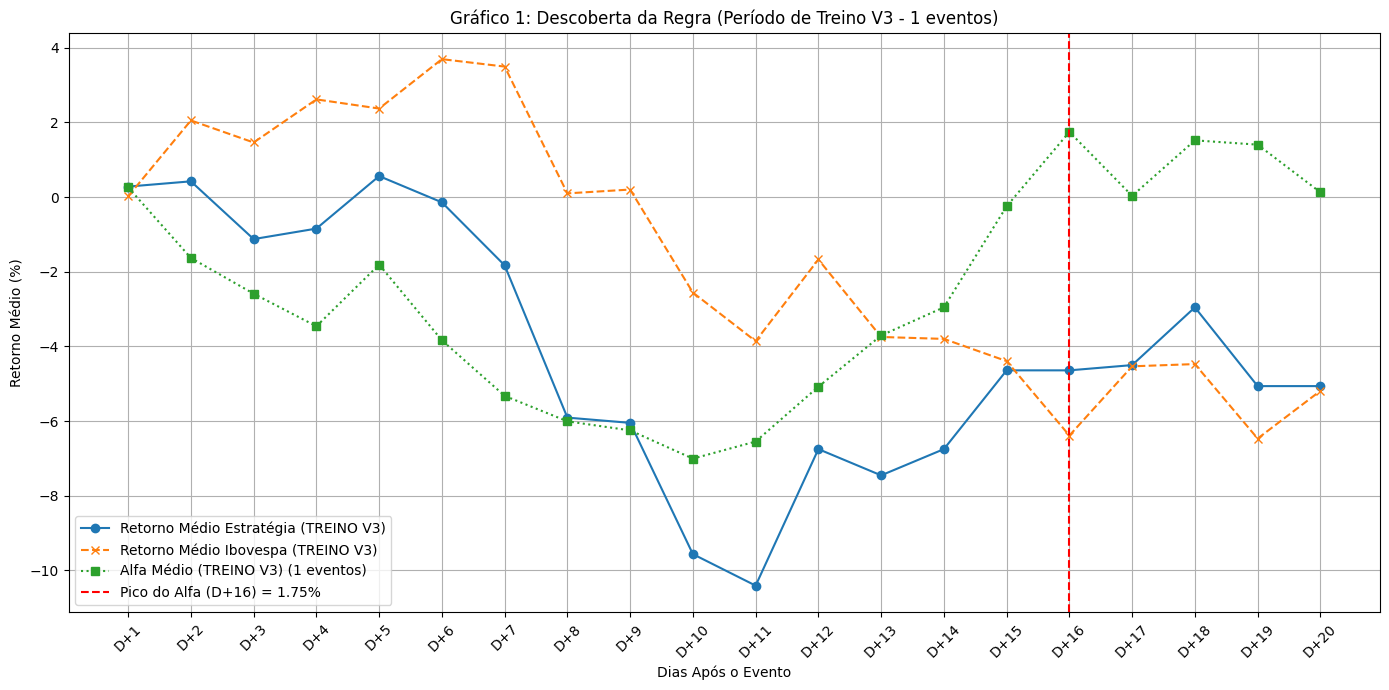


Gerando Gráfico 2: Teste de Robustez (Treino vs. Teste V3)...


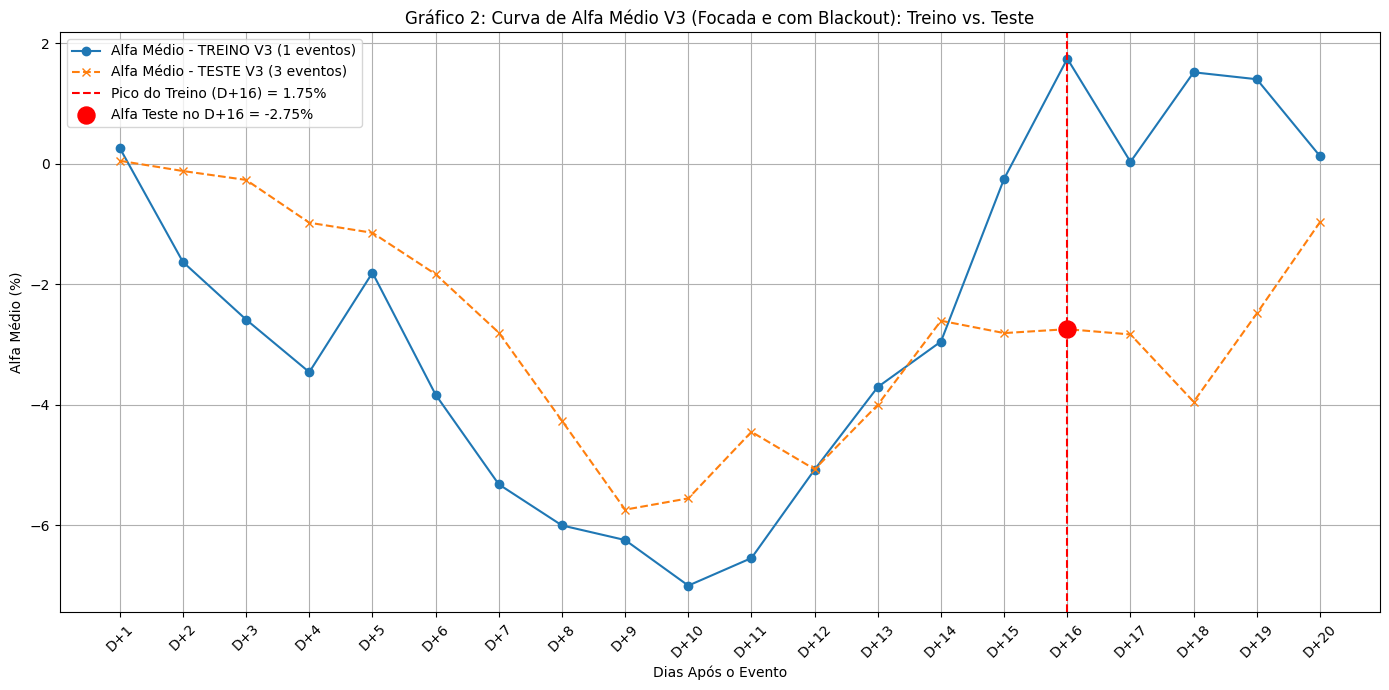

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from gnews import GNews
import json
import os
import google.generativeai as genai
from google.colab import userdata
import re

# Configurações do Pandas
pd.set_option('display.max_rows', None); pd.set_option('display.max_columns', None); pd.set_option('display.width', 2000); pd.set_option('display.max_colwidth', None)

# --------------------------------------------------------------------------
# ETAPA 1: CONFIGURAÇÃO DO ESTUDO DE EVENTOS (V3)
# --------------------------------------------------------------------------
try:
    GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
    genai.configure(api_key=GEMINI_API_KEY)
except Exception as e:
    print("ERRO: Não foi possível carregar a chave 'GEMINI_API_KEY'. Verifique se ela foi criada nos Secrets do Colab.")
    exit()

MODELO_GEMINI = genai.GenerativeModel('models/gemini-2.5-flash-lite')

# --- PARÂMETROS DE CONTROLE DE API ---
RPM_LIMIT = 12
# *** MUDANÇA (Seu pedido) ***
TOTAL_API_CALL_LIMIT = 900
SLEEP_TIME_SECONDS = 60 / RPM_LIMIT

# --- PARÂMETROS DO ESTUDO ---
data_inicio = '2015-01-01'
data_fim = '2024-12-31'
DIAS_DE_ANALISE = 20
DATA_CORTE_TREINO_TESTE = '2021-12-31'

# *** MUDANÇA (V3 - Universo Expandido) ***
# Viés de Sobrevivência (LIMITAÇÃO): Esta lista é fixa e sofre de viés de sobrevivência.
# Mas agora é um universo maior (21 empresas) para aumentar a amostra de eventos.
universo_investimento = [
    # Originais
    'PETR4.SA', 'VALE3.SA', 'SUZB3.SA', 'AMBP3.SA', 'ELET3.SA', 'RAIZ4.SA',
    # Adições V3 (Foco ISE/IBOV - Indústria, Bens, Utilities, Bancos)
    'WEGE3.SA', 'NATU3.SA', 'MGLU3.SA', 'LREN3.SA', 'KLBN4.SA', 'JBSS3.SA',
    'MRFG3.SA', 'BEEF3.SA', 'SBSP3.SA', 'EQTL3.SA', 'CPLE6.SA', 'ITUB4.SA',
    'BBDC4.SA', 'SANB11.SA', 'BBAS3.SA'
]

mapa_tickers_para_nomes = {
    # Originais
    'PETR4.SA': 'Petrobras', 'VALE3.SA': 'Vale', 'SUZB3.SA': 'Suzano',
    'AMBP3.SA': 'Ambipar', 'ELET3.SA': 'Eletrobras', 'RAIZ4.SA': 'Raízen',
    # Adições V3
    'WEGE3.SA': 'Weg', 'NATU3.SA': 'Natura', 'MGLU3.SA': 'Magazine Luiza',
    'LREN3.SA': 'Lojas Renner', 'KLBN4.SA': 'Klabin', 'JBSS3.SA': 'JBS',
    'MRFG3.SA': 'Marfrig', 'BEEF3.SA': 'Minerva', 'SBSP3.SA': 'Sabesp',
    'EQTL3.SA': 'Equatorial', 'CPLE6.SA': 'Copel', 'ITUB4.SA': 'Itaú Unibanco',
    'BBDC4.SA': 'Bradesco', 'SANB11.SA': 'Santander', 'BBAS3.SA': 'Banco do Brasil'
}


# Keywords V2 (Focada) - Mantemos a tese
keywords_busca_focada = ['crédito de carbono', 'energia renovável', 'hidrogênio verde',
                       'green bond', 'contrato de energia', 'descarbonização',
                       'joint venture sustentável', 'investimento ESG']

# *** MUDANÇA (V3) ***
NOME_ARQUIVO_CACHE = 'eventos_gemini_gnews_cache_V3_EXPANDIDO.json' # Novo arquivo de cache


# --------------------------------------------------------------------------
# ETAPA 2: FUNÇÕES DE COLETA E CLASSIFICAÇÃO COM IA
# (Mantemos o Prompt V2 'Focado', sem alterações)
# --------------------------------------------------------------------------
def buscar_dados_acoes(tickers, start, end):
    # (Função sem alteração)
    print(f"Baixando dados de preços de {start} a {end}...")
    try:
        tickers_com_ibov = tickers + ['^BVSP']
        dados = yf.download(tickers_com_ibov, start=start, end=end)
        dados.sort_index(inplace=True)
        if dados.empty:
            print("Nenhum dado de preço foi baixado."); return None
        print("Download de preços concluído.")
        return dados
    except Exception as e:
        print(f"Ocorreu um erro ao baixar os dados de preços: {e}"); return None

def classificar_manchete_com_gemini(manchete, api_counter):
    if api_counter['count'] >= api_counter['limit']:
        print("  - Limite total de chamadas de API atingido nesta execução. Parando a classificação.")
        return None

    prompt = f"""
    Analise a seguinte manchete de notícia.
    A manchete reporta um ANÚNCIO FINANCEIRO CONCRETO (ex: R$ 500 milhões, € 100M, US$ 1 Bi)
    ou uma PARCERIA ESTRATÉGICA (ex: joint-venture, contrato de longo prazo)
    de uma empresa, especificamente relacionado a sustentabilidade, ESG ou descarbonização?

    - Notícias sobre "ganhou prêmio ESG", "é líder em sustentabilidade" ou "divulgou relatório" NÃO contam.
    - Foque apenas em investimentos, contratos, aquisições ou emissão de dívida (green bonds) novos e concretos.

    Responda APENAS com 'SIM' ou 'NÃO'.
    Manchete: "{manchete}"
    """
    max_tentativas = 3
    for tentativa in range(max_tentativas):
        try:
            api_counter['count'] += 1
            print(f"  - Chamada à API #{api_counter['count']}/{api_counter['limit']}...")
            response = MODELO_GEMINI.generate_content(prompt)
            if response.candidates and response.candidates[0].content.parts:
                return "SIM" in response.text.strip().upper()
            else:
                 print("  - Resposta da API vazia ou bloqueada. Classificando como NÃO.")
                 return False
        except Exception as e:
            error_message = str(e); print(f"  - Erro na API do Gemini (tentativa {tentativa + 1}): {error_message}")
            if '429' in error_message:
                 match = re.search(r"retry in (\d+\.\d+)s", error_message)
                 tempo_espera_sugerido = float(match.group(1)) + 1 if match else 10.0
                 print(f"  - Limite de RPM/Quota atingido. Aguardando {tempo_espera_sugerido:.2f}s...")
                 time.sleep(tempo_espera_sugerido)
                 api_counter['count'] -= 1
                 continue
            time.sleep(5)
    print(f"  - Falha ao classificar após {max_tentativas} tentativas. Classificando como NÃO.")
    return False


def construir_cache_de_eventos(tickers_validos, nomes_mapa, start_str, end_str):
    print(f"\nIniciando 'Caça aos Sinais' (V3 - Universo Expandido)...")
    eventos_encontrados = []; ultimo_ano_processado = 0

    if os.path.exists(NOME_ARQUIVO_CACHE):
        try:
            with open(NOME_ARQUIVO_CACHE, 'r', encoding='utf-8') as f:
                cache_antigo = json.load(f)
                eventos_encontrados = cache_antigo.get('eventos', [])
                meta_cache = cache_antigo.get('metadata', {})

                # Verifica se os parâmetros do cache são os mesmos
                cache_keywords = meta_cache.get('keywords')
                cache_tickers = meta_cache.get('tickers')
                cache_data_fim = meta_cache.get('data_fim_cache')

                # Compara listas (ordem não importa)
                tickers_match = set(cache_tickers) == set(tickers_validos) if cache_tickers else False
                keywords_match = set(cache_keywords) == set(keywords_busca_focada) if cache_keywords else False

                if cache_data_fim == end_str and keywords_match and tickers_match:
                     print(f"Cache V3 encontrado e completo. Carregando eventos locais.")
                     return eventos_encontrados

                # Se o cache não for 100% compatível, mas tiver progresso, usa
                if keywords_match and tickers_match:
                    ultimo_ano_processado = meta_cache.get('ultimo_ano_processado', 0)
                    print(f"Progresso carregado. Continuando a partir de {ultimo_ano_processado + 1}.")
                else:
                    print("Cache V3 incompatível (parâmetros mudaram). Reiniciando a busca...")
                    eventos_encontrados = [] # Zera os eventos
                    ultimo_ano_processado = 0 # Zera o progresso
        except Exception as e:
            print(f"Erro ao ler o cache: {e}. Reiniciando a busca...")
            eventos_encontrados = []
            ultimo_ano_processado = 0

    api_counter = {'count': 0, 'limit': TOTAL_API_CALL_LIMIT}
    start_date = datetime.datetime.strptime(start_str, '%Y-%m-%d'); end_date = datetime.datetime.strptime(end_str, '%Y-%m-%d')
    ano_de_inicio = ultimo_ano_processado + 1 if ultimo_ano_processado > 0 and ultimo_ano_processado >= start_date.year else start_date.year

    for year in range(ano_de_inicio, end_date.year + 1):
        if api_counter['count'] >= api_counter['limit']: break
        print(f"\n===== PROCESSANDO ANO: {year} =====")

        start_date_year = datetime.date(year, 1, 1)
        end_date_year = datetime.date(year, 12, 31)
        if year == start_date.year: start_date_year = start_date.date()
        if year == end_date.year: end_date_year = end_date.date()

        google_news = GNews(language='pt', country='BR', start_date=start_date_year, end_date=end_date_year)

        for ticker in tickers_validos:
            if api_counter['count'] >= api_counter['limit']: break
            nome_empresa = nomes_mapa.get(ticker)
            if not nome_empresa: continue
            print(f"--- Buscando notícias para {nome_empresa} ({year}) ---")

            try:
                query = f'"{nome_empresa}" AND ({ " OR ".join(keywords_busca_focada) })';
                noticias = google_news.get_news(query);
                time.sleep(1)
            except Exception as e:
                print(f"  - Erro ao buscar no GNews: {e}. Pulando {nome_empresa} para este ano.")
                noticias = []
                time.sleep(10)

            if noticias:
                print(f"  -> {len(noticias)} notícias encontradas. Classificando...")
                for n in noticias:
                    if nome_empresa.lower() in n['title'].lower():
                        resultado = classificar_manchete_com_gemini(n['title'], api_counter)
                        if resultado is None: api_counter['count'] = api_counter['limit']; break

                        if resultado:
                            data_obj_str = datetime.datetime.strptime(n['published date'], '%a, %d %b %Y %H:%M:%S GMT').strftime('%Y-%m-%d')
                            eventos_encontrados.append({'Data': data_obj_str, 'Ticker': ticker, 'Manchete': n['title']})
                            print(f"  >>> SINAL V3 ENCONTRADO: {data_obj_str} - {ticker}")

                        time.sleep(SLEEP_TIME_SECONDS)
            time.sleep(1)

        # Salva o progresso ao final de cada ano
        df_eventos_parcial = pd.DataFrame(eventos_encontrados);
        df_eventos_parcial.drop_duplicates(subset=['Data', 'Ticker'], inplace=True)
        eventos_unicos = df_eventos_parcial.to_dict('records')

        meta_data_cache = {
            'ultimo_ano_processado': year,
            'data_fim_cache': end_str if year == end_date.year else f"{year}-12-31",
            'total_eventos': len(eventos_unicos),
            'keywords': keywords_busca_focada,
            'tickers': tickers_validos # Salva o universo usado no cache
        }

        cache_conteudo = {'metadata': meta_data_cache, 'eventos': eventos_unicos}
        with open(NOME_ARQUIVO_CACHE, 'w', encoding='utf-8') as f:
            json.dump(cache_conteudo, f, ensure_ascii=False, indent=4)
        print(f"Progresso salvo. {len(eventos_unicos)} eventos totais no cache.")

    if api_counter['count'] < api_counter['limit']:
        print(f"\nBusca V3 concluída para todo o período (até {end_str})!")
    else:
        print("\nLimite de API atingido. Rode novamente no dia seguinte para continuar.")

    df_final = pd.DataFrame(eventos_encontrados)
    df_final.drop_duplicates(subset=['Data', 'Ticker'], inplace=True)
    return df_final.to_dict('records')


# --------------------------------------------------------------------------
# ETAPA 3: FUNÇÃO DE ANÁLISE DE EVENTOS (COM BLACKOUT)
# (Sem alterações. A lógica de Blackout V2 é mantida)
# --------------------------------------------------------------------------
def executar_estudo_de_eventos(eventos, dados_acoes):
    print(f"\nIniciando estudo de eventos para {len(eventos)} eventos (com Blackout)...")
    resultados = []
    dados_acoes.index = pd.to_datetime(dados_acoes.index)
    ticker_blackout_until = {}

    for evento in eventos:
        ticker = evento['Ticker']
        if ticker not in dados_acoes['Open'].columns:
            continue

        try:
            data_evento = pd.to_datetime(evento['Data'])
        except Exception as e:
            print(f"Aviso: Data inválida no evento {evento}. Erro: {e}. Pulando.")
            continue

        # --- LÓGICA DE BLACKOUT ---
        data_fim_blackout_anterior = ticker_blackout_until.get(ticker)
        if data_fim_blackout_anterior and data_evento <= data_fim_blackout_anterior:
            # print(f"  -> Evento IGNORADO (Blackout): {data_evento.date()} para {ticker}.") # Opcional: remover print para poluir menos
            continue
        # --- FIM DA LÓGICA DE BLACKOUT ---

        dias_de_negociacao = dados_acoes.index[dados_acoes.index > data_evento]

        if len(dias_de_negociacao) < DIAS_DE_ANALISE:
            continue

        data_compra = dias_de_negociacao[0]
        preco_entrada_ativo = dados_acoes.loc[data_compra, ('Open', ticker)]
        preco_entrada_ibov = dados_acoes.loc[data_compra, ('Open', '^BVSP')]

        if pd.isna(preco_entrada_ativo) or preco_entrada_ativo == 0 or pd.isna(preco_entrada_ibov) or preco_entrada_ibov == 0:
            continue

        dias_analise = dias_de_negociacao[0:DIAS_DE_ANALISE]
        data_fim_estudo_atual = dias_analise[-1]
        ticker_blackout_until[ticker] = data_fim_estudo_atual

        resultado_linha = {'Data_Evento': data_evento.date(), 'Ticker': ticker, 'Manchete': evento['Manchete']}

        for i, dia_fechamento in enumerate(dias_analise):
            preco_fechamento_ativo = dados_acoes.loc[dia_fechamento, ('Close', ticker)]
            preco_fechamento_ibov = dados_acoes.loc[dia_fechamento, ('Close', '^BVSP')]

            if pd.isna(preco_fechamento_ativo):
                preco_fechamento_ativo = dados_acoes.loc[:dia_fechamento, ('Close', ticker)].ffill().iloc[-1]
            if pd.isna(preco_fechamento_ibov):
                preco_fechamento_ibov = dados_acoes.loc[:dia_fechamento, ('Close', '^BVSP')].ffill().iloc[-1]

            retorno_ativo = (preco_fechamento_ativo / preco_entrada_ativo) - 1
            retorno_ibov = (preco_fechamento_ibov / preco_entrada_ibov) - 1

            resultado_linha[f'D+{i+1}_Ativo'] = retorno_ativo
            resultado_linha[f'D+{i+1}_Ibov'] = retorno_ibov

        resultados.append(resultado_linha)

    print(f"Estudo de eventos (Blackout) concluído. {len(resultados)} simulações válidas geradas.")
    return pd.DataFrame(resultados)

# --------------------------------------------------------------------------
# ETAPA 4: ORQUESTRAÇÃO E DIVISÃO TREINO/TESTE
# --------------------------------------------------------------------------

# 1. Carrega ou constrói o cache de eventos (V3)
eventos_total = construir_cache_de_eventos(list(mapa_tickers_para_nomes.keys()), mapa_tickers_para_nomes, data_inicio, data_fim)

if not eventos_total:
    print("\nNenhum evento relevante (V3) foi encontrado. A análise não pode continuar.")
else:
    # 2. Baixa os dados de ações (V3)
    dados_acoes_total = buscar_dados_acoes(universo_investimento, data_inicio, data_fim)

    if dados_acoes_total is not None and not dados_acoes_total.empty:

        # 3. Divisão dos eventos (lógica mantida)
        print(f"\nDividindo eventos em Treino (até {DATA_CORTE_TREINO_TESTE}) e Teste (após {DATA_CORTE_TREINO_TESTE})...")

        eventos_treino = [e for e in eventos_total if e['Data'] <= DATA_CORTE_TREINO_TESTE]
        eventos_teste = [e for e in eventos_total if e['Data'] > DATA_CORTE_TREINO_TESTE]

        # Ordena as listas de eventos por data (essencial para o Blackout)
        eventos_treino.sort(key=lambda x: pd.to_datetime(x['Data']))
        eventos_teste.sort(key=lambda x: pd.to_datetime(x['Data']))

        print(f"Total de eventos V3 encontrados: {len(eventos_total)}")
        print(f"Eventos de Treino (In-Sample): {len(eventos_treino)}")
        print(f"Eventos de Teste (Out-of-Sample): {len(eventos_teste)}")

        # 4. Executa o estudo de eventos (lógica mantida)
        df_resultados_treino = pd.DataFrame()
        df_resultados_teste = pd.DataFrame()

        if eventos_treino:
            df_resultados_treino = executar_estudo_de_eventos(eventos_treino, dados_acoes_total)
        if eventos_teste:
            df_resultados_teste = executar_estudo_de_eventos(eventos_teste, dados_acoes_total)

# --------------------------------------------------------------------------
# ETAPA 5: ANÁLISE DE ROBUSTEZ E GRÁFICOS (V3)
# --------------------------------------------------------------------------
        print("\n--- ANÁLISE DE ROBUSTEZ (TREINO vs TESTE) V3 ---")

        if df_resultados_treino.empty:
            print("Nenhum resultado válido no período de Treino. A análise não pode continuar.")
        else:
            # 5.1. Analisa o período de TREINO
            print("\nAnalisando Período de Treino (In-Sample)...")
            df_retornos_ativo_treino = df_resultados_treino.filter(regex=r'_Ativo$')
            df_retornos_ibov_treino = df_resultados_treino.filter(regex=r'_Ibov$')

            df_retornos_ativo_treino.columns = [f'D+{i+1}' for i in range(DIAS_DE_ANALISE)]
            df_retornos_ibov_treino.columns = [f'D+{i+1}' for i in range(DIAS_DE_ANALISE)]

            retorno_medio_ativo_treino = df_retornos_ativo_treino.mean()
            retorno_medio_ibov_treino = df_retornos_ibov_treino.mean()
            retorno_alpha_treino = retorno_medio_ativo_treino - retorno_medio_ibov_treino

            dia_do_pico_alpha_treino = retorno_alpha_treino.idxmax()
            valor_pico_alpha_treino = retorno_alpha_treino.max()

            print(f"Pico de Alfa (Treino) ocorre no: {dia_do_pico_alpha_treino}")
            print(f"Alfa médio no pico (Treino): {valor_pico_alpha_treino:.2%}")

            # 5.2. Analisa o período de TESTE
            print("\nAnalisando Período de Teste (Out-of-Sample)...")
            retorno_alpha_teste = pd.Series(dtype=float) # Inicia série vazia
            alpha_teste_no_pico_treino = np.nan # Inicia como NaN

            if not df_resultados_teste.empty:
                df_retornos_ativo_teste = df_resultados_teste.filter(regex=r'_Ativo$')
                df_retornos_ibov_teste = df_resultados_teste.filter(regex=r'_Ibov$')

                df_retornos_ativo_teste.columns = [f'D+{i+1}' for i in range(DIAS_DE_ANALISE)]
                df_retornos_ibov_teste.columns = [f'D+{i+1}' for i in range(DIAS_DE_ANALISE)]

                retorno_medio_ativo_teste = df_retornos_ativo_teste.mean()
                retorno_medio_ibov_teste = df_retornos_ibov_teste.mean()
                retorno_alpha_teste = retorno_medio_ativo_teste - retorno_medio_ibov_teste

                alpha_teste_no_pico_treino = retorno_alpha_teste.get(dia_do_pico_alpha_treino, np.nan)

            if pd.isna(alpha_teste_no_pico_treino):
                 print(f"Aviso: O dia do pico do treino ({dia_do_pico_alpha_treino}) não foi encontrado nos resultados do teste ou teste está vazio.")
                 alpha_teste_no_pico_treino = 0

            print(f"Alfa médio no período de Teste (no dia do pico do Treino, {dia_do_pico_alpha_treino}): {alpha_teste_no_pico_treino:.2%}")

            # 5.3. Apresenta o Resumo Comparativo
            print("\n--- RESUMO COMPARATIVO (Alfa Médio no dia do Pico do Treino) ---")
            print(f"{'Período':<10} | {'Alfa Médio':<10} |")
            print("-" * 25)
            print(f"{'Treino':<10} | {valor_pico_alpha_treino:>9.2%} |")
            print(f"{'Teste':<10} | {alpha_teste_no_pico_treino:>9.2%} |")

            # 5.4. Salva tudo em Excel
            nome_arquivo_excel = 'Analise_de_Eventos_TREINO_TESTE_V3_EXPANDIDO.xlsx'
            with pd.ExcelWriter(nome_arquivo_excel, engine='openpyxl') as writer:
                df_resultados_treino.to_excel(writer, sheet_name='Eventos_Treino_Raw', index=False)
                if not df_resultados_teste.empty:
                    df_resultados_teste.to_excel(writer, sheet_name='Eventos_Teste_Raw', index=False)

                resumo_data = {
                    'Periodo': ['Treino', 'Teste'],
                    f'Alfa_no_{dia_do_pico_alpha_treino}': [valor_pico_alpha_treino, alpha_teste_no_pico_treino]
                }
                pd.DataFrame(resumo_data).to_excel(writer, sheet_name='Resumo_Pico_Treino', index=False)

                # Salva as 3 séries do treino
                retorno_medio_ativo_treino.to_frame(name='Ret_Ativo_Treino').to_excel(writer, sheet_name='Medias_Treino')
                retorno_medio_ibov_treino.to_frame(name='Ret_Ibov_Treino').to_excel(writer, sheet_name='Medias_Treino', startcol=3)
                retorno_alpha_treino.to_frame(name='Alfa_Treino').to_excel(writer, sheet_name='Medias_Treino', startcol=6)

            print(f"\nResultados detalhados (V3) exportados para '{nome_arquivo_excel}'")

            # 5.5. Gera os Gráficos de Análise

            # *** MUDANÇA (Gráfico 1 - Detalhes do Treino) ***
            print("\nGerando Gráfico 1: Análise do Período de Treino (V3)...")
            plt.figure(figsize=(14, 7))
            plt.plot(retorno_medio_ativo_treino.index, retorno_medio_ativo_treino.values * 100,
                     marker='o', linestyle='-', label=f'Retorno Médio Estratégia (TREINO V3)')
            plt.plot(retorno_medio_ibov_treino.index, retorno_medio_ibov_treino.values * 100,
                     marker='x', linestyle='--', label=f'Retorno Médio Ibovespa (TREINO V3)')
            plt.plot(retorno_alpha_treino.index, retorno_alpha_treino.values * 100,
                     marker='s', linestyle=':', label=f'Alfa Médio (TREINO V3) ({len(df_resultados_treino)} eventos)')

            plt.title(f'Gráfico 1: Descoberta da Regra (Período de Treino V3 - {len(df_resultados_treino)} eventos)')
            plt.xlabel('Dias Após o Evento'); plt.ylabel('Retorno Médio (%)')
            plt.axvline(x=dia_do_pico_alpha_treino, color='r', linestyle='--',
                        label=f'Pico do Alfa ({dia_do_pico_alpha_treino}) = {valor_pico_alpha_treino:.2%}')
            plt.grid(True); plt.legend(); plt.xticks(rotation=45); plt.tight_layout(); plt.show()


            # *** MUDANÇA (Gráfico 2 - Teste de Robustez) ***
            print("\nGerando Gráfico 2: Teste de Robustez (Treino vs. Teste V3)...")
            plt.figure(figsize=(14, 7))

            # Linha do Alfa Treino
            plt.plot(retorno_alpha_treino.index, retorno_alpha_treino.values * 100,
                     marker='o', linestyle='-', label=f'Alfa Médio - TREINO V3 ({len(df_resultados_treino)} eventos)')

            # Linha do Alfa Teste (se existirem)
            if not retorno_alpha_teste.empty:
                plt.plot(retorno_alpha_teste.index, retorno_alpha_teste.values * 100,
                         marker='x', linestyle='--', label=f'Alfa Médio - TESTE V3 ({len(df_resultados_teste)} eventos)')

            plt.title('Gráfico 2: Curva de Alfa Médio V3 (Focada e com Blackout): Treino vs. Teste')
            plt.xlabel('Dias Após o Evento'); plt.ylabel('Alfa Médio (%)')
            plt.axvline(x=dia_do_pico_alpha_treino, color='r', linestyle='--',
                        label=f'Pico do Treino ({dia_do_pico_alpha_treino}) = {valor_pico_alpha_treino:.2%}')

            if not retorno_alpha_teste.empty:
                plt.scatter(dia_do_pico_alpha_treino, alpha_teste_no_pico_treino * 100,
                            s=150, color='red', zorder=5,
                            label=f'Alfa Teste no {dia_do_pico_alpha_treino} = {alpha_teste_no_pico_treino:.2%}')

            plt.grid(True); plt.legend(); plt.xticks(rotation=45); plt.tight_layout(); plt.show()

    else:
        print("\nDownload dos dados de ações falhou. A análise não pode continuar.")

tentativa de mitigação de vieses

#Versão final

/tmp/ipython-input-176537226.py:60: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dados = yf.download(tickers_com_ibov, start=start, end=end)
[********************* 43%                       ]  3 of 7 completed


Iniciando 'Caça aos Sinais' (V4 - Tese Ampla)...
Cache V4 encontrado e completo. Carregando eventos locais.
Baixando dados de preços de 2015-01-01 a 2024-12-31...


[*********************100%***********************]  7 of 7 completed


Download de preços concluído.

Dividindo eventos em Treino (até 2021-12-31) e Teste (após 2021-12-31)...
Total de eventos V4 encontrados: 203
Eventos de Treino (In-Sample): 41
Eventos de Teste (Out-of-Sample): 162

Iniciando estudo de eventos para 41 eventos (com Blackout)...
Estudo de eventos (Blackout) concluído. 24 simulações válidas geradas.

Iniciando estudo de eventos para 162 eventos (com Blackout)...
Estudo de eventos (Blackout) concluído. 84 simulações válidas geradas.

--- ANÁLISE DE ROBUSTEZ (TREINO vs TESTE) V5 ---

Analisando Período de Treino (In-Sample)...
Pico de Alfa (Treino) ocorre no: D+12
Alfa médio no pico (Treino): 5.49%

Analisando Período de Teste (Out-of-Sample)...
Alfa médio no período de Teste (no dia D+12): -0.27%

--- RESUMO COMPARATIVO (Alfa Médio no dia do Pico do Treino) ---
Período    | Alfa Médio |
-------------------------
Treino     |     5.49% |
Teste      |    -0.27% |

--- SIMULAÇÃO FINANCEIRA (Período de Teste) ---
Regra da Estratégia: Comprar no

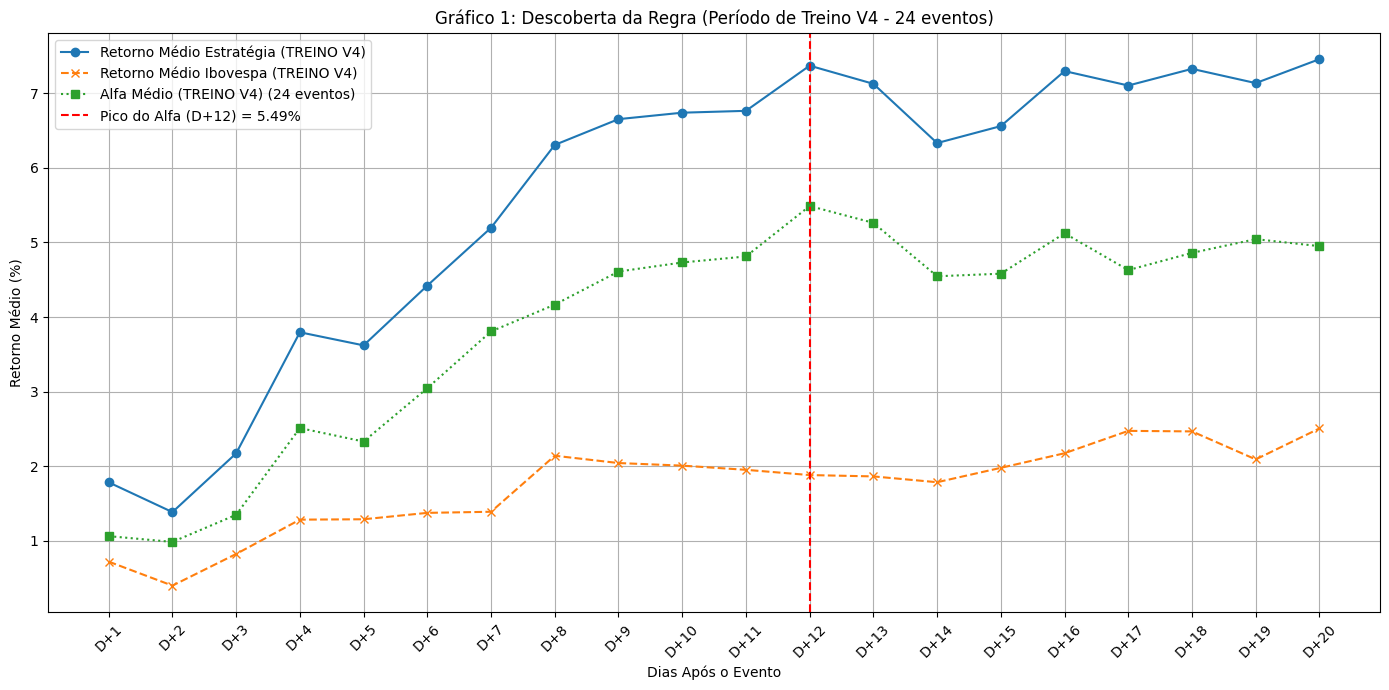


Gerando Gráfico 2: Teste de Robustez (Treino vs. Teste V4)...


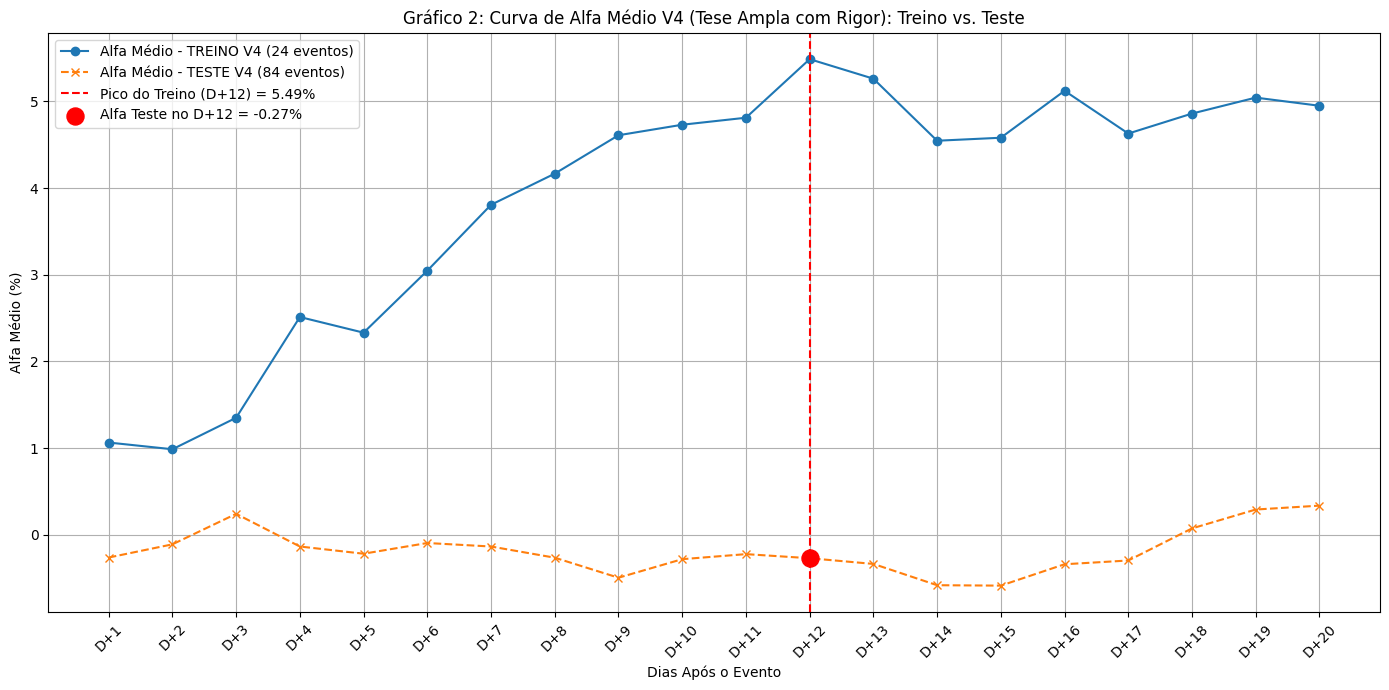

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from gnews import GNews
import json
import os
import google.generativeai as genai
from google.colab import userdata
import re

# Configurações do Pandas
pd.set_option('display.max_rows', None); pd.set_option('display.max_columns', None); pd.set_option('display.width', 2000); pd.set_option('display.max_colwidth', None)

# --------------------------------------------------------------------------
# ETAPA 1: CONFIGURAÇÃO DO ESTUDO DE EVENTOS (V5)
# --------------------------------------------------------------------------
try:
    GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
    genai.configure(api_key=GEMINI_API_KEY)
except Exception as e:
    print("ERRO: Não foi possível carregar a chave 'GEMINI_API_KEY'. Verifique se ela foi criada nos Secrets do Colab.")
    exit()

# *** MUDANÇA (Correção de Erro 404) ***

MODELO_GEMINI = genai.GenerativeModel('models/gemini-2.5-flash-lite')

# --- PARÂMETROS DE CONTROLE DE API ---
RPM_LIMIT = 6 # 1 chamada a cada 10 segundos. Bem conservador.
TOTAL_API_CALL_LIMIT = 900
SLEEP_TIME_SECONDS = 60 / RPM_LIMIT

# --- PARÂMETROS DO ESTUDO ---
data_inicio = '2015-01-01'
data_fim = '2024-12-31'
DIAS_DE_ANALISE = 20
DATA_CORTE_TREINO_TESTE = '2021-12-31'

# *** TESE V1 (AMPLA) - Mantida ***
universo_investimento = ['PETR4.SA', 'VALE3.SA', 'SUZB3.SA', 'AMBP3.SA', 'ELET3.SA', 'RAIZ4.SA']
mapa_tickers_para_nomes = {
    'PETR4.SA': 'Petrobras', 'VALE3.SA': 'Vale', 'SUZB3.SA': 'Suzano',
    'AMBP3.SA': 'Ambipar', 'ELET3.SA': 'Eletrobras', 'RAIZ4.SA': 'Raízen'
}
keywords_busca_ampla = ['sustentabilidade', 'ESG', 'crédito de carbono', 'meio ambiente', 'energia renovável']
NOME_ARQUIVO_CACHE = 'eventos_gemini_gnews_cache_V4_AMPLA_COM_RIGOR.json'


# --------------------------------------------------------------------------
# ETAPA 2: FUNÇÕES DE COLETA E CLASSIFICAÇÃO COM IA (MAIS ROBUSTA)
# --------------------------------------------------------------------------
def buscar_dados_acoes(tickers, start, end):
    # (Função sem alteração)
    print(f"Baixando dados de preços de {start} a {end}...")
    try:
        tickers_com_ibov = tickers + ['^BVSP']
        dados = yf.download(tickers_com_ibov, start=start, end=end)
        dados.sort_index(inplace=True)
        if dados.empty:
            print("Nenhum dado de preço foi baixado."); return None
        print("Download de preços concluído.")
        return dados
    except Exception as e:
        print(f"Ocorreu um erro ao baixar os dados de preços: {e}"); return None

def classificar_manchete_com_gemini(manchete, api_counter):
    # (Este é o Prompt V1 Amplo - mantido)
    if api_counter['count'] >= api_counter['limit']:
        print("  - Limite total de chamadas de API atingido nesta execução. Parando a classificação.")
        return None

    prompt = f"""
    Analise a seguinte manchete de notícia. A manchete reporta um novo e concreto investimento, contrato, certificação, ou iniciativa positiva de uma empresa no setor de 'carbono verde', sustentabilidade ou descarbonização?
    Responda APENAS com 'SIM' ou 'NÃO'.
    Manchete: "{manchete}"
    """
    max_tentativas = 3 # Tenta 3 vezes antes de desistir
    for tentativa in range(max_tentativas):
        try:
            api_counter['count'] += 1
            print(f"  - Chamada à API #{api_counter['count']}/{api_counter['limit']} (Tentativa {tentativa + 1})...")
            response = MODELO_GEMINI.generate_content(prompt)
            if response.candidates and response.candidates[0].content.parts:
                return "SIM" in response.text.strip().upper()
            else:
                 print("  - Resposta da API vazia ou bloqueada. Classificando como NÃO.")
                 return False

        # *** MUDANÇA (Tratamento de Erro Robusto) ***
        # Agora lidamos com 429 (Rate Limit) e 503 (Servidor Ocupado)
        except Exception as e:
            error_message = str(e)
            print(f"  - Erro na API do Gemini (tentativa {tentativa + 1}): {error_message[:150]}...") # Mostra só o início do erro

            # 1. Se for erro de "Muitas Requisições" (429)
            if '429' in error_message:
                match = re.search(r"retry in (\d+\.\d+)s", error_message)
                tempo_espera_sugerido = float(match.group(1)) + 1 if match else 10.0
                print(f"  - Limite de RPM/Quota (429) atingido. Aguardando {tempo_espera_sugerido:.2f}s...")
                time.sleep(tempo_espera_sugerido)
                api_counter['count'] -= 1 # Decrementa para tentar esta chamada novamente
                continue # Pula para a próxima tentativa

            # 2. Se for erro de "Serviço Indisponível" (503)
            if '503' in error_message:
                tempo_espera_longa = 30 # Força uma espera mais longa (30 segundos)
                print(f"  - Servidor indisponível (503). Pode ser sobrecarga. Aguardando {tempo_espera_longa}s...")
                time.sleep(tempo_espera_longa)
                api_counter['count'] -= 1 # Decrementa para tentar esta chamada novamente
                continue # Pula para a próxima tentativa

            # 3. Se for erro de "Modelo Não Encontrado" (404)
            if '404' in error_message and 'is not found' in error_message:
                 print("ERRO CRÍTICO: O modelo da API não foi encontrado. Verifique o nome do modelo na ETAPA 1.")
                 return None # Desiste imediatamente

            # 4. Para outros erros, apenas espera e tenta de novo
            time.sleep(5)

    print(f"  - Falha ao classificar '{manchete[:50]}...' após {max_tentativas} tentativas. Classificando como NÃO.")
    return False


def construir_cache_de_eventos(tickers_validos, nomes_mapa, start_str, end_str):
    # (Função sem alteração)
    print(f"\nIniciando 'Caça aos Sinais' (V4 - Tese Ampla)...")
    eventos_encontrados = []; ultimo_ano_processado = 0

    if os.path.exists(NOME_ARQUIVO_CACHE):
        try:
            with open(NOME_ARQUIVO_CACHE, 'r', encoding='utf-8') as f:
                cache_antigo = json.load(f)
                eventos_encontrados = cache_antigo.get('eventos', [])
                meta_cache = cache_antigo.get('metadata', {})

                cache_keywords = meta_cache.get('keywords')
                cache_tickers = meta_cache.get('tickers')
                cache_data_fim = meta_cache.get('data_fim_cache')

                tickers_match = set(cache_tickers) == set(tickers_validos) if cache_tickers else False
                keywords_match = set(cache_keywords) == set(keywords_busca_ampla) if cache_keywords else False

                if cache_data_fim == end_str and keywords_match and tickers_match:
                     print(f"Cache V4 encontrado e completo. Carregando eventos locais.")
                     return eventos_encontrados

                if keywords_match and tickers_match:
                    ultimo_ano_processado = meta_cache.get('ultimo_ano_processado', 0)
                    print(f"Progresso carregado. Continuando a partir de {ultimo_ano_processado + 1}.")
                else:
                    print("Cache V4 incompatível (parâmetros mudaram). Reiniciando a busca...")
                    eventos_encontrados = []
                    ultimo_ano_processado = 0
        except Exception as e:
            print(f"Erro ao ler o cache: {e}. Reiniciando a busca...")
            eventos_encontrados = []
            ultimo_ano_processado = 0

    api_counter = {'count': 0, 'limit': TOTAL_API_CALL_LIMIT}
    start_date = datetime.datetime.strptime(start_str, '%Y-%m-%d'); end_date = datetime.datetime.strptime(end_str, '%Y-%m-%d')
    ano_de_inicio = ultimo_ano_processado + 1 if ultimo_ano_processado > 0 and ultimo_ano_processado >= start_date.year else start_date.year

    for year in range(ano_de_inicio, end_date.year + 1):
        if api_counter['count'] >= api_counter['limit']: break
        print(f"\n===== PROCESSANDO ANO: {year} =====")

        start_date_year = datetime.date(year, 1, 1)
        end_date_year = datetime.date(year, 12, 31)
        if year == start_date.year: start_date_year = start_date.date()
        if year == end_date.year: end_date_year = end_date.date()

        google_news = GNews(language='pt', country='BR', start_date=start_date_year, end_date=end_date_year)

        for ticker in tickers_validos:
            if api_counter['count'] >= api_counter['limit']: break
            nome_empresa = nomes_mapa.get(ticker)
            if not nome_empresa: continue
            print(f"--- Buscando notícias para {nome_empresa} ({year}) ---")

            try:
                query = f'"{nome_empresa}" AND ({ " OR ".join(keywords_busca_ampla) })';
                noticias = google_news.get_news(query);
                time.sleep(1)
            except Exception as e:
                print(f"  - Erro ao buscar no GNews: {e}. Pulando {nome_empresa} para este ano.")
                noticias = []
                time.sleep(10)

            if noticias:
                print(f"  -> {len(noticias)} notícias encontradas. Classificando...")
                for n in noticias:
                    if nome_empresa.lower() in n['title'].lower():
                        resultado = classificar_manchete_com_gemini(n['title'], api_counter)
                        # Se a API falhar criticamente (ex: 404), 'resultado' será None e paramos tudo.
                        if resultado is None:
                            api_counter['count'] = api_counter['limit']
                            print("ERRO CRÍTICO DE API. Parando a busca.")
                            break

                        if resultado:
                            data_obj_str = datetime.datetime.strptime(n['published date'], '%a, %d %b %Y %H:%M:%S GMT').strftime('%Y-%m-%d')
                            eventos_encontrados.append({'Data': data_obj_str, 'Ticker': ticker, 'Manchete': n['title']})
                            print(f"  >>> SINAL V4 (Amplo) ENCONTRADO: {data_obj_str} - {ticker}")

                        time.sleep(SLEEP_TIME_SECONDS)
            time.sleep(1)

        # Salva o progresso ao final de cada ano
        df_eventos_parcial = pd.DataFrame(eventos_encontrados);
        df_eventos_parcial.drop_duplicates(subset=['Data', 'Ticker'], inplace=True)
        eventos_unicos = df_eventos_parcial.to_dict('records')

        meta_data_cache = {
            'ultimo_ano_processado': year,
            'data_fim_cache': end_str if year == end_date.year else f"{year}-12-31",
            'total_eventos': len(eventos_unicos),
            'keywords': keywords_busca_ampla,
            'tickers': tickers_validos
        }

        cache_conteudo = {'metadata': meta_data_cache, 'eventos': eventos_unicos}
        with open(NOME_ARQUIVO_CACHE, 'w', encoding='utf-8') as f:
            json.dump(cache_conteudo, f, ensure_ascii=False, indent=4)
        print(f"Progresso salvo. {len(eventos_unicos)} eventos totais no cache.")

    if api_counter['count'] < api_counter['limit']:
        print(f"\nBusca V4 concluída para todo o período (até {end_str})!")
    else:
        print("\nLimite de API atingido. Rode novamente no dia seguinte para continuar.")

    df_final = pd.DataFrame(eventos_encontrados)
    df_final.drop_duplicates(subset=['Data', 'Ticker'], inplace=True)
    return df_final.to_dict('records')


# --------------------------------------------------------------------------
# ETAPA 3: FUNÇÃO DE ANÁLISE DE EVENTOS (COM BLACKOUT)
# (Função sem alteração)
# --------------------------------------------------------------------------
def executar_estudo_de_eventos(eventos, dados_acoes):
    print(f"\nIniciando estudo de eventos para {len(eventos)} eventos (com Blackout)...")
    resultados = []
    dados_acoes.index = pd.to_datetime(dados_acoes.index)
    ticker_blackout_until = {}

    for evento in eventos:
        ticker = evento['Ticker']
        if ticker not in dados_acoes['Open'].columns:
            continue

        try:
            data_evento = pd.to_datetime(evento['Data'])
        except Exception as e:
            print(f"Aviso: Data inválida no evento {evento}. Erro: {e}. Pulando.")
            continue

        # --- LÓGICA DE BLACKOUT ---
        data_fim_blackout_anterior = ticker_blackout_until.get(ticker)
        if data_fim_blackout_anterior and data_evento <= data_fim_blackout_anterior:
            continue
        # --- FIM DA LÓGICA DE BLACKOUT ---

        dias_de_negociacao = dados_acoes.index[dados_acoes.index > data_evento]

        if len(dias_de_negociacao) < DIAS_DE_ANALISE:
            continue

        data_compra = dias_de_negociacao[0]
        preco_entrada_ativo = dados_acoes.loc[data_compra, ('Open', ticker)]
        preco_entrada_ibov = dados_acoes.loc[data_compra, ('Open', '^BVSP')]

        if pd.isna(preco_entrada_ativo) or preco_entrada_ativo == 0 or pd.isna(preco_entrada_ibov) or preco_entrada_ibov == 0:
            continue

        dias_analise = dias_de_negociacao[0:DIAS_DE_ANALISE]
        data_fim_estudo_atual = dias_analise[-1]
        ticker_blackout_until[ticker] = data_fim_estudo_atual

        resultado_linha = {'Data_Evento': data_evento.date(), 'Ticker': ticker, 'Manchete': evento['Manchete']}

        for i, dia_fechamento in enumerate(dias_analise):
            preco_fechamento_ativo = dados_acoes.loc[dia_fechamento, ('Close', ticker)]
            preco_fechamento_ibov = dados_acoes.loc[dia_fechamento, ('Close', '^BVSP')]

            if pd.isna(preco_fechamento_ativo):
                preco_fechamento_ativo = dados_acoes.loc[:dia_fechamento, ('Close', ticker)].ffill().iloc[-1]
            if pd.isna(preco_fechamento_ibov):
                preco_fechamento_ibov = dados_acoes.loc[:dia_fechamento, ('Close', '^BVSP')].ffill().iloc[-1]

            retorno_ativo = (preco_fechamento_ativo / preco_entrada_ativo) - 1
            retorno_ibov = (preco_fechamento_ibov / preco_entrada_ibov) - 1

            resultado_linha[f'D+{i+1}_Ativo'] = retorno_ativo
            resultado_linha[f'D+{i+1}_Ibov'] = retorno_ibov

        resultados.append(resultado_linha)

    print(f"Estudo de eventos (Blackout) concluído. {len(resultados)} simulações válidas geradas.")
    return pd.DataFrame(resultados)

# --------------------------------------------------------------------------
# ETAPA 4: ORQUESTRAÇÃO E DIVISÃO TREINO/TESTE
# (Função sem alteração)
# --------------------------------------------------------------------------

# 1. Carrega ou constrói o cache de eventos (V4)
eventos_total = construir_cache_de_eventos(list(mapa_tickers_para_nomes.keys()), mapa_tickers_para_nomes, data_inicio, data_fim)

if not eventos_total:
    print("\nNenhum evento relevante (V4) foi encontrado. A análise não pode continuar.")
else:
    # 2. Baixa os dados de ações
    dados_acoes_total = buscar_dados_acoes(universo_investimento, data_inicio, data_fim)

    if dados_acoes_total is not None and not dados_acoes_total.empty:

        # 3. Divisão dos eventos
        print(f"\nDividindo eventos em Treino (até {DATA_CORTE_TREINO_TESTE}) e Teste (após {DATA_CORTE_TREINO_TESTE})...")

        eventos_treino = [e for e in eventos_total if e['Data'] <= DATA_CORTE_TREINO_TESTE]
        eventos_teste = [e for e in eventos_total if e['Data'] > DATA_CORTE_TREINO_TESTE]

        eventos_treino.sort(key=lambda x: pd.to_datetime(x['Data']))
        eventos_teste.sort(key=lambda x: pd.to_datetime(x['Data']))

        print(f"Total de eventos V4 encontrados: {len(eventos_total)}")
        print(f"Eventos de Treino (In-Sample): {len(eventos_treino)}")
        print(f"Eventos de Teste (Out-of-Sample): {len(eventos_teste)}")

        # 4. Executa o estudo de eventos
        df_resultados_treino = pd.DataFrame()
        df_resultados_teste = pd.DataFrame()

        if eventos_treino:
            df_resultados_treino = executar_estudo_de_eventos(eventos_treino, dados_acoes_total)
        if eventos_teste:
            df_resultados_teste = executar_estudo_de_eventos(eventos_teste, dados_acoes_total)

# --------------------------------------------------------------------------
# ETAPA 5: ANÁLISE DE ROBUSTEZ E GRÁFICOS (V5 - COM SIMULAÇÃO)
# --------------------------------------------------------------------------
        print("\n--- ANÁLISE DE ROBUSTEZ (TREINO vs TESTE) V5 ---")

        if df_resultados_treino.empty:
            print("Nenhum resultado válido no período de Treino. A análise não pode continuar.")
        else:
            # 5.1. Analisa o período de TREINO
            print("\nAnalisando Período de Treino (In-Sample)...")
            df_retornos_ativo_treino = df_resultados_treino.filter(regex=r'_Ativo$')
            df_retornos_ibov_treino = df_resultados_treino.filter(regex=r'_Ibov$')

            df_retornos_ativo_treino.columns = [f'D+{i+1}' for i in range(DIAS_DE_ANALISE)]
            df_retornos_ibov_treino.columns = [f'D+{i+1}' for i in range(DIAS_DE_ANALISE)]

            retorno_medio_ativo_treino = df_retornos_ativo_treino.mean()
            retorno_medio_ibov_treino = df_retornos_ibov_treino.mean()
            retorno_alpha_treino = retorno_medio_ativo_treino - retorno_medio_ibov_treino

            dia_do_pico_alpha_treino = retorno_alpha_treino.idxmax()
            valor_pico_alpha_treino = retorno_alpha_treino.max()

            print(f"Pico de Alfa (Treino) ocorre no: {dia_do_pico_alpha_treino}")
            print(f"Alfa médio no pico (Treino): {valor_pico_alpha_treino:.2%}")

            # 5.2. Analisa o período de TESTE
            print("\nAnalisando Período de Teste (Out-of-Sample)...")
            retorno_alpha_teste = pd.Series(dtype=float)
            alpha_teste_no_pico_treino = np.nan

            if not df_resultados_teste.empty:
                df_retornos_ativo_teste = df_resultados_teste.filter(regex=r'_Ativo$')
                df_retornos_ibov_teste = df_resultados_teste.filter(regex=r'_Ibov$')

                df_retornos_ativo_teste.columns = [f'D+{i+1}' for i in range(DIAS_DE_ANALISE)]
                df_retornos_ibov_teste.columns = [f'D+{i+1}' for i in range(DIAS_DE_ANALISE)]

                retorno_medio_ativo_teste = df_retornos_ativo_teste.mean()
                retorno_medio_ibov_teste = df_retornos_ibov_teste.mean()
                retorno_alpha_teste = retorno_medio_ativo_teste - retorno_medio_ibov_teste

                alpha_teste_no_pico_treino = retorno_alpha_teste.get(dia_do_pico_alpha_treino, np.nan)

            if pd.isna(alpha_teste_no_pico_treino):
                 print(f"Aviso: O dia do pico do treino ({dia_do_pico_alpha_treino}) não foi encontrado nos resultados do teste ou teste está vazio.")
                 alpha_teste_no_pico_treino = 0.0

            print(f"Alfa médio no período de Teste (no dia {dia_do_pico_alpha_treino}): {alpha_teste_no_pico_treino:.2%}")

            # 5.3. Apresenta o Resumo Comparativo
            print("\n--- RESUMO COMPARATIVO (Alfa Médio no dia do Pico do Treino) ---")
            print(f"{'Período':<10} | {'Alfa Médio':<10} |")
            print("-" * 25)
            print(f"{'Treino':<10} | {valor_pico_alpha_treino:>9.2%} |")
            print(f"{'Teste':<10} | {alpha_teste_no_pico_treino:>9.2%} |")

            # *** MUDANÇA (V5 - Simulação Financeira) ***
            print("\n--- SIMULAÇÃO FINANCEIRA (Período de Teste) ---")
            if not df_resultados_teste.empty:
                INVESTIMENTO_POR_TRADE = 10000.00

                # A "Regra" é o dia que descobrimos no Treino
                dia_regra = dia_do_pico_alpha_treino
                coluna_retorno_regra = f'{dia_regra}_Ativo' # Ex: 'D+18_Ativo'

                # Pega todos os retornos no dia da regra para o período de TESTE
                retornos_da_estrategia_teste = df_resultados_teste[coluna_retorno_regra]

                # Calcula o lucro para cada trade
                lucro_por_trade = retornos_da_estrategia_teste * INVESTIMENTO_POR_TRADE

                lucro_total_teste = lucro_por_trade.sum()
                num_trades_teste = len(lucro_por_trade)
                lucro_medio_por_trade = lucro_por_trade.mean()

                print(f"Regra da Estratégia: Comprar no D+1 (Open) e Vender no {dia_regra} (Close)")
                print(f"Período de Simulação: Teste (Out-of-Sample)")
                print(f"Investimento por Evento: R$ {INVESTIMENTO_POR_TRADE:,.2f}")
                print(f"Número de Eventos/Trades no Teste: {num_trades_teste}")
                print("-" * 45)
                print(f"Lucro/Prejuízo Total no Período: R$ {lucro_total_teste:,.2f}")
                print(f"Lucro/Prejuízo Médio por Trade: R$ {lucro_medio_por_trade:,.2f}")
            else:
                print("Nenhum evento encontrado no período de Teste. Simulação não pôde ser executada.")
            # *** FIM DA MUDANÇA (V5) ***

          # 5.4. Salva tudo em Excel (COM MÉDIAS DO TESTE)
            nome_arquivo_excel = 'Analise_de_Eventos_TREINO_TESTE_V4_AMPLA.xlsx'
            try:
                with pd.ExcelWriter(nome_arquivo_excel, engine='openpyxl') as writer:
                    # Salva Dados Brutos
                    df_resultados_treino.to_excel(writer, sheet_name='Eventos_Treino_Raw', index=False)
                    if not df_resultados_teste.empty:
                        df_resultados_teste.to_excel(writer, sheet_name='Eventos_Teste_Raw', index=False)

                    # Salva Resumo do Pico
                    resumo_data = {
                        'Periodo': ['Treino', 'Teste'],
                        f'Alfa_no_{dia_do_pico_alpha_treino}': [valor_pico_alpha_treino, alpha_teste_no_pico_treino]
                    }
                    pd.DataFrame(resumo_data).to_excel(writer, sheet_name='Resumo_Pico_Treino', index=False)

                    # Salva Médias do Treino
                    retorno_medio_ativo_treino.to_frame(name='Ret_Ativo_Treino').to_excel(writer, sheet_name='Medias_Treino')
                    retorno_medio_ibov_treino.to_frame(name='Ret_Ibov_Treino').to_excel(writer, sheet_name='Medias_Treino', startcol=3)
                    retorno_alpha_treino.to_frame(name='Alfa_Treino').to_excel(writer, sheet_name='Medias_Treino', startcol=6)

                    # <<< ADIÇÃO V5.1: Salva Médias do Teste (se existirem) >>>
                    if not retorno_alpha_teste.empty: # Verifica se calculamos as médias do teste
                        retorno_medio_ativo_teste.to_frame(name='Ret_Ativo_Teste').to_excel(writer, sheet_name='Medias_Teste')
                        retorno_medio_ibov_teste.to_frame(name='Ret_Ibov_Teste').to_excel(writer, sheet_name='Medias_Teste', startcol=3)
                        retorno_alpha_teste.to_frame(name='Alfa_Teste').to_excel(writer, sheet_name='Medias_Teste', startcol=6)
                    # <<< FIM DA ADIÇÃO V5.1 >>>

                print(f"\nResultados detalhados (V4, com Médias Teste) exportados para '{nome_arquivo_excel}'")
            except Exception as e:
                print(f"ERRO ao salvar o Excel: {e}. Verifique se o arquivo está fechado.")


            # 5.5. Gera os Gráficos de Análise (Sem alteração)
            print("\nGerando Gráfico 1: Análise do Período de Treino (V4)...")
            plt.figure(figsize=(14, 7))
            plt.plot(retorno_medio_ativo_treino.index, retorno_medio_ativo_treino.values * 100,
                     marker='o', linestyle='-', label=f'Retorno Médio Estratégia (TREINO V4)')
            plt.plot(retorno_medio_ibov_treino.index, retorno_medio_ibov_treino.values * 100,
                     marker='x', linestyle='--', label=f'Retorno Médio Ibovespa (TREINO V4)')
            plt.plot(retorno_alpha_treino.index, retorno_alpha_treino.values * 100,
                     marker='s', linestyle=':', label=f'Alfa Médio (TREINO V4) ({len(df_resultados_treino)} eventos)')

            plt.title(f'Gráfico 1: Descoberta da Regra (Período de Treino V4 - {len(df_resultados_treino)} eventos)')
            plt.xlabel('Dias Após o Evento'); plt.ylabel('Retorno Médio (%)')
            plt.axvline(x=dia_do_pico_alpha_treino, color='r', linestyle='--',
                        label=f'Pico do Alfa ({dia_do_pico_alpha_treino}) = {valor_pico_alpha_treino:.2%}')
            plt.grid(True); plt.legend(); plt.xticks(rotation=45); plt.tight_layout(); plt.show()


            print("\nGerando Gráfico 2: Teste de Robustez (Treino vs. Teste V4)...")
            plt.figure(figsize=(14, 7))

            plt.plot(retorno_alpha_treino.index, retorno_alpha_treino.values * 100,
                     marker='o', linestyle='-', label=f'Alfa Médio - TREINO V4 ({len(df_resultados_treino)} eventos)')

            if not retorno_alpha_teste.empty:
                plt.plot(retorno_alpha_teste.index, retorno_alpha_teste.values * 100,
                         marker='x', linestyle='--', label=f'Alfa Médio - TESTE V4 ({len(df_resultados_teste)} eventos)')

            plt.title('Gráfico 2: Curva de Alfa Médio V4 (Tese Ampla com Rigor): Treino vs. Teste')
            plt.xlabel('Dias Após o Evento'); plt.ylabel('Alfa Médio (%)')
            plt.axvline(x=dia_do_pico_alpha_treino, color='r', linestyle='--',
                        label=f'Pico do Treino ({dia_do_pico_alpha_treino}) = {valor_pico_alpha_treino:.2%}')

            if not retorno_alpha_teste.empty:
                plt.scatter(dia_do_pico_alpha_treino, alpha_teste_no_pico_treino * 100,
                            s=150, color='red', zorder=5,
                            label=f'Alfa Teste no {dia_do_pico_alpha_treino} = {alpha_teste_no_pico_treino:.2%}')

            plt.grid(True); plt.legend(); plt.xticks(rotation=45); plt.tight_layout(); plt.show()

    else:
        print("\nDownload dos dados de ações falhou. A análise não pode continuar.")